# Deep Ensemble learning: Stacking results from deep learning models

# Outline
* **1. Introduction**

    * 1.1 Loading Libraries

* **2. Data preparation**

    * 2.1 Load Data, Metadata, and Preprocess for Each Model
    
    * 2.2 Exploratory Data Analysis
    
    * 2.3 Feature Extraction

* **3. Training & Validating**

    * 3.1 Split Test/Valid dataset
    
    * 3.2 Classifiers
    
    * 3.3 Models Evaluation
    
    * 3.4 Ensemble models

* **4. Testing model's performance**

    * 4.1 Confusion Matrix and Precision-Recall
    
    * 4.2 Results Summary

# **1. Introduction**


### This code is specifically written for [GRAB AI for S.E.A challenge](https://www.aiforsea.com/).

This is a full walkthrough for building the ensemble learning model for car image dataset provided by [AI Stanford University](https://ai.stanford.edu/~jkrause/cars/car_dataset.html). For this competition, I implemented stacked ensemble machine learning, which the outputs from 5 well-known Deep Learning architectures (Inception, Xception, Resnet50, VGG19, and InceptionResnet) are stacked together and used it as the input for new neural networks. You can check more info about stacked ensemble machine learning [HERE](https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/). First, I will prepare the data (Car images), get prediction for each models (InceptionV3, Xception, VGG, Xception, and InceptionResnet), and combine each results from the model and feed the output as an input into final neural networks model.

Special thanks to Hyungsuk Kang from Kaggle for his [Kernel](https://www.kaggle.com/sudosudoohio/eda-deep-learning-ensemble/data) which I adopted some of his code into this code (of course with adjustments).

## 1.1 Loading Libraries

In this comppetition, I used Keras with Tensorflow backend.

In [63]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from tqdm import tqdm
from keras.models import Model, Sequential
from keras.layers import Input, GlobalAveragePooling2D, Dense, Conv2D, MaxPooling2D, Dropout, Lambda, Reshape, Flatten
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2
import cv2
from keras.applications.inception_v3 import preprocess_input as inception_v3_pre
from keras.applications.resnet50 import preprocess_input as resnet50_pre
from keras.applications.vgg19 import preprocess_input as vgg19_pre
from keras.applications.xception import preprocess_input as xception_pre
from keras.applications.inception_resnet_v2 import preprocess_input as InceptionResNetV2_pre
from keras.models import load_model

import matplotlib.image as mpimg
import seaborn as sns
from scipy.io import loadmat
np.random.seed(2)

# 2. Data Preparation

## 2.1. Load Data, Metadata, and Preprocess for Each Model

Each model requires certain image pixel size and  image diferent preprocesses

### Set up file links and metadata

In [64]:
# Setup Input folder link and image sizes
from pathlib import Path

folder = 'input/'
devkit_path = Path(folder + 'devkit/')
cars_meta = loadmat(devkit_path/'cars_meta.mat')
train_path = Path(folder + 'cars_train/')
cars_train_annos = loadmat(devkit_path/'cars_train_annos.mat')
test_path = Path(folder + 'cars_test/')
cars_test_annos = loadmat(devkit_path/'cars_test_annos_withlabels.mat')

img_path = folder
im_width = 299
im_heigth = 299
im_chan = 3

In [76]:
# Retreiving Class ids and names

frame1 = [[i.flat[0] for i in line] for line in cars_meta['class_names'][0]]
columns1 = ['names']
df_train1 = pd.DataFrame(frame1, columns=columns1)
df_train1.head()
df_train1.tail()

names
191  Volkswagen Beetle Hatchback 2012
192          Volvo C30 Hatchback 2012
193              Volvo 240 Sedan 1993
194               Volvo XC90 SUV 2007
195     smart fortwo Convertible 2012

### Set up metadata for Training set

In [74]:
# Setup Train set dataframe of metadata with necessary information. Since this code focus on classification, the bounding boxes are excluded.

class_id = []

frame = [[i.flat[0] for i in line] for line in cars_train_annos['annotations'][0]]
columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class_id', 'fname']
df_train = pd.DataFrame(frame, columns=columns)
df_train['class_id'] = df_train['class_id']-1 # Python indexing starts on zero.
df_train['fname'] = ['input/cars_train/' + f for f in df_train['fname']] #  Appending Path

for i in range (len(df_train['class_id'])):
    f = df_train['class_id'][i]
    class_id.append(df_train1['names'][f])


df_train['class_name'] = [class_id][0]
df_train = df_train.drop(['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2'], axis = 1) ## Deleting unnecessary infomations
df_train.head()

class_id                       fname                           class_name
0        13  input/cars_train/00001.jpg                  Audi TTS Coupe 2012
1         2  input/cars_train/00002.jpg                  Acura TL Sedan 2012
2        90  input/cars_train/00003.jpg           Dodge Dakota Club Cab 2007
3       133  input/cars_train/00004.jpg     Hyundai Sonata Hybrid Sedan 2012
4       105  input/cars_train/00005.jpg  Ford F-450 Super Duty Crew Cab 2012

### Set up metadata for Test set

In [75]:
class_id1 = []

frame = [[i.flat[0] for i in line] for line in cars_test_annos['annotations'][0]]
columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class_id', 'fname']
df_test = pd.DataFrame(frame, columns=columns)
df_test['class_id'] = df_test['class_id']-1 # Python indexing starts on zero.
df_test['fname'] = ['input/cars_test/' + f for f in df_test['fname']] #  Appending Path

for i in range (len(df_test['class_id'])):
    f = df_test['class_id'][i]
    class_id1.append(df_train1['names'][f])


df_test['class_name'] = [class_id1][0]
df_test = df_test.drop(['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2'], axis = 1) ## Deleting unnecessary infomations
df_test.head()

class_id                      fname                           class_name
0       180  input/cars_test/00001.jpg              Suzuki Aerio Sedan 2007
1       102  input/cars_test/00002.jpg  Ferrari 458 Italia Convertible 2012
2       144  input/cars_test/00003.jpg                Jeep Patriot SUV 2012
3       186  input/cars_test/00004.jpg              Toyota Camry Sedan 2012
4       184  input/cars_test/00005.jpg             Tesla Model S Sedan 2012

### Load Training Images

In [ ]:
from keras_tqdm import TQDMCallback, TQDMNotebookCallback
from tqdm import tqdm_notebook , tnrange
from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img
from skimage.transform import resize

In [77]:
x_imgs = np.zeros((len(df_train), im_heigth, im_width, im_chan), dtype=np.uint8)
y_imgs = np.zeros((len(df_train), 1), dtype=np.uint8)

for n, id_ in tqdm_notebook(enumerate(df_train['fname']), total=len(df_train['fname'])):
    imgs = load_img(df_train['fname'][n])
    imgs = img_to_array(imgs)
    imgs = resize(imgs, (im_width, im_heigth, im_chan), mode='constant', preserve_range=True)
    x_imgs[n] = imgs
    
    y_imgs[n] = np.int(df_train['class_id'][n])

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

In [78]:
print("train set x shape :", x_imgs.shape)
print("train set y shape :", y_imgs.shape)

train set x shape : (8144, 299, 299, 3)
train set y shape : (8144, 1)


### Checking if we load the right data.

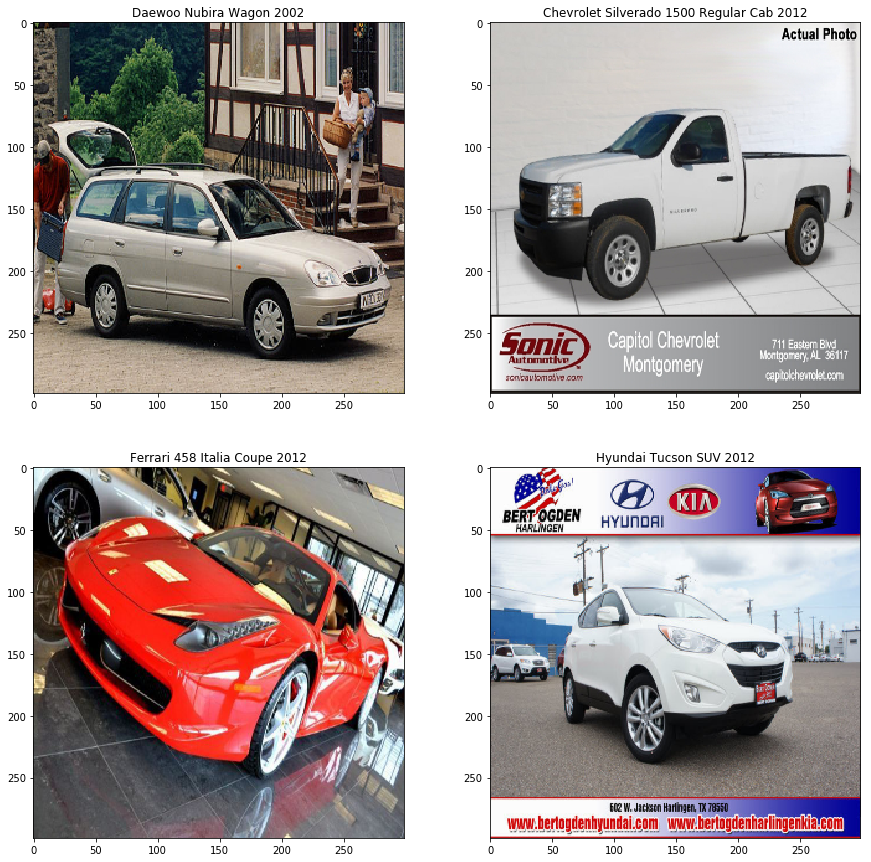

In [83]:
train_sample = x_imgs.shape[0]
rand= np.random.randint(0,train_sample,4)

fig=plt.figure(figsize=(15, 15))
columns = 2
rows = 2
for i in range(1, columns*rows +1):
    r = rand[i-1]
    img = x_imgs[r]
    cla_id = df_train['class_id'][r]
    cla_name = df_train['class_name'][r]
    fig.add_subplot(rows, columns, i)
    plt.title(cla_name)
    plt.imshow(img)

plt.show()

### Load Test Images

In [94]:
x_imgs1 = np.zeros((len(df_test), im_heigth, im_width, im_chan), dtype=np.uint8)
y_imgs1 = np.zeros((len(df_test), 1), dtype=np.uint8)

for n, id_ in tqdm_notebook(enumerate(df_test['fname']), total=len(df_test['fname'])):
    imgs1 = load_img(df_test['fname'][n])
    imgs1 = img_to_array(imgs1)
    imgs1 = resize(imgs1, (im_width, im_heigth, im_chan), mode='constant', preserve_range=True)
    x_imgs1[n] = imgs1
    
    y_imgs1[n] = np.int(df_test['class_id'][n])

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

In [95]:
print("test set x shape :", x_imgs1.shape)
print("test set y shape :", y_imgs1.shape)

test set x shape : (8041, 299, 299, 3)
test set y shape : (8041, 1)


### Checking if we load the right data.

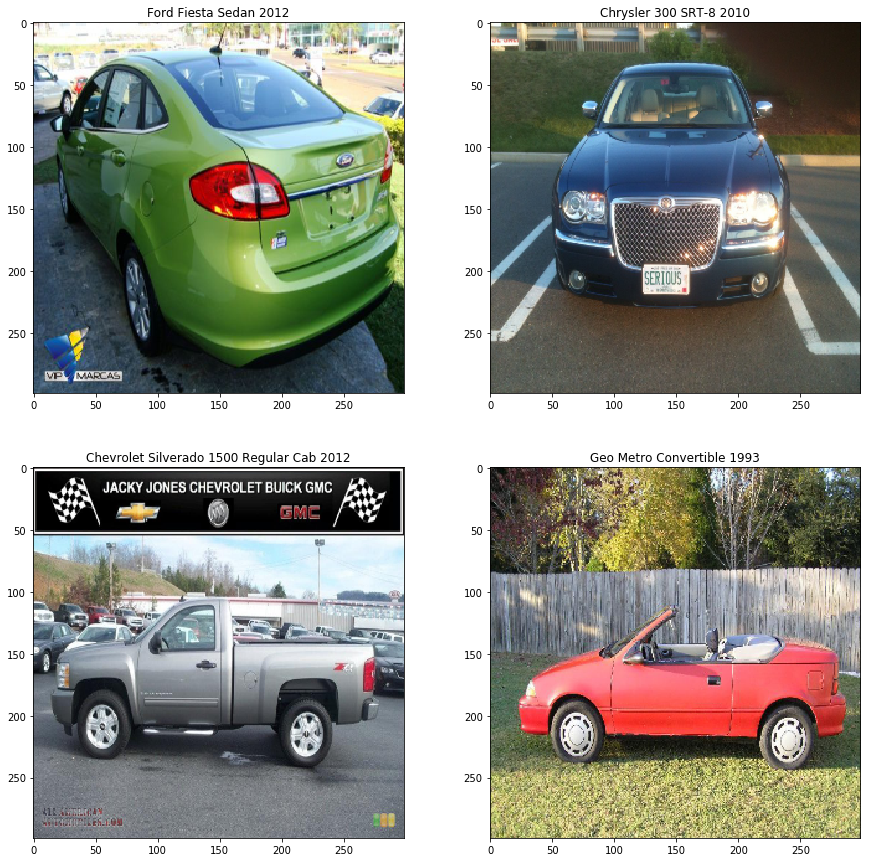

In [96]:
test_sample = x_imgs1.shape[0]
rand1= np.random.randint(0,test_sample,4)

fig1=plt.figure(figsize=(15, 15))
columns = 2
rows = 2
for i in range(1, columns*rows +1):
    r = rand1[i-1]
    img1 = x_imgs1[r]
    cla_id1 = df_test['class_id'][r]
    cla_name1 = df_test['class_name'][r]
    fig1.add_subplot(rows, columns, i)
    plt.title(cla_name1)
    plt.imshow(img1)

plt.show()

## 2.2 Exploratory Data Analysis

### Distribution of Output Variable

In [97]:
# Checking the class frequency

freq_labels = df_train.groupby('class_name').count()[['class_id']]
freq_labels = freq_labels.rename(columns={'class': 'count'})
freq_labels = freq_labels.sort_values(by='class_id', ascending=False)
freq_labels.head(10)

class_id
class_name                                        
GMC Savana Van 2012                             68
Chrysler 300 SRT-8 2010                         49
Mercedes-Benz 300-Class Convertible 1993        48
Mitsubishi Lancer Sedan 2012                    48
Jaguar XK XKR 2012                              47
Chevrolet Corvette ZR1 2012                     47
Audi S6 Sedan 2011                              46
Volkswagen Golf Hatchback 1991                  46
Ford GT Coupe 2006                              46
Suzuki Kizashi Sedan 2012                       46

In [98]:
freq_labels.to_csv(r'cars_count.csv', header = True)

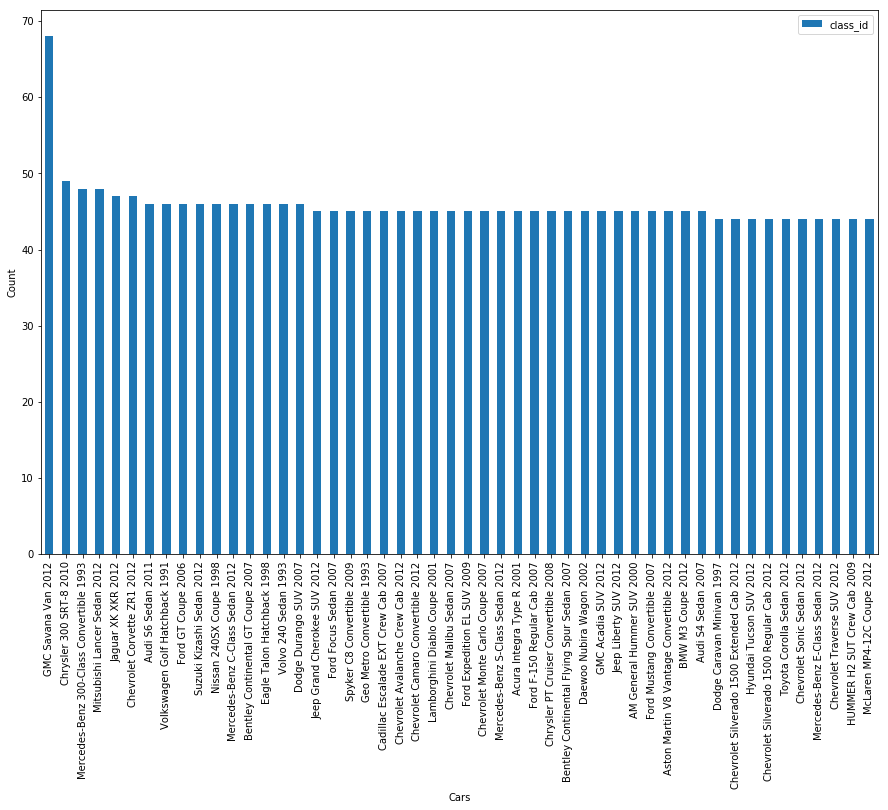

In [99]:
freq_labels.head(50).plot.bar(figsize=(15,10))
plt.xticks(rotation=90);
plt.xlabel("Cars");
plt.ylabel("Count");

In [100]:
from collections import Counter

print('The data set is imbalanced: {}'.format(Counter(df_train['class_id'])))

The data set is imbalanced: Counter({118: 68, 78: 49, 166: 48, 160: 48, 143: 47, 55: 47, 193: 46, 190: 46, 42: 46, 19: 46, 111: 46, 161: 46, 170: 46, 181: 46, 97: 46, 94: 46, 122: 45, 72: 45, 147: 45, 52: 45, 43: 45, 64: 45, 113: 45, 7: 45, 58: 45, 164: 45, 120: 45, 146: 45, 108: 45, 178: 45, 23: 45, 0: 45, 5: 45, 71: 45, 106: 45, 152: 45, 114: 45, 80: 45, 33: 45, 81: 45, 88: 44, 57: 44, 84: 44, 171: 44, 169: 44, 104: 44, 176: 44, 172: 44, 186: 44, 93: 44, 187: 44, 144: 44, 73: 44, 136: 44, 75: 44, 107: 44, 124: 44, 159: 44, 15: 44, 62: 44, 131: 44, 30: 44, 45: 44, 150: 44, 86: 44, 74: 44, 163: 44, 13: 43, 2: 43, 191: 43, 119: 43, 85: 43, 179: 43, 153: 43, 138: 43, 103: 43, 14: 43, 189: 43, 28: 43, 109: 43, 17: 43, 50: 43, 60: 43, 154: 43, 148: 43, 47: 43, 194: 43, 21: 43, 112: 43, 116: 43, 69: 43, 145: 43, 79: 43, 105: 42, 134: 42, 192: 42, 65: 42, 132: 42, 96: 42, 100: 42, 110: 42, 125: 42, 130: 42, 177: 42, 139: 42, 29: 42, 49: 42, 182: 42, 83: 42, 167: 42, 20: 42, 31: 42, 3: 42, 11

It can be seen that:
    
    - Label samples are biased to some labels.
    - Balancing weight for each class may improve LB score.

In [101]:
from sklearn.utils.class_weight import compute_class_weight

#y_integers = np.argmax(y_train1, axis=1)
class_weights = compute_class_weight('balanced', np.unique(df_train['class_id']), df_train['class_id'])
class_weights = dict(enumerate(class_weights))

## 2.3 Feature Extraction

### Extract Bottleneck Features for Train and Test Data


As metioned before, every model have their own types of data. Therefore, different data are created for each model.
Function from [Yang Peiwan's kernel](https://www.kaggle.com/yangpeiwen/keras-inception-xception-0-47) with modifications:

In [102]:
def get_features(MODEL, data, batch_size, preprocess):
    
    cnn_model = MODEL(include_top=False, input_shape=(im_width, im_heigth, im_chan), weights='imagenet')
    
    inputs = Input((im_width, im_heigth, im_chan))
    x = inputs
    x = Lambda(preprocess, name='preprocessing')(x)
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)

    features = cnn_model.predict(data, batch_size=batch_size, verbose=1)
    return features### InceptionV3

### InceptionV3

In [103]:
inception_train_features = get_features(InceptionV3, x_imgs, 32, inception_v3_pre)
inception_test_features = get_features(InceptionV3, x_imgs1, 32, inception_v3_pre)

8041/8041 [==============================] - ETA: 52:0 - ETA: 26:2 - ETA: 17:5 - ETA: 13:3 - ETA: 11:0 - ETA: 9:1 - ETA: 8: - ETA: 7: - ETA: 6: - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 59 - ETA: 58 - ETA: 57 - ETA: 57 - ETA

### Xception

In [104]:
xception_train_features = get_features(Xception, x_imgs, 32, xception_pre)
xception_test_features = get_features(Xception, x_imgs1, 32, xception_pre)

8041/8041 [==============================] - ETA: 55:2 - ETA: 28:3 - ETA: 19:3 - ETA: 15:0 - ETA: 12:1 - ETA: 10:3 - ETA: 9:1 - ETA: 8: - ETA: 7: - ETA: 6: - ETA: 6: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ET

### Resnet50

In [105]:
resnet_train_features = get_features(ResNet50, x_imgs, 32, resnet50_pre)
resnet_test_features = get_features(ResNet50, x_imgs1, 32, resnet50_pre)

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


8144/8144 [==============================] - ETA: 1:01:5 - ETA: 31:36  - ETA: 21:2 - ETA: 16:2 - ETA: 13:2 - ETA: 11:2 - ETA: 9:5 - ETA: 8: - ETA: 7: - ETA: 7: - ETA: 6: - ETA: 6: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: 

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


8041/8041 [==============================] - ETA: 1:09:3 - ETA: 35:22  - ETA: 23:5 - ETA: 18:1 - ETA: 14:5 - ETA: 12:3 - ETA: 10:5 - ETA: 9:4 - ETA: 8: - ETA: 7: - ETA: 7: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1

### InceptionResNetV2

In [106]:
inceptionresnet_train_features = get_features(InceptionResNetV2, x_imgs, 32, InceptionResNetV2_pre)
inceptionresnet_test_features = get_features(InceptionResNetV2, x_imgs1, 32, InceptionResNetV2_pre)

8041/8041 [==============================] - ETA: 2:43:1 - ETA: 1:22:2 - ETA: 55:23  - ETA: 41:5 - ETA: 33:4 - ETA: 28:2 - ETA: 24:3 - ETA: 21:3 - ETA: 19:2 - ETA: 17:3 - ETA: 16:0 - ETA: 14:5 - ETA: 13:5 - ETA: 12:5 - ETA: 12:1 - ETA: 11:2 - ETA: 10:5 - ETA: 10:2 - ETA: 9:5 - ETA: 9: - ETA: 9: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ET

### VGG19

In [107]:
vgg_train_features = get_features(VGG19, x_imgs, 32, vgg19_pre)
vgg_test_features = get_features(VGG19, x_imgs1, 32, vgg19_pre)

8041/8041 [==============================] - ETA: 1:00:5 - ETA: 31:22  - ETA: 21:2 - ETA: 16:3 - ETA: 13:3 - ETA: 11:3 - ETA: 10:1 - ETA: 9:0 - ETA: 8: - ETA: 7: - ETA: 7: - ETA: 6: - ETA: 6: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1

# 3. Training/Validating Pipeline

## 3.1. Split Test/Valid dataset

### Split test data for model validation and testing, with 40% validation and 60% testing

In [108]:
from keras.utils import to_categorical

y_train = to_categorical(df_train['class_id'])
y_test = to_categorical(df_test['class_id'])

In [112]:
X_valid_xception, X_test_xception, y_valid_xception, y_test_xception =  train_test_split(xception_test_features, y_test, test_size=0.6, random_state=99)
X_valid_inception, X_test_inception, y_valid_inception, y_test_inception = train_test_split(inception_test_features, y_test, test_size=0.6, random_state=99)
X_valid_vgg, X_test_vgg, y_valid_vgg, y_test_vgg = train_test_split(vgg_test_features, y_test, test_size=0.6, random_state=99)
X_valid_resnet, X_test_resnet, y_valid_resnet, y_test_resnet = train_test_split(resnet_test_features, y_test, test_size=0.6, random_state=99)
X_valid_inceptionresnet, X_test_inceptionresnet, y_valid_inceptionresnet, y_test_inceptionresnet = train_test_split(inceptionresnet_test_features, y_test, test_size=0.6, random_state=99)

In [113]:
print("x train shape :", inception_train_features.shape[0])
print("x valid shape :", X_valid_xception.shape[0])
print("x test shape :", X_test_xception.shape[0])
print("y train shape :", y_train.shape[0])
print("y valid shape :", y_valid_xception.shape[0])
print("y train shape :", y_test_xception.shape[0])

x train shape : 8144
x valid shape : 3216
x test shape : 4825
y train shape : 8144
y valid shape : 3216
y train shape : 4825


## If you want to Test the trained model, skip 3.1 and move to 3.3

Since I provided the trained model for all Inception, Xception, VGG19, Resnet50, InceptionResnet, and the Ensemble Model. You can skip this part.

## 3.2. Classifiers


### Neural Net

In [114]:
n_class = 196

Inception_model = Sequential()
Inception_model.add(Dense(512, activation='relu', input_shape=inception_train_features.shape[1:]))
Inception_model.add(Dropout(0.2))
Inception_model.add(Dense(n_class, activation='softmax'))

Inception_model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'],
           )

Inception_model.summary()


Xception_model = Sequential()
Xception_model.add(Dense(512, activation='relu', input_shape=xception_train_features.shape[1:]))
Xception_model.add(Dropout(0.2))
Xception_model.add(Dense(n_class, activation='softmax'))

Xception_model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'],
           )

Xception_model.summary()


VGG_model = Sequential()
VGG_model.add(Dense(512, activation='relu', input_shape=vgg_train_features.shape[1:]))
VGG_model.add(Dropout(0.2))
VGG_model.add(Dense(n_class, activation='softmax'))

VGG_model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'], 
           )

VGG_model.summary()

Resnet_model = Sequential()
Resnet_model.add(Dense(512, activation='relu', input_shape=resnet_train_features.shape[1:]))
Resnet_model.add(Dropout(0.2))
Resnet_model.add(Dense(n_class, activation='softmax'))

Resnet_model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'],
           )

Resnet_model.summary()

InceptionResnet_model = Sequential()
InceptionResnet_model.add(Dense(512, activation='relu', input_shape=inceptionresnet_train_features.shape[1:]))
InceptionResnet_model.add(Dropout(0.2))
InceptionResnet_model.add(Dense(n_class, activation='softmax'))

InceptionResnet_model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'],
           )

InceptionResnet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_15 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 196)               100548    
Total params: 1,149,636
Trainable params: 1,149,636
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)               0         
_________________________________________________________________


### Callbacks

- ModelCheckpoint is used to get the best model after epochs

- ReduceLROnPlateau is used to manipulate learning rate for more delciate correction

- EarlyStopping stop the model if there is no improvement to validation loss. This is to avoid model overfit and wasting time.

In [115]:
early_stopping = EarlyStopping(monitor='val_loss', mode = 'min',patience=100, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode = 'min',factor=0.5, patience=50, min_lr=0.00001, verbose=1)

inception_callbacks=[TQDMNotebookCallback(),
                     reduce_lr,
                      ModelCheckpoint(filepath='saved_models/inception.best.from_features.hdf5', 
                               verbose=1, save_best_only=True),
                     early_stopping
                     ]

xception_callbacks=[TQDMNotebookCallback(),
                    reduce_lr,
                      ModelCheckpoint(filepath='saved_models/xception.best.from_features.hdf5', 
                               verbose=1, save_best_only=True),
                    early_stopping
                     ]

resnet_callbacks=[TQDMNotebookCallback(),
                    reduce_lr,
                    ModelCheckpoint(filepath='saved_models/resnet.best.from_features.hdf5', 
                               verbose=1, save_best_only=True),
                  early_stopping
                     ]

vgg_callbacks=[TQDMNotebookCallback(),
                reduce_lr,
                ModelCheckpoint(filepath='saved_models/vgg.best.from_features.hdf5', 
                               verbose=1, save_best_only=True),
               early_stopping
                     ]

inceptionresnet_callbacks=[TQDMNotebookCallback(),
                reduce_lr,
                ModelCheckpoint(filepath='saved_models/inceptionresnet.best.from_features.hdf5', 
                               verbose=1, save_best_only=True),
               early_stopping
                     ]

In [116]:
epochs = 1000 # Increase this if you want more accurate results(It is recommended to run on personal computer in this case)

inception_history = Inception_model.fit(inception_train_features, y_train, 
          validation_data=(X_valid_inception, y_valid_inception),
          epochs=epochs, 
          callbacks=inception_callbacks,
          class_weight=class_weights,
          batch_size=32, verbose=0)

xception_history = Xception_model.fit(xception_train_features, y_train, 
          validation_data=(X_valid_xception, y_valid_xception),
          epochs=epochs,                            
          callbacks=xception_callbacks,
          class_weight=class_weights,
          batch_size=32, verbose=0)

resnet_history = Resnet_model.fit(resnet_train_features, y_train, 
          validation_data=(X_valid_resnet, y_valid_resnet),
          epochs=epochs, 
          callbacks=resnet_callbacks,
          class_weight=class_weights,
          batch_size=32, verbose=0)

vgg_history = VGG_model.fit(vgg_train_features, y_train, 
          validation_data=(X_valid_vgg, y_valid_vgg),
          epochs=epochs, 
          callbacks=vgg_callbacks,
          class_weight=class_weights,
          batch_size=32, verbose=0)

inceptionresnet_history = InceptionResnet_model.fit(inceptionresnet_train_features, y_train, 
                        validation_data=(X_valid_inceptionresnet, y_valid_inceptionresnet),
                        epochs=epochs, 
                        callbacks=inceptionresnet_callbacks,
                        class_weight=class_weights,
                        batch_size=32, verbose=0)


Epoch 00001: val_loss improved from inf to 3.66915, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00002: val_loss improved from 3.66915 to 3.26379, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00003: val_loss improved from 3.26379 to 3.02238, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00004: val_loss improved from 3.02238 to 2.77438, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00005: val_loss improved from 2.77438 to 2.66256, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00006: val_loss improved from 2.66256 to 2.58871, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00007: val_loss improved from 2.58871 to 2.48598, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00008: val_loss improved from 2.48598 to 2.39986, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00009: val_loss improved from 2.39986 to 2.36273, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00010: val_loss improved from 2.36273 to 2.34465, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00011: val_loss improved from 2.34465 to 2.31233, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00012: val_loss improved from 2.31233 to 2.29800, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00013: val_loss improved from 2.29800 to 2.23884, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00014: val_loss did not improve from 2.23884



Epoch 00015: val_loss improved from 2.23884 to 2.18775, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00016: val_loss did not improve from 2.18775



Epoch 00017: val_loss did not improve from 2.18775



Epoch 00018: val_loss did not improve from 2.18775



Epoch 00019: val_loss did not improve from 2.18775



Epoch 00020: val_loss did not improve from 2.18775



Epoch 00021: val_loss did not improve from 2.18775



Epoch 00022: val_loss did not improve from 2.18775



Epoch 00023: val_loss did not improve from 2.18775



Epoch 00024: val_loss did not improve from 2.18775



Epoch 00025: val_loss did not improve from 2.18775



Epoch 00026: val_loss did not improve from 2.18775



Epoch 00027: val_loss did not improve from 2.18775



Epoch 00028: val_loss did not improve from 2.18775



Epoch 00029: val_loss did not improve from 2.18775



Epoch 00030: val_loss did not improve from 2.18775



Epoch 00031: val_loss did not improve from 2.18775



Epoch 00032: val_loss did not improve from 2.18775



Epoch 00033: val_loss did not improve from 2.18775



Epoch 00034: val_loss did not improve from 2.18775



Epoch 00035: val_loss did not improve from 2.18775



Epoch 00036: val_loss did not improve from 2.18775



Epoch 00037: val_loss did not improve from 2.18775



Epoch 00038: val_loss did not improve from 2.18775



Epoch 00039: val_loss did not improve from 2.18775



Epoch 00040: val_loss did not improve from 2.18775



Epoch 00041: val_loss did not improve from 2.18775



Epoch 00042: val_loss did not improve from 2.18775



Epoch 00043: val_loss did not improve from 2.18775



Epoch 00044: val_loss did not improve from 2.18775



Epoch 00045: val_loss did not improve from 2.18775



Epoch 00046: val_loss did not improve from 2.18775



Epoch 00047: val_loss did not improve from 2.18775



Epoch 00048: val_loss did not improve from 2.18775



Epoch 00049: val_loss did not improve from 2.18775



Epoch 00050: val_loss did not improve from 2.18775



Epoch 00051: val_loss did not improve from 2.18775



Epoch 00052: val_loss did not improve from 2.18775



Epoch 00053: val_loss did not improve from 2.18775



Epoch 00054: val_loss did not improve from 2.18775



Epoch 00055: val_loss did not improve from 2.18775



Epoch 00056: val_loss did not improve from 2.18775



Epoch 00057: val_loss did not improve from 2.18775



Epoch 00058: val_loss did not improve from 2.18775



Epoch 00059: val_loss did not improve from 2.18775



Epoch 00060: val_loss did not improve from 2.18775



Epoch 00061: val_loss did not improve from 2.18775



Epoch 00062: val_loss did not improve from 2.18775



Epoch 00063: val_loss did not improve from 2.18775



Epoch 00064: val_loss did not improve from 2.18775



Epoch 00065: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00065: val_loss did not improve from 2.18775



Epoch 00066: val_loss did not improve from 2.18775



Epoch 00067: val_loss did not improve from 2.18775



Epoch 00068: val_loss did not improve from 2.18775



Epoch 00069: val_loss did not improve from 2.18775



Epoch 00070: val_loss did not improve from 2.18775



Epoch 00071: val_loss did not improve from 2.18775



Epoch 00072: val_loss did not improve from 2.18775



Epoch 00073: val_loss did not improve from 2.18775



Epoch 00074: val_loss did not improve from 2.18775



Epoch 00075: val_loss did not improve from 2.18775



Epoch 00076: val_loss did not improve from 2.18775



Epoch 00077: val_loss did not improve from 2.18775



Epoch 00078: val_loss did not improve from 2.18775



Epoch 00079: val_loss did not improve from 2.18775



Epoch 00080: val_loss did not improve from 2.18775



Epoch 00081: val_loss did not improve from 2.18775



Epoch 00082: val_loss did not improve from 2.18775



Epoch 00083: val_loss did not improve from 2.18775



Epoch 00084: val_loss did not improve from 2.18775



Epoch 00085: val_loss did not improve from 2.18775



Epoch 00086: val_loss did not improve from 2.18775



Epoch 00087: val_loss did not improve from 2.18775



Epoch 00088: val_loss did not improve from 2.18775



Epoch 00089: val_loss did not improve from 2.18775



Epoch 00090: val_loss did not improve from 2.18775



Epoch 00091: val_loss did not improve from 2.18775



Epoch 00092: val_loss did not improve from 2.18775



Epoch 00093: val_loss did not improve from 2.18775



Epoch 00094: val_loss did not improve from 2.18775



Epoch 00095: val_loss did not improve from 2.18775



Epoch 00096: val_loss did not improve from 2.18775



Epoch 00097: val_loss did not improve from 2.18775



Epoch 00098: val_loss did not improve from 2.18775



Epoch 00099: val_loss did not improve from 2.18775



Epoch 00100: val_loss did not improve from 2.18775



Epoch 00101: val_loss did not improve from 2.18775



Epoch 00102: val_loss did not improve from 2.18775



Epoch 00103: val_loss did not improve from 2.18775



Epoch 00104: val_loss did not improve from 2.18775



Epoch 00105: val_loss did not improve from 2.18775



Epoch 00106: val_loss did not improve from 2.18775



Epoch 00107: val_loss did not improve from 2.18775



Epoch 00108: val_loss did not improve from 2.18775



Epoch 00109: val_loss did not improve from 2.18775



Epoch 00110: val_loss did not improve from 2.18775



Epoch 00111: val_loss did not improve from 2.18775



Epoch 00112: val_loss did not improve from 2.18775



Epoch 00113: val_loss did not improve from 2.18775



Epoch 00114: val_loss did not improve from 2.18775



Epoch 00115: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00115: val_loss did not improve from 2.18775
Epoch 00115: early stopping



Epoch 00001: val_loss improved from inf to 3.35381, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00002: val_loss improved from 3.35381 to 2.99116, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00003: val_loss improved from 2.99116 to 2.76459, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00004: val_loss improved from 2.76459 to 2.59146, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00005: val_loss improved from 2.59146 to 2.50118, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00006: val_loss improved from 2.50118 to 2.38456, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00007: val_loss improved from 2.38456 to 2.32060, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00008: val_loss improved from 2.32060 to 2.23956, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00009: val_loss improved from 2.23956 to 2.22754, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00010: val_loss improved from 2.22754 to 2.15440, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00011: val_loss did not improve from 2.15440



Epoch 00012: val_loss improved from 2.15440 to 2.14671, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00013: val_loss improved from 2.14671 to 2.12570, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00014: val_loss improved from 2.12570 to 2.10828, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00015: val_loss did not improve from 2.10828



Epoch 00016: val_loss did not improve from 2.10828



Epoch 00017: val_loss did not improve from 2.10828



Epoch 00018: val_loss did not improve from 2.10828



Epoch 00019: val_loss did not improve from 2.10828



Epoch 00020: val_loss did not improve from 2.10828



Epoch 00021: val_loss did not improve from 2.10828



Epoch 00022: val_loss did not improve from 2.10828



Epoch 00023: val_loss did not improve from 2.10828



Epoch 00024: val_loss did not improve from 2.10828



Epoch 00025: val_loss did not improve from 2.10828



Epoch 00026: val_loss did not improve from 2.10828



Epoch 00027: val_loss did not improve from 2.10828



Epoch 00028: val_loss did not improve from 2.10828



Epoch 00029: val_loss did not improve from 2.10828



Epoch 00030: val_loss did not improve from 2.10828



Epoch 00031: val_loss did not improve from 2.10828



Epoch 00032: val_loss did not improve from 2.10828



Epoch 00033: val_loss did not improve from 2.10828



Epoch 00034: val_loss did not improve from 2.10828



Epoch 00035: val_loss did not improve from 2.10828



Epoch 00036: val_loss did not improve from 2.10828



Epoch 00037: val_loss did not improve from 2.10828



Epoch 00038: val_loss did not improve from 2.10828



Epoch 00039: val_loss did not improve from 2.10828



Epoch 00040: val_loss did not improve from 2.10828



Epoch 00041: val_loss did not improve from 2.10828



Epoch 00042: val_loss did not improve from 2.10828



Epoch 00043: val_loss did not improve from 2.10828



Epoch 00044: val_loss did not improve from 2.10828



Epoch 00045: val_loss did not improve from 2.10828



Epoch 00046: val_loss did not improve from 2.10828



Epoch 00047: val_loss did not improve from 2.10828



Epoch 00048: val_loss did not improve from 2.10828



Epoch 00049: val_loss did not improve from 2.10828



Epoch 00050: val_loss did not improve from 2.10828



Epoch 00051: val_loss did not improve from 2.10828



Epoch 00052: val_loss did not improve from 2.10828



Epoch 00053: val_loss did not improve from 2.10828



Epoch 00054: val_loss did not improve from 2.10828



Epoch 00055: val_loss did not improve from 2.10828



Epoch 00056: val_loss did not improve from 2.10828



Epoch 00057: val_loss did not improve from 2.10828



Epoch 00058: val_loss did not improve from 2.10828



Epoch 00059: val_loss did not improve from 2.10828



Epoch 00060: val_loss did not improve from 2.10828



Epoch 00061: val_loss did not improve from 2.10828



Epoch 00062: val_loss did not improve from 2.10828



Epoch 00063: val_loss did not improve from 2.10828



Epoch 00064: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00064: val_loss did not improve from 2.10828



Epoch 00065: val_loss did not improve from 2.10828



Epoch 00066: val_loss did not improve from 2.10828



Epoch 00067: val_loss did not improve from 2.10828



Epoch 00068: val_loss did not improve from 2.10828



Epoch 00069: val_loss did not improve from 2.10828



Epoch 00070: val_loss did not improve from 2.10828



Epoch 00071: val_loss did not improve from 2.10828



Epoch 00072: val_loss did not improve from 2.10828



Epoch 00073: val_loss did not improve from 2.10828



Epoch 00074: val_loss did not improve from 2.10828



Epoch 00075: val_loss did not improve from 2.10828



Epoch 00076: val_loss did not improve from 2.10828



Epoch 00077: val_loss did not improve from 2.10828



Epoch 00078: val_loss did not improve from 2.10828



Epoch 00079: val_loss did not improve from 2.10828



Epoch 00080: val_loss did not improve from 2.10828



Epoch 00081: val_loss did not improve from 2.10828



Epoch 00082: val_loss did not improve from 2.10828



Epoch 00083: val_loss did not improve from 2.10828



Epoch 00084: val_loss did not improve from 2.10828



Epoch 00085: val_loss did not improve from 2.10828



Epoch 00086: val_loss did not improve from 2.10828



Epoch 00087: val_loss did not improve from 2.10828



Epoch 00088: val_loss did not improve from 2.10828



Epoch 00089: val_loss did not improve from 2.10828



Epoch 00090: val_loss did not improve from 2.10828



Epoch 00091: val_loss did not improve from 2.10828



Epoch 00092: val_loss did not improve from 2.10828



Epoch 00093: val_loss did not improve from 2.10828



Epoch 00094: val_loss did not improve from 2.10828



Epoch 00095: val_loss did not improve from 2.10828



Epoch 00096: val_loss did not improve from 2.10828



Epoch 00097: val_loss did not improve from 2.10828



Epoch 00098: val_loss did not improve from 2.10828



Epoch 00099: val_loss did not improve from 2.10828



Epoch 00100: val_loss did not improve from 2.10828



Epoch 00101: val_loss did not improve from 2.10828



Epoch 00102: val_loss did not improve from 2.10828



Epoch 00103: val_loss did not improve from 2.10828



Epoch 00104: val_loss did not improve from 2.10828



Epoch 00105: val_loss did not improve from 2.10828



Epoch 00106: val_loss did not improve from 2.10828



Epoch 00107: val_loss did not improve from 2.10828



Epoch 00108: val_loss did not improve from 2.10828



Epoch 00109: val_loss did not improve from 2.10828



Epoch 00110: val_loss did not improve from 2.10828



Epoch 00111: val_loss did not improve from 2.10828



Epoch 00112: val_loss did not improve from 2.10828



Epoch 00113: val_loss did not improve from 2.10828



Epoch 00114: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00114: val_loss did not improve from 2.10828
Epoch 00114: early stopping



Epoch 00001: val_loss improved from inf to 3.76934, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00002: val_loss improved from 3.76934 to 2.97869, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00003: val_loss improved from 2.97869 to 2.63542, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00004: val_loss improved from 2.63542 to 2.35370, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00005: val_loss improved from 2.35370 to 2.22156, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00006: val_loss improved from 2.22156 to 2.10565, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00007: val_loss improved from 2.10565 to 1.99276, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00008: val_loss improved from 1.99276 to 1.90703, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00009: val_loss improved from 1.90703 to 1.82999, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00010: val_loss improved from 1.82999 to 1.81644, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00011: val_loss improved from 1.81644 to 1.73685, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00012: val_loss did not improve from 1.73685



Epoch 00013: val_loss improved from 1.73685 to 1.73011, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00014: val_loss did not improve from 1.73011



Epoch 00015: val_loss improved from 1.73011 to 1.71969, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00016: val_loss did not improve from 1.71969



Epoch 00017: val_loss did not improve from 1.71969



Epoch 00018: val_loss improved from 1.71969 to 1.71313, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00019: val_loss did not improve from 1.71313



Epoch 00020: val_loss did not improve from 1.71313



Epoch 00021: val_loss did not improve from 1.71313



Epoch 00022: val_loss did not improve from 1.71313



Epoch 00023: val_loss did not improve from 1.71313



Epoch 00024: val_loss did not improve from 1.71313



Epoch 00025: val_loss did not improve from 1.71313



Epoch 00026: val_loss did not improve from 1.71313



Epoch 00027: val_loss did not improve from 1.71313



Epoch 00028: val_loss did not improve from 1.71313



Epoch 00029: val_loss did not improve from 1.71313



Epoch 00030: val_loss did not improve from 1.71313



Epoch 00031: val_loss did not improve from 1.71313



Epoch 00032: val_loss did not improve from 1.71313



Epoch 00033: val_loss did not improve from 1.71313



Epoch 00034: val_loss did not improve from 1.71313



Epoch 00035: val_loss did not improve from 1.71313



Epoch 00036: val_loss did not improve from 1.71313



Epoch 00037: val_loss did not improve from 1.71313



Epoch 00038: val_loss did not improve from 1.71313



Epoch 00039: val_loss did not improve from 1.71313



Epoch 00040: val_loss did not improve from 1.71313



Epoch 00041: val_loss did not improve from 1.71313



Epoch 00042: val_loss did not improve from 1.71313



Epoch 00043: val_loss did not improve from 1.71313



Epoch 00044: val_loss did not improve from 1.71313



Epoch 00045: val_loss did not improve from 1.71313



Epoch 00046: val_loss did not improve from 1.71313



Epoch 00047: val_loss did not improve from 1.71313



Epoch 00048: val_loss did not improve from 1.71313



Epoch 00049: val_loss did not improve from 1.71313



Epoch 00050: val_loss did not improve from 1.71313



Epoch 00051: val_loss did not improve from 1.71313



Epoch 00052: val_loss did not improve from 1.71313



Epoch 00053: val_loss did not improve from 1.71313



Epoch 00054: val_loss did not improve from 1.71313



Epoch 00055: val_loss did not improve from 1.71313



Epoch 00056: val_loss did not improve from 1.71313



Epoch 00057: val_loss did not improve from 1.71313



Epoch 00058: val_loss did not improve from 1.71313



Epoch 00059: val_loss did not improve from 1.71313



Epoch 00060: val_loss did not improve from 1.71313



Epoch 00061: val_loss did not improve from 1.71313



Epoch 00062: val_loss did not improve from 1.71313



Epoch 00063: val_loss did not improve from 1.71313



Epoch 00064: val_loss did not improve from 1.71313



Epoch 00065: val_loss did not improve from 1.71313



Epoch 00066: val_loss did not improve from 1.71313



Epoch 00067: val_loss did not improve from 1.71313



Epoch 00068: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00068: val_loss did not improve from 1.71313



Epoch 00069: val_loss did not improve from 1.71313



Epoch 00070: val_loss did not improve from 1.71313



Epoch 00071: val_loss did not improve from 1.71313



Epoch 00072: val_loss did not improve from 1.71313



Epoch 00073: val_loss did not improve from 1.71313



Epoch 00074: val_loss did not improve from 1.71313



Epoch 00075: val_loss did not improve from 1.71313



Epoch 00076: val_loss did not improve from 1.71313



Epoch 00077: val_loss did not improve from 1.71313



Epoch 00078: val_loss did not improve from 1.71313



Epoch 00079: val_loss did not improve from 1.71313



Epoch 00080: val_loss did not improve from 1.71313



Epoch 00081: val_loss did not improve from 1.71313



Epoch 00082: val_loss did not improve from 1.71313



Epoch 00083: val_loss did not improve from 1.71313



Epoch 00084: val_loss did not improve from 1.71313



Epoch 00085: val_loss did not improve from 1.71313



Epoch 00086: val_loss did not improve from 1.71313



Epoch 00087: val_loss did not improve from 1.71313



Epoch 00088: val_loss did not improve from 1.71313



Epoch 00089: val_loss did not improve from 1.71313



Epoch 00090: val_loss did not improve from 1.71313



Epoch 00091: val_loss did not improve from 1.71313



Epoch 00092: val_loss did not improve from 1.71313



Epoch 00093: val_loss did not improve from 1.71313



Epoch 00094: val_loss did not improve from 1.71313



Epoch 00095: val_loss did not improve from 1.71313



Epoch 00096: val_loss did not improve from 1.71313



Epoch 00097: val_loss did not improve from 1.71313



Epoch 00098: val_loss did not improve from 1.71313



Epoch 00099: val_loss did not improve from 1.71313



Epoch 00100: val_loss did not improve from 1.71313



Epoch 00101: val_loss did not improve from 1.71313



Epoch 00102: val_loss did not improve from 1.71313



Epoch 00103: val_loss did not improve from 1.71313



Epoch 00104: val_loss did not improve from 1.71313



Epoch 00105: val_loss did not improve from 1.71313



Epoch 00106: val_loss did not improve from 1.71313



Epoch 00107: val_loss did not improve from 1.71313



Epoch 00108: val_loss did not improve from 1.71313



Epoch 00109: val_loss did not improve from 1.71313



Epoch 00110: val_loss did not improve from 1.71313



Epoch 00111: val_loss did not improve from 1.71313



Epoch 00112: val_loss did not improve from 1.71313



Epoch 00113: val_loss did not improve from 1.71313



Epoch 00114: val_loss did not improve from 1.71313



Epoch 00115: val_loss did not improve from 1.71313



Epoch 00116: val_loss did not improve from 1.71313



Epoch 00117: val_loss did not improve from 1.71313



Epoch 00118: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00118: val_loss did not improve from 1.71313
Epoch 00118: early stopping



Epoch 00001: val_loss improved from inf to 3.85678, saving model to saved_models/vgg.best.from_features.hdf5



Epoch 00002: val_loss improved from 3.85678 to 3.03636, saving model to saved_models/vgg.best.from_features.hdf5



Epoch 00003: val_loss improved from 3.03636 to 2.62343, saving model to saved_models/vgg.best.from_features.hdf5



Epoch 00004: val_loss improved from 2.62343 to 2.38356, saving model to saved_models/vgg.best.from_features.hdf5



Epoch 00005: val_loss improved from 2.38356 to 2.24622, saving model to saved_models/vgg.best.from_features.hdf5



Epoch 00006: val_loss improved from 2.24622 to 2.17223, saving model to saved_models/vgg.best.from_features.hdf5



Epoch 00007: val_loss did not improve from 2.17223



Epoch 00008: val_loss did not improve from 2.17223



Epoch 00009: val_loss improved from 2.17223 to 2.10875, saving model to saved_models/vgg.best.from_features.hdf5



Epoch 00010: val_loss did not improve from 2.10875



Epoch 00011: val_loss did not improve from 2.10875



Epoch 00012: val_loss did not improve from 2.10875



Epoch 00013: val_loss did not improve from 2.10875



Epoch 00014: val_loss did not improve from 2.10875



Epoch 00015: val_loss did not improve from 2.10875



Epoch 00016: val_loss did not improve from 2.10875



Epoch 00017: val_loss did not improve from 2.10875



Epoch 00018: val_loss did not improve from 2.10875



Epoch 00019: val_loss did not improve from 2.10875



Epoch 00020: val_loss did not improve from 2.10875



Epoch 00021: val_loss did not improve from 2.10875



Epoch 00022: val_loss did not improve from 2.10875



Epoch 00023: val_loss did not improve from 2.10875



Epoch 00024: val_loss did not improve from 2.10875



Epoch 00025: val_loss did not improve from 2.10875



Epoch 00026: val_loss did not improve from 2.10875



Epoch 00027: val_loss did not improve from 2.10875



Epoch 00028: val_loss did not improve from 2.10875



Epoch 00029: val_loss did not improve from 2.10875



Epoch 00030: val_loss did not improve from 2.10875



Epoch 00031: val_loss did not improve from 2.10875



Epoch 00032: val_loss did not improve from 2.10875



Epoch 00033: val_loss did not improve from 2.10875



Epoch 00034: val_loss did not improve from 2.10875



Epoch 00035: val_loss did not improve from 2.10875



Epoch 00036: val_loss did not improve from 2.10875



Epoch 00037: val_loss did not improve from 2.10875



Epoch 00038: val_loss did not improve from 2.10875



Epoch 00039: val_loss did not improve from 2.10875



Epoch 00040: val_loss did not improve from 2.10875



Epoch 00041: val_loss did not improve from 2.10875



Epoch 00042: val_loss did not improve from 2.10875



Epoch 00043: val_loss did not improve from 2.10875



Epoch 00044: val_loss did not improve from 2.10875



Epoch 00045: val_loss did not improve from 2.10875



Epoch 00046: val_loss did not improve from 2.10875



Epoch 00047: val_loss did not improve from 2.10875



Epoch 00048: val_loss did not improve from 2.10875



Epoch 00049: val_loss did not improve from 2.10875



Epoch 00050: val_loss did not improve from 2.10875



Epoch 00051: val_loss did not improve from 2.10875



Epoch 00052: val_loss did not improve from 2.10875



Epoch 00053: val_loss did not improve from 2.10875



Epoch 00054: val_loss did not improve from 2.10875



Epoch 00055: val_loss did not improve from 2.10875



Epoch 00056: val_loss did not improve from 2.10875



Epoch 00057: val_loss did not improve from 2.10875



Epoch 00058: val_loss did not improve from 2.10875



Epoch 00059: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00059: val_loss did not improve from 2.10875



Epoch 00060: val_loss did not improve from 2.10875



Epoch 00061: val_loss did not improve from 2.10875



Epoch 00062: val_loss did not improve from 2.10875



Epoch 00063: val_loss did not improve from 2.10875



Epoch 00064: val_loss did not improve from 2.10875



Epoch 00065: val_loss did not improve from 2.10875



Epoch 00066: val_loss did not improve from 2.10875



Epoch 00067: val_loss did not improve from 2.10875



Epoch 00068: val_loss did not improve from 2.10875



Epoch 00069: val_loss did not improve from 2.10875



Epoch 00070: val_loss did not improve from 2.10875



Epoch 00071: val_loss did not improve from 2.10875



Epoch 00072: val_loss did not improve from 2.10875



Epoch 00073: val_loss did not improve from 2.10875



Epoch 00074: val_loss did not improve from 2.10875



Epoch 00075: val_loss did not improve from 2.10875



Epoch 00076: val_loss did not improve from 2.10875



Epoch 00077: val_loss did not improve from 2.10875



Epoch 00078: val_loss did not improve from 2.10875



Epoch 00079: val_loss did not improve from 2.10875



Epoch 00080: val_loss did not improve from 2.10875



Epoch 00081: val_loss did not improve from 2.10875



Epoch 00082: val_loss did not improve from 2.10875



Epoch 00083: val_loss did not improve from 2.10875



Epoch 00084: val_loss did not improve from 2.10875



Epoch 00085: val_loss did not improve from 2.10875



Epoch 00086: val_loss did not improve from 2.10875



Epoch 00087: val_loss did not improve from 2.10875



Epoch 00088: val_loss did not improve from 2.10875



Epoch 00089: val_loss did not improve from 2.10875



Epoch 00090: val_loss did not improve from 2.10875



Epoch 00091: val_loss did not improve from 2.10875



Epoch 00092: val_loss did not improve from 2.10875



Epoch 00093: val_loss did not improve from 2.10875



Epoch 00094: val_loss did not improve from 2.10875



Epoch 00095: val_loss did not improve from 2.10875



Epoch 00096: val_loss did not improve from 2.10875



Epoch 00097: val_loss did not improve from 2.10875



Epoch 00098: val_loss did not improve from 2.10875



Epoch 00099: val_loss did not improve from 2.10875



Epoch 00100: val_loss did not improve from 2.10875



Epoch 00101: val_loss did not improve from 2.10875



Epoch 00102: val_loss did not improve from 2.10875



Epoch 00103: val_loss did not improve from 2.10875



Epoch 00104: val_loss did not improve from 2.10875



Epoch 00105: val_loss did not improve from 2.10875



Epoch 00106: val_loss did not improve from 2.10875



Epoch 00107: val_loss did not improve from 2.10875



Epoch 00108: val_loss did not improve from 2.10875



Epoch 00109: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00109: val_loss did not improve from 2.10875
Epoch 00109: early stopping



Epoch 00001: val_loss improved from inf to 3.61189, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00002: val_loss improved from 3.61189 to 3.31864, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00003: val_loss improved from 3.31864 to 3.11268, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00004: val_loss improved from 3.11268 to 2.97481, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00005: val_loss improved from 2.97481 to 2.87339, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00006: val_loss improved from 2.87339 to 2.77469, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00007: val_loss improved from 2.77469 to 2.72452, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00008: val_loss improved from 2.72452 to 2.61289, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00009: val_loss improved from 2.61289 to 2.56910, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00010: val_loss improved from 2.56910 to 2.53172, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00011: val_loss improved from 2.53172 to 2.51689, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00012: val_loss improved from 2.51689 to 2.44656, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00013: val_loss improved from 2.44656 to 2.40869, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00014: val_loss improved from 2.40869 to 2.39977, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00015: val_loss improved from 2.39977 to 2.35726, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00016: val_loss improved from 2.35726 to 2.34822, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00017: val_loss improved from 2.34822 to 2.30916, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00018: val_loss did not improve from 2.30916



Epoch 00019: val_loss improved from 2.30916 to 2.26741, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00020: val_loss did not improve from 2.26741



Epoch 00021: val_loss did not improve from 2.26741



Epoch 00022: val_loss did not improve from 2.26741



Epoch 00023: val_loss improved from 2.26741 to 2.21284, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00024: val_loss did not improve from 2.21284



Epoch 00025: val_loss did not improve from 2.21284



Epoch 00026: val_loss did not improve from 2.21284



Epoch 00027: val_loss improved from 2.21284 to 2.21122, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00028: val_loss improved from 2.21122 to 2.20848, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00029: val_loss did not improve from 2.20848



Epoch 00030: val_loss did not improve from 2.20848



Epoch 00031: val_loss did not improve from 2.20848



Epoch 00032: val_loss did not improve from 2.20848



Epoch 00033: val_loss did not improve from 2.20848



Epoch 00034: val_loss did not improve from 2.20848



Epoch 00035: val_loss did not improve from 2.20848



Epoch 00036: val_loss did not improve from 2.20848



Epoch 00037: val_loss did not improve from 2.20848



Epoch 00038: val_loss did not improve from 2.20848



Epoch 00039: val_loss did not improve from 2.20848



Epoch 00040: val_loss did not improve from 2.20848



Epoch 00041: val_loss did not improve from 2.20848



Epoch 00042: val_loss did not improve from 2.20848



Epoch 00043: val_loss did not improve from 2.20848



Epoch 00044: val_loss did not improve from 2.20848



Epoch 00045: val_loss did not improve from 2.20848



Epoch 00046: val_loss did not improve from 2.20848



Epoch 00047: val_loss did not improve from 2.20848



Epoch 00048: val_loss did not improve from 2.20848



Epoch 00049: val_loss did not improve from 2.20848



Epoch 00050: val_loss did not improve from 2.20848



Epoch 00051: val_loss did not improve from 2.20848



Epoch 00052: val_loss did not improve from 2.20848



Epoch 00053: val_loss did not improve from 2.20848



Epoch 00054: val_loss did not improve from 2.20848



Epoch 00055: val_loss did not improve from 2.20848



Epoch 00056: val_loss did not improve from 2.20848



Epoch 00057: val_loss did not improve from 2.20848



Epoch 00058: val_loss did not improve from 2.20848



Epoch 00059: val_loss did not improve from 2.20848



Epoch 00060: val_loss did not improve from 2.20848



Epoch 00061: val_loss did not improve from 2.20848



Epoch 00062: val_loss did not improve from 2.20848



Epoch 00063: val_loss did not improve from 2.20848



Epoch 00064: val_loss did not improve from 2.20848



Epoch 00065: val_loss did not improve from 2.20848



Epoch 00066: val_loss did not improve from 2.20848



Epoch 00067: val_loss did not improve from 2.20848



Epoch 00068: val_loss did not improve from 2.20848



Epoch 00069: val_loss did not improve from 2.20848



Epoch 00070: val_loss did not improve from 2.20848



Epoch 00071: val_loss did not improve from 2.20848



Epoch 00072: val_loss did not improve from 2.20848



Epoch 00073: val_loss did not improve from 2.20848



Epoch 00074: val_loss did not improve from 2.20848



Epoch 00075: val_loss did not improve from 2.20848



Epoch 00076: val_loss did not improve from 2.20848



Epoch 00077: val_loss did not improve from 2.20848



Epoch 00078: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00078: val_loss did not improve from 2.20848



Epoch 00079: val_loss did not improve from 2.20848



Epoch 00080: val_loss did not improve from 2.20848



Epoch 00081: val_loss did not improve from 2.20848



Epoch 00082: val_loss did not improve from 2.20848



Epoch 00083: val_loss did not improve from 2.20848



Epoch 00084: val_loss did not improve from 2.20848



Epoch 00085: val_loss did not improve from 2.20848



Epoch 00086: val_loss did not improve from 2.20848



Epoch 00087: val_loss did not improve from 2.20848



Epoch 00088: val_loss did not improve from 2.20848



Epoch 00089: val_loss did not improve from 2.20848



Epoch 00090: val_loss did not improve from 2.20848



Epoch 00091: val_loss did not improve from 2.20848



Epoch 00092: val_loss did not improve from 2.20848



Epoch 00093: val_loss did not improve from 2.20848



Epoch 00094: val_loss did not improve from 2.20848



Epoch 00095: val_loss did not improve from 2.20848



Epoch 00096: val_loss did not improve from 2.20848



Epoch 00097: val_loss did not improve from 2.20848



Epoch 00098: val_loss did not improve from 2.20848



Epoch 00099: val_loss did not improve from 2.20848



Epoch 00100: val_loss did not improve from 2.20848



Epoch 00101: val_loss did not improve from 2.20848



Epoch 00102: val_loss did not improve from 2.20848



Epoch 00103: val_loss did not improve from 2.20848



Epoch 00104: val_loss did not improve from 2.20848



Epoch 00105: val_loss did not improve from 2.20848



Epoch 00106: val_loss did not improve from 2.20848



Epoch 00107: val_loss did not improve from 2.20848



Epoch 00108: val_loss did not improve from 2.20848



Epoch 00109: val_loss did not improve from 2.20848



Epoch 00110: val_loss did not improve from 2.20848



Epoch 00111: val_loss did not improve from 2.20848



Epoch 00112: val_loss did not improve from 2.20848



Epoch 00113: val_loss did not improve from 2.20848



Epoch 00114: val_loss did not improve from 2.20848



Epoch 00115: val_loss did not improve from 2.20848



Epoch 00116: val_loss did not improve from 2.20848



Epoch 00117: val_loss did not improve from 2.20848



Epoch 00118: val_loss did not improve from 2.20848



Epoch 00119: val_loss did not improve from 2.20848



Epoch 00120: val_loss did not improve from 2.20848



Epoch 00121: val_loss did not improve from 2.20848



Epoch 00122: val_loss did not improve from 2.20848



Epoch 00123: val_loss did not improve from 2.20848



Epoch 00124: val_loss did not improve from 2.20848



Epoch 00125: val_loss did not improve from 2.20848



Epoch 00126: val_loss did not improve from 2.20848



Epoch 00127: val_loss did not improve from 2.20848



Epoch 00128: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00128: val_loss did not improve from 2.20848
Epoch 00128: early stopping


 ## 3.3 Models Evaluation

### Learning Curve

Learning rate is the step by which the optimizer walks through the 'loss landscape'. The higher it is, the bigger are the steps and the quicker is the convergence. However, the sampling is very poor with an high LR and the optimizer could probably fall into a local minima. Low learning rate shows slower convergence and lower chance of falling into a local minima, but it leads to underfitting and requires more epochs.
To detect this, learning curve plot is used. 

## Inception

best train accuracy 0.9834233791748527 on epoch 112 
best validation accuracy 0.46455223880597013 on epoch 98 
lowest train loss 1.2173620708330675 on epoch 112 
lowest validation loss 2.187752074863187 on epoch 15 
saved accuracy : 0.6466110019646365, val accuracy : 0.4228855721393035, and train loss 1.2173620708330675 : 


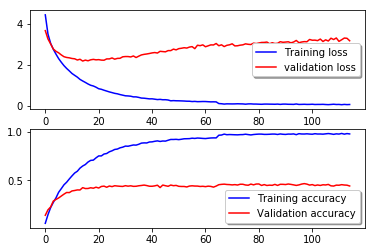

In [161]:
#Retrieve some information best train accuracy, validation accuracy, train loss and validation loss

index_acc = np.argmax(inception_history.history["acc"])
acc = inception_history.history["acc"][index_acc]
index_val_acc = np.argmax(inception_history.history["val_acc"])
val_acc = inception_history.history["val_acc"][index_val_acc]

index_loss = np.argmin(inception_history.history["loss"])
losses = inception_history.history["loss"][index_loss]
index_val_loss = np.argmin(inception_history.history["val_loss"])
val_losses = inception_history.history["val_loss"][index_val_loss]

acc_saved = inception_history.history["acc"][index_val_loss]
val_acc_saved = inception_history.history["val_acc"][index_val_loss]
train_loss_saved = losses = inception_history.history["loss"][index_val_loss]

print("best train accuracy {} on epoch {} ".format(acc, index_acc+1))
print("best validation accuracy {} on epoch {} ".format(val_acc, index_val_acc+1))
print("lowest train loss {} on epoch {} ".format(losses, index_loss+1))
print("lowest validation loss {} on epoch {} ".format(val_losses, index_val_loss+1))
print("saved accuracy : {}, val accuracy : {}, and train loss {} : ".format(acc_saved, val_acc_saved, train_loss_saved))

# Plot the loss and accuracy curves for training and validation on InceptionV3
fig, ax = plt.subplots(2,1)
ax[0].plot(inception_history.history['loss'], color='b', label="Training loss")
ax[0].plot(inception_history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(inception_history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(inception_history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## Xception

best train accuracy 0.9968074656188605 on epoch 68 
best validation accuracy 0.5021766169154229 on epoch 71 
lowest train loss 0.698852581804534 on epoch 112 
lowest validation loss 2.1082821212597747 on epoch 14 
saved accuracy : 0.8115176817288802, val accuracy : 0.4651741293532338, and train loss 0.698852581804534 : 


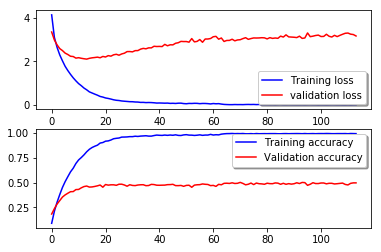

In [160]:
#Retrieve some information best train accuracy, validation accuracy, train loss and validation loss

index_acc = np.argmax(xception_history.history["acc"])
acc = xception_history.history["acc"][index_acc]
index_val_acc = np.argmax(xception_history.history["val_acc"])
val_acc = xception_history.history["val_acc"][index_val_acc]

index_loss = np.argmin(xception_history.history["loss"])
losses = xception_history.history["loss"][index_loss]
index_val_loss = np.argmin(xception_history.history["val_loss"])
val_losses = xception_history.history["val_loss"][index_val_loss]

acc_saved = xception_history.history["acc"][index_val_loss]
val_acc_saved = xception_history.history["val_acc"][index_val_loss]
train_loss_saved = losses = xception_history.history["loss"][index_val_loss]

print("best train accuracy {} on epoch {} ".format(acc, index_acc+1))
print("best validation accuracy {} on epoch {} ".format(val_acc, index_val_acc+1))
print("lowest train loss {} on epoch {} ".format(losses, index_loss+1))
print("lowest validation loss {} on epoch {} ".format(val_losses, index_val_loss+1))
print("saved accuracy : {}, val accuracy : {}, and train loss {} : ".format(acc_saved, val_acc_saved, train_loss_saved))

#Plot the loss and accuracy curves for training and validation on xception model
fig, ax = plt.subplots(2,1)
ax[0].plot(xception_history.history['loss'], color='b', label="Training loss")
ax[0].plot(xception_history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(xception_history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(xception_history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## Resnet50

best train accuracy 0.9942288801571709 on epoch 117 
best validation accuracy 0.5839552238805971 on epoch 93 
lowest train loss 0.40485100439348953 on epoch 111 
lowest validation loss 1.7131285471702689 on epoch 18 
saved accuracy : 0.8886296660117878, val accuracy : 0.5572139303482587, and train loss 0.40485100439348953 : 


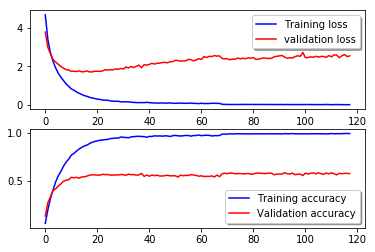

In [159]:
#Retrieve some information best train accuracy, validation accuracy, train loss and validation loss

index_acc = np.argmax(resnet_history.history["acc"])
acc = resnet_history.history["acc"][index_acc]
index_val_acc = np.argmax(resnet_history.history["val_acc"])
val_acc = resnet_history.history["val_acc"][index_val_acc]

index_loss = np.argmin(resnet_history.history["loss"])
losses = resnet_history.history["loss"][index_loss]
index_val_loss = np.argmin(resnet_history.history["val_loss"])
val_losses = resnet_history.history["val_loss"][index_val_loss]

acc_saved = resnet_history.history["acc"][index_val_loss]
val_acc_saved = resnet_history.history["val_acc"][index_val_loss]
train_loss_saved = losses = resnet_history.history["loss"][index_val_loss]

print("best train accuracy {} on epoch {} ".format(acc, index_acc+1))
print("best validation accuracy {} on epoch {} ".format(val_acc, index_val_acc+1))
print("lowest train loss {} on epoch {} ".format(losses, index_loss+1))
print("lowest validation loss {} on epoch {} ".format(val_losses, index_val_loss+1))
print("saved accuracy : {}, val accuracy : {}, and train loss {} : ".format(acc_saved, val_acc_saved, train_loss_saved))

# Plot the loss and accuracy curves for training and validation on resnet model
fig, ax = plt.subplots(2,1)
ax[0].plot(resnet_history.history['loss'], color='b', label="Training loss")
ax[0].plot(resnet_history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(resnet_history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(resnet_history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## VGG19

best train accuracy 0.9896856581532416 on epoch 100 
best validation accuracy 0.5171019900497512 on epoch 100 
lowest train loss 0.8825478696635758 on epoch 100 
lowest validation loss 2.108749953075428 on epoch 9 
saved accuracy : 0.7348968565815324, val accuracy : 0.4773009950248756, and train loss 0.8825478696635758 : 


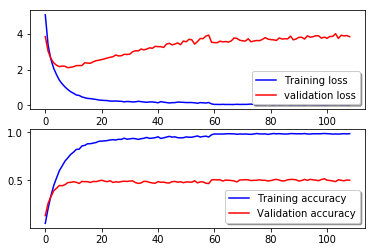

In [158]:
#Retrieve some information best train accuracy, validation accuracy, train loss and validation loss

index_acc = np.argmax(vgg_history.history["acc"])
acc = vgg_history.history["acc"][index_acc]
index_val_acc = np.argmax(vgg_history.history["val_acc"])
val_acc = vgg_history.history["val_acc"][index_val_acc]

index_loss = np.argmin(vgg_history.history["loss"])
losses = vgg_history.history["loss"][index_loss]
index_val_loss = np.argmin(vgg_history.history["val_loss"])
val_losses = vgg_history.history["val_loss"][index_val_loss]

acc_saved = vgg_history.history["acc"][index_val_loss]
val_acc_saved = vgg_history.history["val_acc"][index_val_loss]
train_loss_saved = losses = vgg_history.history["loss"][index_val_loss]

print("best train accuracy {} on epoch {} ".format(acc, index_acc+1))
print("best validation accuracy {} on epoch {} ".format(val_acc, index_val_acc+1))
print("lowest train loss {} on epoch {} ".format(losses, index_loss+1))
print("lowest validation loss {} on epoch {} ".format(val_losses, index_val_loss+1))
print("saved accuracy : {}, val accuracy : {}, and train loss {} : ".format(acc_saved, val_acc_saved, train_loss_saved))

# Plot the loss and accuracy curves for training and validation on vgg model
fig, ax = plt.subplots(2,1)
ax[0].plot(vgg_history.history['loss'], color='b', label="Training loss")
ax[0].plot(vgg_history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(vgg_history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(vgg_history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## InceptionResnet_V2

best train accuracy 0.9652504911591355 on epoch 124 
best validation accuracy 0.4987562189054726 on epoch 107 
lowest train loss 1.0177198420104905 on epoch 125 
lowest validation loss 2.2084811860649145 on epoch 28 
saved accuracy : 0.6970776031434185, val accuracy : 0.4343905472636816, and train loss 1.0177198420104905 : 


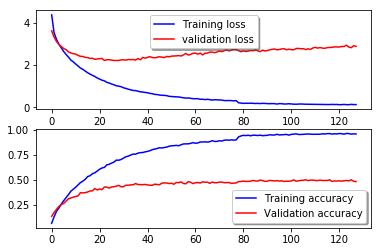

In [157]:
#Retrieve some information best train accuracy, validation accuracy, train loss and validation loss

index_acc = np.argmax(inceptionresnet_history.history["acc"])
acc = inceptionresnet_history.history["acc"][index_acc]
index_val_acc = np.argmax(inceptionresnet_history.history["val_acc"])
val_acc = inceptionresnet_history.history["val_acc"][index_val_acc]

index_loss = np.argmin(inceptionresnet_history.history["loss"])
losses = inceptionresnet_history.history["loss"][index_loss]
index_val_loss = np.argmin(inceptionresnet_history.history["val_loss"])
val_losses = inceptionresnet_history.history["val_loss"][index_val_loss]

acc_saved = inceptionresnet_history.history["acc"][index_val_loss]
val_acc_saved = inceptionresnet_history.history["val_acc"][index_val_loss]
train_loss_saved = losses = inceptionresnet_history.history["loss"][index_val_loss]

print("best train accuracy {} on epoch {} ".format(acc, index_acc+1))
print("best validation accuracy {} on epoch {} ".format(val_acc, index_val_acc+1))
print("lowest train loss {} on epoch {} ".format(losses, index_loss+1))
print("lowest validation loss {} on epoch {} ".format(val_losses, index_val_loss+1))
print("saved accuracy : {}, val accuracy : {}, and train loss {} : ".format(acc_saved, val_acc_saved, train_loss_saved))

# Plot the loss and accuracy curves for training and validation on vgg model
fig, ax = plt.subplots(2,1)
ax[0].plot(inceptionresnet_history.history['loss'], color='b', label="Training loss")
ax[0].plot(inceptionresnet_history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(inceptionresnet_history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(inceptionresnet_history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# 3.4 Ensemble models

After fitting and eevaluating the models, now we ensemble all the models. 

### Load models with the highest accuracy results

In [128]:
from keras.models import load_model

inception_best = 'saved_models/inception.best.from_features.hdf5'
xception_best = 'saved_models/xception.best.from_features.hdf5'
resnet_best = 'saved_models/resnet.best.from_features.hdf5'
vgg_best = 'saved_models/vgg.best.from_features.hdf5'
inceptionresnet_best = 'saved_models/inceptionresnet.best.from_features.hdf5'

### Create Data sets for Ensemble model

In [129]:
incept = load_model(inception_best)
xcept = load_model(xception_best)
rest = load_model(resnet_best)
vg = load_model(vgg_best)
incres = load_model(inceptionresnet_best)

In [130]:
inc = incept.predict(inception_train_features, batch_size=32, verbose=1)
xce = xcept.predict(xception_train_features, batch_size=32, verbose=1)
res = rest.predict(resnet_train_features, batch_size=32, verbose=1)
vgg = vg.predict(vgg_train_features, batch_size=32, verbose=1)
incs = incres.predict(inceptionresnet_train_features, batch_size=32, verbose=1)


ensemble_train_features = np.concatenate((inc,xce,res,vgg,incs), axis = 1)

8144/8144 [==============================] - ETA: 1:05:1 - ETA: 16:11  - ETA: 9:1 - ETA: 6: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 56 - ETA: 52 - ETA: 49 - ETA: 46 - ETA: 44 - ETA: 41 - ETA: 39 - ETA: 37 - ETA: 35 - ETA: 34 - ETA: 32 - ETA: 30 - ETA: 29 - ETA: 28 - ETA: 26 - ETA: 25 - ETA: 24 - ETA: 23 - ETA: 22 - ETA: 21 - ETA: 20 - ETA: 19 - ETA: 18 - ETA: 17 - ETA: 17 - ETA: 16 - ETA: 15 - ETA: 15 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 20s 2ms/step


In [131]:
inc = incept.predict(inception_test_features, batch_size=32, verbose=1)
xce = xcept.predict(xception_test_features, batch_size=32, verbose=1)
res = rest.predict(resnet_test_features, batch_size=32, verbose=1)
vgg = vg.predict(vgg_test_features, batch_size=32, verbose=1)
incs = incres.predict(inceptionresnet_test_features, batch_size=32, verbose=1)


ensemble_test_features = np.concatenate((inc,xce,res,vgg,incs), axis = 1)

8041/8041 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 5s 606us/step


In [132]:
ensemble_valid_x, ensemble_test_x, ensemble_valid_y, ensemble_test_y = train_test_split(ensemble_test_features, y_test, test_size=0.6, random_state=99)

## If you want to test the ensemble model, skip this training part and move to Section 4

In [136]:
ensemble_model = Sequential()
ensemble_model.add(Dense(1024, activation='relu', input_shape= ensemble_train_x.shape[1:]))
ensemble_model.add(Dropout(0.5))
ensemble_model.add(Dense(512, activation='relu'))
ensemble_model.add(Dropout(0.2))
ensemble_model.add(Dense(n_class, activation='softmax'))

ensemble_model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'],
           )

ensemble_model.summary()

ensemble_callbacks=[TQDMNotebookCallback(),
                     reduce_lr,
                      ModelCheckpoint(filepath='saved_models/ensemble.best.from_features.hdf5', 
                               verbose=1, save_best_only=True),
                     early_stopping
                     ]

ensemble_history = ensemble_model.fit(ensemble_train_features, y_train, 
                        validation_data=(ensemble_valid_x, ensemble_valid_y),
                        epochs=1000, 
                        callbacks=ensemble_callbacks,
                        class_weight=class_weights,
                        batch_size=32, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 1024)              1004544   
_________________________________________________________________
dropout_22 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_41 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_23 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 196)               100548    
Total params: 1,629,892
Trainable params: 1,629,892
Non-trainable params: 0
_________________________________________________________________
Train on 8144 samples, validate on 3216 samples


Epoch 1/1000


8144/8144 [==============================] - ETA: 2:30:19 - loss: 5.2377 - acc: 0.0000e+ - ETA: 49:47 - loss: 5.2557 - acc: 0.0104     - ETA: 29:41 - loss: 5.2801 - acc: 0.02 - ETA: 21:04 - loss: 5.2775 - acc: 0.05 - ETA: 16:16 - loss: 5.2603 - acc: 0.05 - ETA: 13:13 - loss: 5.2402 - acc: 0.05 - ETA: 11:07 - loss: 5.2255 - acc: 0.06 - ETA: 9:34 - loss: 5.2340 - acc: 0.0688 - ETA: 7:53 - loss: 5.2325 - acc: 0.081 - ETA: 7:03 - loss: 5.2337 - acc: 0.084 - ETA: 6:22 - loss: 5.2194 - acc: 0.096 - ETA: 5:32 - loss: 5.1833 - acc: 0.117 - ETA: 5:05 - loss: 5.1651 - acc: 0.133 - ETA: 4:42 - loss: 5.1457 - acc: 0.146 - ETA: 4:22 - loss: 5.1248 - acc: 0.165 - ETA: 4:04 - loss: 5.1040 - acc: 0.175 - ETA: 3:49 - loss: 5.0765 - acc: 0.188 - ETA: 3:35 - loss: 5.0542 - acc: 0.200 - ETA: 3:22 - loss: 5.0281 - acc: 0.214 - ETA: 3:11 - loss: 5.0007 - acc: 0.230 - ETA: 3:00 - loss: 4.9720 - acc: 0.246 - ETA: 2:51 - loss: 4.9392 - acc: 0.259 - ETA: 2:42 - loss: 4.9107 - acc: 0.267 - ETA: 2:34 - loss: 4.87

8144/8144 [==============================] - ETA: 11s - loss: 0.0680 - acc: 0.96 - ETA: 8s - loss: 0.0567 - acc: 0.9896 - ETA: 8s - loss: 0.0623 - acc: 0.987 - ETA: 7s - loss: 0.0594 - acc: 0.991 - ETA: 7s - loss: 0.0564 - acc: 0.993 - ETA: 7s - loss: 0.0554 - acc: 0.991 - ETA: 7s - loss: 0.0573 - acc: 0.990 - ETA: 7s - loss: 0.0542 - acc: 0.991 - ETA: 7s - loss: 0.0502 - acc: 0.992 - ETA: 7s - loss: 0.0493 - acc: 0.993 - ETA: 7s - loss: 0.0499 - acc: 0.992 - ETA: 7s - loss: 0.0499 - acc: 0.993 - ETA: 7s - loss: 0.0490 - acc: 0.992 - ETA: 6s - loss: 0.0500 - acc: 0.993 - ETA: 6s - loss: 0.0480 - acc: 0.993 - ETA: 6s - loss: 0.0467 - acc: 0.994 - ETA: 6s - loss: 0.0465 - acc: 0.993 - ETA: 6s - loss: 0.0460 - acc: 0.993 - ETA: 6s - loss: 0.0467 - acc: 0.993 - ETA: 6s - loss: 0.0455 - acc: 0.993 - ETA: 6s - loss: 0.0446 - acc: 0.993 - ETA: 6s - loss: 0.0442 - acc: 0.993 - ETA: 6s - loss: 0.0431 - acc: 0.993 - ETA: 6s - loss: 0.0438 - acc: 0.993 - ETA: 6s - loss: 0.0461 - acc: 0.993 - ETA:

8144/8144 [==============================] - ETA: 10s - loss: 0.0346 - acc: 1.00 - ETA: 8s - loss: 0.0342 - acc: 1.0000 - ETA: 7s - loss: 0.0661 - acc: 0.993 - ETA: 7s - loss: 0.0543 - acc: 0.995 - ETA: 6s - loss: 0.0474 - acc: 0.996 - ETA: 6s - loss: 0.0389 - acc: 0.997 - ETA: 6s - loss: 0.0351 - acc: 0.997 - ETA: 6s - loss: 0.0348 - acc: 0.996 - ETA: 6s - loss: 0.0315 - acc: 0.996 - ETA: 6s - loss: 0.0304 - acc: 0.996 - ETA: 6s - loss: 0.0287 - acc: 0.997 - ETA: 6s - loss: 0.0288 - acc: 0.997 - ETA: 6s - loss: 0.0284 - acc: 0.997 - ETA: 6s - loss: 0.0276 - acc: 0.997 - ETA: 6s - loss: 0.0266 - acc: 0.997 - ETA: 6s - loss: 0.0268 - acc: 0.997 - ETA: 6s - loss: 0.0256 - acc: 0.997 - ETA: 5s - loss: 0.0276 - acc: 0.995 - ETA: 5s - loss: 0.0270 - acc: 0.995 - ETA: 5s - loss: 0.0286 - acc: 0.995 - ETA: 5s - loss: 0.0278 - acc: 0.995 - ETA: 5s - loss: 0.0264 - acc: 0.995 - ETA: 5s - loss: 0.0258 - acc: 0.996 - ETA: 5s - loss: 0.0252 - acc: 0.996 - ETA: 5s - loss: 0.0299 - acc: 0.995 - ETA:

8144/8144 [==============================] - ETA: 11s - loss: 0.0148 - acc: 1.00 - ETA: 8s - loss: 0.0091 - acc: 1.0000 - ETA: 8s - loss: 0.0089 - acc: 1.000 - ETA: 8s - loss: 0.0123 - acc: 1.000 - ETA: 8s - loss: 0.0106 - acc: 1.000 - ETA: 7s - loss: 0.0148 - acc: 0.997 - ETA: 7s - loss: 0.0128 - acc: 0.997 - ETA: 7s - loss: 0.0118 - acc: 0.997 - ETA: 7s - loss: 0.0106 - acc: 0.998 - ETA: 7s - loss: 0.0098 - acc: 0.998 - ETA: 7s - loss: 0.0133 - acc: 0.995 - ETA: 7s - loss: 0.0141 - acc: 0.995 - ETA: 7s - loss: 0.0139 - acc: 0.996 - ETA: 6s - loss: 0.0137 - acc: 0.996 - ETA: 6s - loss: 0.0134 - acc: 0.996 - ETA: 6s - loss: 0.0131 - acc: 0.997 - ETA: 6s - loss: 0.0127 - acc: 0.997 - ETA: 6s - loss: 0.0123 - acc: 0.997 - ETA: 6s - loss: 0.0129 - acc: 0.997 - ETA: 6s - loss: 0.0178 - acc: 0.996 - ETA: 6s - loss: 0.0211 - acc: 0.996 - ETA: 6s - loss: 0.0205 - acc: 0.996 - ETA: 6s - loss: 0.0198 - acc: 0.996 - ETA: 6s - loss: 0.0203 - acc: 0.996 - ETA: 6s - loss: 0.0207 - acc: 0.995 - ETA:

8144/8144 [==============================] - ETA: 10s - loss: 0.0052 - acc: 1.00 - ETA: 8s - loss: 0.0045 - acc: 1.0000 - ETA: 8s - loss: 0.0057 - acc: 1.000 - ETA: 8s - loss: 0.0083 - acc: 1.000 - ETA: 7s - loss: 0.0108 - acc: 0.996 - ETA: 7s - loss: 0.0246 - acc: 0.994 - ETA: 7s - loss: 0.0217 - acc: 0.995 - ETA: 7s - loss: 0.0199 - acc: 0.996 - ETA: 7s - loss: 0.0205 - acc: 0.994 - ETA: 7s - loss: 0.0250 - acc: 0.993 - ETA: 6s - loss: 0.0230 - acc: 0.994 - ETA: 6s - loss: 0.0218 - acc: 0.994 - ETA: 6s - loss: 0.0204 - acc: 0.995 - ETA: 6s - loss: 0.0278 - acc: 0.994 - ETA: 6s - loss: 0.0293 - acc: 0.993 - ETA: 6s - loss: 0.0290 - acc: 0.994 - ETA: 6s - loss: 0.0274 - acc: 0.994 - ETA: 6s - loss: 0.0260 - acc: 0.994 - ETA: 6s - loss: 0.0432 - acc: 0.993 - ETA: 6s - loss: 0.0447 - acc: 0.993 - ETA: 6s - loss: 0.0433 - acc: 0.993 - ETA: 6s - loss: 0.0414 - acc: 0.993 - ETA: 6s - loss: 0.0400 - acc: 0.993 - ETA: 6s - loss: 0.0389 - acc: 0.994 - ETA: 6s - loss: 0.0375 - acc: 0.994 - ETA:

8144/8144 [==============================] - ETA: 11s - loss: 7.0012e-04 - acc: 1.00 - ETA: 8s - loss: 0.0435 - acc: 0.9896     - ETA: 7s - loss: 0.0265 - acc: 0.993 - ETA: 7s - loss: 0.0198 - acc: 0.995 - ETA: 7s - loss: 0.0161 - acc: 0.996 - ETA: 7s - loss: 0.0137 - acc: 0.997 - ETA: 7s - loss: 0.0118 - acc: 0.997 - ETA: 6s - loss: 0.0105 - acc: 0.997 - ETA: 6s - loss: 0.0099 - acc: 0.998 - ETA: 6s - loss: 0.0092 - acc: 0.998 - ETA: 6s - loss: 0.0092 - acc: 0.998 - ETA: 6s - loss: 0.0139 - acc: 0.997 - ETA: 6s - loss: 0.0130 - acc: 0.997 - ETA: 6s - loss: 0.0123 - acc: 0.997 - ETA: 6s - loss: 0.0117 - acc: 0.997 - ETA: 5s - loss: 0.0112 - acc: 0.998 - ETA: 5s - loss: 0.0112 - acc: 0.998 - ETA: 5s - loss: 0.0111 - acc: 0.998 - ETA: 5s - loss: 0.0159 - acc: 0.997 - ETA: 5s - loss: 0.0153 - acc: 0.997 - ETA: 5s - loss: 0.0156 - acc: 0.997 - ETA: 5s - loss: 0.0169 - acc: 0.996 - ETA: 5s - loss: 0.0162 - acc: 0.996 - ETA: 5s - loss: 0.0158 - acc: 0.996 - ETA: 5s - loss: 0.0153 - acc: 0.99

8144/8144 [==============================] - ETA: 11s - loss: 0.0030 - acc: 1.00 - ETA: 8s - loss: 0.0389 - acc: 0.9792 - ETA: 8s - loss: 0.0305 - acc: 0.981 - ETA: 7s - loss: 0.0219 - acc: 0.986 - ETA: 7s - loss: 0.0194 - acc: 0.989 - ETA: 7s - loss: 0.0276 - acc: 0.988 - ETA: 7s - loss: 0.0238 - acc: 0.990 - ETA: 7s - loss: 0.0258 - acc: 0.989 - ETA: 6s - loss: 0.0229 - acc: 0.990 - ETA: 6s - loss: 0.0207 - acc: 0.991 - ETA: 6s - loss: 0.0195 - acc: 0.992 - ETA: 6s - loss: 0.0180 - acc: 0.993 - ETA: 6s - loss: 0.0172 - acc: 0.993 - ETA: 6s - loss: 0.0160 - acc: 0.994 - ETA: 6s - loss: 0.0151 - acc: 0.994 - ETA: 6s - loss: 0.0142 - acc: 0.995 - ETA: 6s - loss: 0.0135 - acc: 0.995 - ETA: 6s - loss: 0.0125 - acc: 0.995 - ETA: 5s - loss: 0.0119 - acc: 0.995 - ETA: 5s - loss: 0.0116 - acc: 0.996 - ETA: 5s - loss: 0.0133 - acc: 0.995 - ETA: 5s - loss: 0.0127 - acc: 0.995 - ETA: 5s - loss: 0.0122 - acc: 0.995 - ETA: 5s - loss: 0.0118 - acc: 0.996 - ETA: 5s - loss: 0.0116 - acc: 0.996 - ETA:

8144/8144 [==============================] - ETA: 10s - loss: 0.0024 - acc: 1.00 - ETA: 8s - loss: 0.0015 - acc: 1.0000 - ETA: 7s - loss: 0.0468 - acc: 0.993 - ETA: 7s - loss: 0.0382 - acc: 0.991 - ETA: 7s - loss: 0.0307 - acc: 0.993 - ETA: 6s - loss: 0.0257 - acc: 0.992 - ETA: 6s - loss: 0.0239 - acc: 0.991 - ETA: 6s - loss: 0.0213 - acc: 0.992 - ETA: 6s - loss: 0.0191 - acc: 0.993 - ETA: 6s - loss: 0.0176 - acc: 0.993 - ETA: 6s - loss: 0.0178 - acc: 0.992 - ETA: 6s - loss: 0.0294 - acc: 0.990 - ETA: 6s - loss: 0.0365 - acc: 0.989 - ETA: 6s - loss: 0.0345 - acc: 0.990 - ETA: 5s - loss: 0.0324 - acc: 0.990 - ETA: 5s - loss: 0.0305 - acc: 0.991 - ETA: 5s - loss: 0.0292 - acc: 0.992 - ETA: 5s - loss: 0.0278 - acc: 0.992 - ETA: 5s - loss: 0.0272 - acc: 0.992 - ETA: 5s - loss: 0.0260 - acc: 0.992 - ETA: 5s - loss: 0.0248 - acc: 0.992 - ETA: 5s - loss: 0.0238 - acc: 0.993 - ETA: 5s - loss: 0.0228 - acc: 0.993 - ETA: 5s - loss: 0.0219 - acc: 0.993 - ETA: 5s - loss: 0.0212 - acc: 0.993 - ETA:

8144/8144 [==============================] - ETA: 10s - loss: 0.0022 - acc: 1.00 - ETA: 8s - loss: 0.0011 - acc: 1.0000 - ETA: 8s - loss: 0.0013 - acc: 1.000 - ETA: 7s - loss: 0.0012 - acc: 1.000 - ETA: 7s - loss: 0.0017 - acc: 1.000 - ETA: 7s - loss: 0.0192 - acc: 0.997 - ETA: 7s - loss: 0.0166 - acc: 0.997 - ETA: 7s - loss: 0.0145 - acc: 0.997 - ETA: 7s - loss: 0.0132 - acc: 0.998 - ETA: 7s - loss: 0.0133 - acc: 0.996 - ETA: 7s - loss: 0.0121 - acc: 0.997 - ETA: 7s - loss: 0.0112 - acc: 0.997 - ETA: 7s - loss: 0.0104 - acc: 0.997 - ETA: 6s - loss: 0.0098 - acc: 0.997 - ETA: 6s - loss: 0.0092 - acc: 0.997 - ETA: 6s - loss: 0.0087 - acc: 0.998 - ETA: 6s - loss: 0.0141 - acc: 0.997 - ETA: 6s - loss: 0.0133 - acc: 0.997 - ETA: 6s - loss: 0.0126 - acc: 0.997 - ETA: 6s - loss: 0.0152 - acc: 0.996 - ETA: 6s - loss: 0.0145 - acc: 0.997 - ETA: 6s - loss: 0.0138 - acc: 0.997 - ETA: 6s - loss: 0.0133 - acc: 0.997 - ETA: 6s - loss: 0.0127 - acc: 0.997 - ETA: 6s - loss: 0.0124 - acc: 0.997 - ETA:

8144/8144 [==============================] - ETA: 10s - loss: 8.1131e-04 - acc: 1.00 - ETA: 8s - loss: 0.0019 - acc: 1.0000     - ETA: 7s - loss: 0.0014 - acc: 1.000 - ETA: 7s - loss: 0.0016 - acc: 1.000 - ETA: 7s - loss: 0.0013 - acc: 1.000 - ETA: 7s - loss: 0.0013 - acc: 1.000 - ETA: 6s - loss: 0.0011 - acc: 1.000 - ETA: 6s - loss: 0.0013 - acc: 1.000 - ETA: 6s - loss: 0.0012 - acc: 1.000 - ETA: 6s - loss: 0.0011 - acc: 1.000 - ETA: 6s - loss: 0.0013 - acc: 1.000 - ETA: 6s - loss: 0.0013 - acc: 1.000 - ETA: 6s - loss: 0.0022 - acc: 1.000 - ETA: 6s - loss: 0.0021 - acc: 1.000 - ETA: 6s - loss: 0.0022 - acc: 1.000 - ETA: 6s - loss: 0.0021 - acc: 1.000 - ETA: 6s - loss: 0.0024 - acc: 1.000 - ETA: 5s - loss: 0.0024 - acc: 1.000 - ETA: 5s - loss: 0.0023 - acc: 1.000 - ETA: 5s - loss: 0.0022 - acc: 1.000 - ETA: 5s - loss: 0.0021 - acc: 1.000 - ETA: 5s - loss: 0.0021 - acc: 1.000 - ETA: 5s - loss: 0.0029 - acc: 0.999 - ETA: 5s - loss: 0.0028 - acc: 0.999 - ETA: 5s - loss: 0.0027 - acc: 0.99

8144/8144 [==============================] - ETA: 11s - loss: 2.8240e-04 - acc: 1.00 - ETA: 8s - loss: 0.0088 - acc: 1.0000     - ETA: 8s - loss: 0.0055 - acc: 1.000 - ETA: 7s - loss: 0.0120 - acc: 0.995 - ETA: 7s - loss: 0.0224 - acc: 0.993 - ETA: 6s - loss: 0.0176 - acc: 0.994 - ETA: 6s - loss: 0.0151 - acc: 0.995 - ETA: 6s - loss: 0.0133 - acc: 0.996 - ETA: 6s - loss: 0.0114 - acc: 0.996 - ETA: 6s - loss: 0.0104 - acc: 0.997 - ETA: 6s - loss: 0.0095 - acc: 0.997 - ETA: 6s - loss: 0.0088 - acc: 0.997 - ETA: 6s - loss: 0.0159 - acc: 0.996 - ETA: 6s - loss: 0.0148 - acc: 0.996 - ETA: 6s - loss: 0.0171 - acc: 0.996 - ETA: 6s - loss: 0.0161 - acc: 0.996 - ETA: 5s - loss: 0.0152 - acc: 0.996 - ETA: 5s - loss: 0.0145 - acc: 0.996 - ETA: 5s - loss: 0.0137 - acc: 0.996 - ETA: 5s - loss: 0.0131 - acc: 0.997 - ETA: 5s - loss: 0.0125 - acc: 0.997 - ETA: 5s - loss: 0.0119 - acc: 0.997 - ETA: 5s - loss: 0.0114 - acc: 0.997 - ETA: 5s - loss: 0.0116 - acc: 0.996 - ETA: 5s - loss: 0.0113 - acc: 0.99

8144/8144 [==============================] - ETA: 11s - loss: 7.7071e-04 - acc: 1.00 - ETA: 8s - loss: 7.7292e-04 - acc: 1.0000 - ETA: 7s - loss: 0.0146 - acc: 0.9938    - ETA: 7s - loss: 0.0115 - acc: 0.995 - ETA: 7s - loss: 0.0102 - acc: 0.996 - ETA: 6s - loss: 0.0078 - acc: 0.997 - ETA: 6s - loss: 0.0069 - acc: 0.997 - ETA: 6s - loss: 0.0080 - acc: 0.996 - ETA: 6s - loss: 0.0220 - acc: 0.994 - ETA: 6s - loss: 0.0199 - acc: 0.995 - ETA: 6s - loss: 0.0189 - acc: 0.995 - ETA: 6s - loss: 0.0176 - acc: 0.996 - ETA: 6s - loss: 0.0175 - acc: 0.995 - ETA: 6s - loss: 0.0163 - acc: 0.995 - ETA: 6s - loss: 0.0152 - acc: 0.995 - ETA: 6s - loss: 0.0143 - acc: 0.996 - ETA: 6s - loss: 0.0135 - acc: 0.996 - ETA: 6s - loss: 0.0128 - acc: 0.996 - ETA: 5s - loss: 0.0121 - acc: 0.996 - ETA: 5s - loss: 0.0135 - acc: 0.996 - ETA: 5s - loss: 0.0129 - acc: 0.996 - ETA: 5s - loss: 0.0124 - acc: 0.996 - ETA: 5s - loss: 0.0120 - acc: 0.996 - ETA: 5s - loss: 0.0115 - acc: 0.996 - ETA: 5s - loss: 0.0114 - acc: 

8144/8144 [==============================] - ETA: 11s - loss: 0.0042 - acc: 1.00 - ETA: 8s - loss: 0.0023 - acc: 1.0000 - ETA: 8s - loss: 0.0028 - acc: 1.000 - ETA: 7s - loss: 0.0021 - acc: 1.000 - ETA: 7s - loss: 0.0017 - acc: 1.000 - ETA: 7s - loss: 0.0015 - acc: 1.000 - ETA: 7s - loss: 0.0087 - acc: 0.997 - ETA: 7s - loss: 0.0077 - acc: 0.997 - ETA: 7s - loss: 0.0069 - acc: 0.998 - ETA: 7s - loss: 0.0063 - acc: 0.998 - ETA: 6s - loss: 0.0058 - acc: 0.998 - ETA: 6s - loss: 0.0054 - acc: 0.998 - ETA: 6s - loss: 0.0103 - acc: 0.997 - ETA: 6s - loss: 0.0100 - acc: 0.997 - ETA: 6s - loss: 0.0094 - acc: 0.997 - ETA: 6s - loss: 0.0088 - acc: 0.998 - ETA: 6s - loss: 0.0088 - acc: 0.998 - ETA: 6s - loss: 0.0083 - acc: 0.998 - ETA: 6s - loss: 0.0079 - acc: 0.998 - ETA: 6s - loss: 0.0075 - acc: 0.998 - ETA: 6s - loss: 0.0072 - acc: 0.998 - ETA: 6s - loss: 0.0107 - acc: 0.997 - ETA: 6s - loss: 0.0103 - acc: 0.997 - ETA: 6s - loss: 0.0098 - acc: 0.998 - ETA: 6s - loss: 0.0095 - acc: 0.998 - ETA:

8144/8144 [==============================] - ETA: 11s - loss: 4.9666e-04 - acc: 1.00 - ETA: 8s - loss: 0.0077 - acc: 1.0000     - ETA: 7s - loss: 0.0048 - acc: 1.000 - ETA: 7s - loss: 0.0487 - acc: 0.995 - ETA: 7s - loss: 0.0380 - acc: 0.996 - ETA: 6s - loss: 0.0291 - acc: 0.997 - ETA: 6s - loss: 0.0250 - acc: 0.997 - ETA: 6s - loss: 0.0219 - acc: 0.998 - ETA: 6s - loss: 0.0196 - acc: 0.998 - ETA: 6s - loss: 0.0178 - acc: 0.998 - ETA: 6s - loss: 0.0169 - acc: 0.998 - ETA: 6s - loss: 0.0155 - acc: 0.998 - ETA: 6s - loss: 0.0175 - acc: 0.997 - ETA: 6s - loss: 0.0163 - acc: 0.997 - ETA: 6s - loss: 0.0153 - acc: 0.997 - ETA: 6s - loss: 0.0144 - acc: 0.998 - ETA: 5s - loss: 0.0136 - acc: 0.998 - ETA: 5s - loss: 0.0129 - acc: 0.998 - ETA: 5s - loss: 0.0122 - acc: 0.998 - ETA: 5s - loss: 0.0117 - acc: 0.998 - ETA: 5s - loss: 0.0113 - acc: 0.998 - ETA: 5s - loss: 0.0113 - acc: 0.997 - ETA: 5s - loss: 0.0110 - acc: 0.998 - ETA: 5s - loss: 0.0106 - acc: 0.998 - ETA: 5s - loss: 0.0104 - acc: 0.99

8144/8144 [==============================] - ETA: 10s - loss: 0.0350 - acc: 0.96 - ETA: 8s - loss: 0.0125 - acc: 0.9896 - ETA: 8s - loss: 0.0369 - acc: 0.987 - ETA: 7s - loss: 0.0265 - acc: 0.991 - ETA: 7s - loss: 0.0208 - acc: 0.993 - ETA: 6s - loss: 0.0213 - acc: 0.992 - ETA: 6s - loss: 0.0183 - acc: 0.993 - ETA: 6s - loss: 0.0166 - acc: 0.994 - ETA: 6s - loss: 0.0191 - acc: 0.993 - ETA: 6s - loss: 0.0173 - acc: 0.994 - ETA: 6s - loss: 0.0208 - acc: 0.993 - ETA: 6s - loss: 0.0211 - acc: 0.992 - ETA: 6s - loss: 0.0196 - acc: 0.993 - ETA: 6s - loss: 0.0184 - acc: 0.993 - ETA: 6s - loss: 0.0233 - acc: 0.993 - ETA: 6s - loss: 0.0220 - acc: 0.993 - ETA: 5s - loss: 0.0209 - acc: 0.993 - ETA: 5s - loss: 0.0199 - acc: 0.994 - ETA: 5s - loss: 0.0185 - acc: 0.994 - ETA: 5s - loss: 0.0177 - acc: 0.994 - ETA: 5s - loss: 0.0170 - acc: 0.995 - ETA: 5s - loss: 0.0216 - acc: 0.994 - ETA: 5s - loss: 0.0207 - acc: 0.994 - ETA: 5s - loss: 0.0199 - acc: 0.995 - ETA: 5s - loss: 0.0192 - acc: 0.995 - ETA:

8144/8144 [==============================] - ETA: 11s - loss: 1.7262e-04 - acc: 1.00 - ETA: 8s - loss: 3.5118e-04 - acc: 1.0000 - ETA: 7s - loss: 3.4619e-04 - acc: 1.000 - ETA: 7s - loss: 4.1695e-04 - acc: 1.000 - ETA: 7s - loss: 4.2342e-04 - acc: 1.000 - ETA: 6s - loss: 6.2198e-04 - acc: 1.000 - ETA: 6s - loss: 6.4392e-04 - acc: 1.000 - ETA: 6s - loss: 7.1088e-04 - acc: 1.000 - ETA: 6s - loss: 7.2598e-04 - acc: 1.000 - ETA: 6s - loss: 6.8624e-04 - acc: 1.000 - ETA: 6s - loss: 6.5335e-04 - acc: 1.000 - ETA: 6s - loss: 7.8199e-04 - acc: 1.000 - ETA: 6s - loss: 8.2379e-04 - acc: 1.000 - ETA: 6s - loss: 8.0435e-04 - acc: 1.000 - ETA: 6s - loss: 9.2341e-04 - acc: 1.000 - ETA: 6s - loss: 0.0013 - acc: 1.0000    - ETA: 5s - loss: 0.0052 - acc: 0.999 - ETA: 5s - loss: 0.0048 - acc: 0.999 - ETA: 5s - loss: 0.0050 - acc: 0.999 - ETA: 5s - loss: 0.0048 - acc: 0.999 - ETA: 5s - loss: 0.0046 - acc: 0.999 - ETA: 5s - loss: 0.0111 - acc: 0.998 - ETA: 5s - loss: 0.0117 - acc: 0.998 - ETA: 5s - loss: 

8144/8144 [==============================] - ETA: 11s - loss: 0.0052 - acc: 1.00 - ETA: 8s - loss: 0.0021 - acc: 1.0000 - ETA: 7s - loss: 0.0028 - acc: 1.000 - ETA: 7s - loss: 0.0022 - acc: 1.000 - ETA: 7s - loss: 0.0166 - acc: 0.996 - ETA: 6s - loss: 0.0139 - acc: 0.997 - ETA: 6s - loss: 0.0118 - acc: 0.997 - ETA: 6s - loss: 0.0104 - acc: 0.997 - ETA: 6s - loss: 0.0092 - acc: 0.998 - ETA: 6s - loss: 0.0084 - acc: 0.998 - ETA: 6s - loss: 0.0076 - acc: 0.998 - ETA: 6s - loss: 0.0071 - acc: 0.998 - ETA: 6s - loss: 0.0066 - acc: 0.998 - ETA: 6s - loss: 0.0063 - acc: 0.998 - ETA: 6s - loss: 0.0059 - acc: 0.998 - ETA: 6s - loss: 0.0058 - acc: 0.999 - ETA: 6s - loss: 0.0055 - acc: 0.999 - ETA: 5s - loss: 0.0052 - acc: 0.999 - ETA: 5s - loss: 0.0050 - acc: 0.999 - ETA: 5s - loss: 0.0052 - acc: 0.999 - ETA: 5s - loss: 0.0053 - acc: 0.999 - ETA: 5s - loss: 0.0049 - acc: 0.999 - ETA: 5s - loss: 0.0049 - acc: 0.999 - ETA: 5s - loss: 0.0047 - acc: 0.999 - ETA: 5s - loss: 0.0045 - acc: 0.999 - ETA:

8144/8144 [==============================] - ETA: 9s - loss: 1.2160e-04 - acc: 1.000 - ETA: 6s - loss: 0.0032 - acc: 1.0000    - ETA: 5s - loss: 0.0021 - acc: 1.000 - ETA: 5s - loss: 0.0022 - acc: 1.000 - ETA: 5s - loss: 0.0017 - acc: 1.000 - ETA: 5s - loss: 0.0016 - acc: 1.000 - ETA: 5s - loss: 0.0014 - acc: 1.000 - ETA: 5s - loss: 0.0081 - acc: 0.997 - ETA: 5s - loss: 0.0072 - acc: 0.997 - ETA: 5s - loss: 0.0068 - acc: 0.997 - ETA: 5s - loss: 0.0064 - acc: 0.997 - ETA: 5s - loss: 0.0061 - acc: 0.998 - ETA: 5s - loss: 0.0093 - acc: 0.997 - ETA: 5s - loss: 0.0086 - acc: 0.997 - ETA: 5s - loss: 0.0111 - acc: 0.996 - ETA: 4s - loss: 0.0164 - acc: 0.995 - ETA: 4s - loss: 0.0154 - acc: 0.995 - ETA: 4s - loss: 0.0145 - acc: 0.996 - ETA: 4s - loss: 0.0137 - acc: 0.996 - ETA: 4s - loss: 0.0138 - acc: 0.996 - ETA: 4s - loss: 0.0136 - acc: 0.996 - ETA: 4s - loss: 0.0132 - acc: 0.996 - ETA: 4s - loss: 0.0126 - acc: 0.996 - ETA: 4s - loss: 0.0129 - acc: 0.996 - ETA: 4s - loss: 0.0124 - acc: 0.996

8144/8144 [==============================] - ETA: 12s - loss: 2.8048e-04 - acc: 1.00 - ETA: 8s - loss: 0.0056 - acc: 1.0000     - ETA: 8s - loss: 0.0036 - acc: 1.000 - ETA: 7s - loss: 0.0026 - acc: 1.000 - ETA: 8s - loss: 0.0022 - acc: 1.000 - ETA: 7s - loss: 0.0064 - acc: 0.997 - ETA: 7s - loss: 0.0055 - acc: 0.997 - ETA: 7s - loss: 0.0054 - acc: 0.997 - ETA: 7s - loss: 0.0048 - acc: 0.998 - ETA: 7s - loss: 0.0043 - acc: 0.998 - ETA: 7s - loss: 0.0206 - acc: 0.997 - ETA: 7s - loss: 0.0339 - acc: 0.995 - ETA: 6s - loss: 0.0312 - acc: 0.996 - ETA: 6s - loss: 0.0289 - acc: 0.996 - ETA: 6s - loss: 0.0269 - acc: 0.996 - ETA: 6s - loss: 0.0252 - acc: 0.997 - ETA: 6s - loss: 0.0237 - acc: 0.997 - ETA: 6s - loss: 0.0224 - acc: 0.997 - ETA: 6s - loss: 0.0212 - acc: 0.997 - ETA: 6s - loss: 0.0203 - acc: 0.997 - ETA: 6s - loss: 0.0194 - acc: 0.997 - ETA: 6s - loss: 0.0185 - acc: 0.997 - ETA: 5s - loss: 0.0179 - acc: 0.997 - ETA: 5s - loss: 0.0172 - acc: 0.997 - ETA: 5s - loss: 0.0166 - acc: 0.99

8144/8144 [==============================] - ETA: 11s - loss: 2.3848e-04 - acc: 1.00 - ETA: 8s - loss: 2.4954e-04 - acc: 1.0000 - ETA: 7s - loss: 2.6413e-04 - acc: 1.000 - ETA: 7s - loss: 3.4960e-04 - acc: 1.000 - ETA: 7s - loss: 2.9588e-04 - acc: 1.000 - ETA: 6s - loss: 2.6209e-04 - acc: 1.000 - ETA: 6s - loss: 2.4267e-04 - acc: 1.000 - ETA: 6s - loss: 0.0015 - acc: 1.0000    - ETA: 6s - loss: 0.0037 - acc: 0.998 - ETA: 6s - loss: 0.0034 - acc: 0.998 - ETA: 6s - loss: 0.0031 - acc: 0.998 - ETA: 6s - loss: 0.0038 - acc: 0.998 - ETA: 6s - loss: 0.0035 - acc: 0.998 - ETA: 6s - loss: 0.0033 - acc: 0.998 - ETA: 6s - loss: 0.0031 - acc: 0.999 - ETA: 6s - loss: 0.0029 - acc: 0.999 - ETA: 6s - loss: 0.0028 - acc: 0.999 - ETA: 6s - loss: 0.0027 - acc: 0.999 - ETA: 5s - loss: 0.0026 - acc: 0.999 - ETA: 5s - loss: 0.0025 - acc: 0.999 - ETA: 5s - loss: 0.0024 - acc: 0.999 - ETA: 5s - loss: 0.0063 - acc: 0.998 - ETA: 5s - loss: 0.0063 - acc: 0.998 - ETA: 5s - loss: 0.0061 - acc: 0.998 - ETA: 5s - 

8144/8144 [==============================] - ETA: 13s - loss: 0.1836 - acc: 0.96 - ETA: 9s - loss: 0.0613 - acc: 0.9896 - ETA: 8s - loss: 0.0373 - acc: 0.993 - ETA: 8s - loss: 0.0321 - acc: 0.991 - ETA: 7s - loss: 0.0364 - acc: 0.989 - ETA: 7s - loss: 0.0341 - acc: 0.988 - ETA: 7s - loss: 0.0473 - acc: 0.988 - ETA: 7s - loss: 0.0411 - acc: 0.989 - ETA: 7s - loss: 0.0379 - acc: 0.990 - ETA: 6s - loss: 0.0340 - acc: 0.991 - ETA: 6s - loss: 0.0309 - acc: 0.992 - ETA: 6s - loss: 0.0285 - acc: 0.993 - ETA: 6s - loss: 0.0262 - acc: 0.993 - ETA: 6s - loss: 0.0243 - acc: 0.994 - ETA: 6s - loss: 0.0238 - acc: 0.993 - ETA: 6s - loss: 0.0216 - acc: 0.994 - ETA: 6s - loss: 0.0203 - acc: 0.994 - ETA: 6s - loss: 0.0192 - acc: 0.994 - ETA: 6s - loss: 0.0182 - acc: 0.995 - ETA: 6s - loss: 0.0173 - acc: 0.995 - ETA: 5s - loss: 0.0165 - acc: 0.995 - ETA: 5s - loss: 0.0160 - acc: 0.995 - ETA: 5s - loss: 0.0150 - acc: 0.996 - ETA: 5s - loss: 0.0144 - acc: 0.996 - ETA: 5s - loss: 0.0139 - acc: 0.996 - ETA:

8144/8144 [==============================] - ETA: 10s - loss: 6.4201e-04 - acc: 1.00 - ETA: 8s - loss: 6.0069e-04 - acc: 1.0000 - ETA: 7s - loss: 0.0016 - acc: 1.0000    - ETA: 7s - loss: 0.0012 - acc: 1.000 - ETA: 7s - loss: 0.0035 - acc: 1.000 - ETA: 6s - loss: 0.0027 - acc: 1.000 - ETA: 6s - loss: 0.0024 - acc: 1.000 - ETA: 6s - loss: 0.0022 - acc: 1.000 - ETA: 6s - loss: 0.0028 - acc: 1.000 - ETA: 6s - loss: 0.0026 - acc: 1.000 - ETA: 6s - loss: 0.0024 - acc: 1.000 - ETA: 6s - loss: 0.0022 - acc: 1.000 - ETA: 6s - loss: 0.0020 - acc: 1.000 - ETA: 6s - loss: 0.0020 - acc: 1.000 - ETA: 5s - loss: 0.0018 - acc: 1.000 - ETA: 5s - loss: 0.0018 - acc: 1.000 - ETA: 5s - loss: 0.0018 - acc: 1.000 - ETA: 5s - loss: 0.0017 - acc: 1.000 - ETA: 5s - loss: 0.0016 - acc: 1.000 - ETA: 5s - loss: 0.0015 - acc: 1.000 - ETA: 5s - loss: 0.0014 - acc: 1.000 - ETA: 5s - loss: 0.0014 - acc: 1.000 - ETA: 5s - loss: 0.0021 - acc: 0.999 - ETA: 5s - loss: 0.0021 - acc: 0.999 - ETA: 5s - loss: 0.0020 - acc: 

8144/8144 [==============================] - ETA: 10s - loss: 0.1244 - acc: 0.96 - ETA: 8s - loss: 0.0415 - acc: 0.9896 - ETA: 7s - loss: 0.0250 - acc: 0.993 - ETA: 7s - loss: 0.0179 - acc: 0.995 - ETA: 7s - loss: 0.0140 - acc: 0.996 - ETA: 6s - loss: 0.0106 - acc: 0.997 - ETA: 6s - loss: 0.0091 - acc: 0.997 - ETA: 6s - loss: 0.0080 - acc: 0.998 - ETA: 6s - loss: 0.0069 - acc: 0.998 - ETA: 6s - loss: 0.0063 - acc: 0.998 - ETA: 6s - loss: 0.0155 - acc: 0.997 - ETA: 6s - loss: 0.0143 - acc: 0.997 - ETA: 5s - loss: 0.0131 - acc: 0.997 - ETA: 5s - loss: 0.0122 - acc: 0.997 - ETA: 5s - loss: 0.0193 - acc: 0.997 - ETA: 5s - loss: 0.0189 - acc: 0.997 - ETA: 5s - loss: 0.0182 - acc: 0.997 - ETA: 5s - loss: 0.0172 - acc: 0.997 - ETA: 5s - loss: 0.0164 - acc: 0.997 - ETA: 5s - loss: 0.0156 - acc: 0.997 - ETA: 5s - loss: 0.0149 - acc: 0.997 - ETA: 5s - loss: 0.0143 - acc: 0.998 - ETA: 5s - loss: 0.0148 - acc: 0.997 - ETA: 5s - loss: 0.0143 - acc: 0.997 - ETA: 5s - loss: 0.0138 - acc: 0.997 - ETA:

8144/8144 [==============================] - ETA: 10s - loss: 0.0121 - acc: 1.00 - ETA: 8s - loss: 0.0049 - acc: 1.0000 - ETA: 8s - loss: 0.0031 - acc: 1.000 - ETA: 7s - loss: 0.0022 - acc: 1.000 - ETA: 7s - loss: 0.0017 - acc: 1.000 - ETA: 6s - loss: 0.0016 - acc: 1.000 - ETA: 6s - loss: 0.0014 - acc: 1.000 - ETA: 6s - loss: 0.0013 - acc: 1.000 - ETA: 6s - loss: 0.0013 - acc: 1.000 - ETA: 6s - loss: 0.0012 - acc: 1.000 - ETA: 6s - loss: 0.0013 - acc: 1.000 - ETA: 6s - loss: 0.0106 - acc: 0.998 - ETA: 6s - loss: 0.0095 - acc: 0.998 - ETA: 6s - loss: 0.0089 - acc: 0.999 - ETA: 5s - loss: 0.0084 - acc: 0.999 - ETA: 5s - loss: 0.0083 - acc: 0.999 - ETA: 5s - loss: 0.0081 - acc: 0.999 - ETA: 5s - loss: 0.0077 - acc: 0.999 - ETA: 5s - loss: 0.0094 - acc: 0.998 - ETA: 5s - loss: 0.0091 - acc: 0.998 - ETA: 5s - loss: 0.0088 - acc: 0.998 - ETA: 5s - loss: 0.0083 - acc: 0.998 - ETA: 5s - loss: 0.0080 - acc: 0.998 - ETA: 5s - loss: 0.0077 - acc: 0.998 - ETA: 5s - loss: 0.0074 - acc: 0.998 - ETA:

8144/8144 [==============================] - ETA: 11s - loss: 6.4833e-05 - acc: 1.00 - ETA: 8s - loss: 2.3121e-04 - acc: 1.0000 - ETA: 7s - loss: 3.1696e-04 - acc: 1.000 - ETA: 7s - loss: 4.9967e-04 - acc: 1.000 - ETA: 7s - loss: 4.3906e-04 - acc: 1.000 - ETA: 7s - loss: 3.9080e-04 - acc: 1.000 - ETA: 7s - loss: 4.1195e-04 - acc: 1.000 - ETA: 7s - loss: 4.0256e-04 - acc: 1.000 - ETA: 7s - loss: 3.6863e-04 - acc: 1.000 - ETA: 7s - loss: 0.0038 - acc: 0.9984    - ETA: 6s - loss: 0.0035 - acc: 0.998 - ETA: 6s - loss: 0.0031 - acc: 0.998 - ETA: 6s - loss: 0.0030 - acc: 0.998 - ETA: 6s - loss: 0.0028 - acc: 0.998 - ETA: 6s - loss: 0.0027 - acc: 0.999 - ETA: 6s - loss: 0.0042 - acc: 0.998 - ETA: 6s - loss: 0.0040 - acc: 0.998 - ETA: 6s - loss: 0.0038 - acc: 0.998 - ETA: 5s - loss: 0.0039 - acc: 0.998 - ETA: 5s - loss: 0.0046 - acc: 0.998 - ETA: 5s - loss: 0.0044 - acc: 0.998 - ETA: 5s - loss: 0.0043 - acc: 0.998 - ETA: 5s - loss: 0.0041 - acc: 0.998 - ETA: 5s - loss: 0.0039 - acc: 0.998 - ET

8144/8144 [==============================] - ETA: 10s - loss: 6.8371e-04 - acc: 1.00 - ETA: 8s - loss: 0.0029 - acc: 1.0000     - ETA: 7s - loss: 0.0019 - acc: 1.000 - ETA: 7s - loss: 0.0014 - acc: 1.000 - ETA: 6s - loss: 0.0044 - acc: 0.996 - ETA: 6s - loss: 0.0037 - acc: 0.997 - ETA: 6s - loss: 0.0050 - acc: 0.997 - ETA: 6s - loss: 0.0044 - acc: 0.997 - ETA: 6s - loss: 0.0039 - acc: 0.998 - ETA: 6s - loss: 0.0035 - acc: 0.998 - ETA: 6s - loss: 0.0032 - acc: 0.998 - ETA: 6s - loss: 0.0030 - acc: 0.998 - ETA: 6s - loss: 0.0028 - acc: 0.998 - ETA: 6s - loss: 0.0025 - acc: 0.998 - ETA: 6s - loss: 0.0025 - acc: 0.999 - ETA: 5s - loss: 0.0083 - acc: 0.998 - ETA: 5s - loss: 0.0079 - acc: 0.998 - ETA: 5s - loss: 0.0075 - acc: 0.998 - ETA: 5s - loss: 0.0112 - acc: 0.997 - ETA: 5s - loss: 0.0107 - acc: 0.997 - ETA: 5s - loss: 0.0102 - acc: 0.997 - ETA: 5s - loss: 0.0098 - acc: 0.997 - ETA: 5s - loss: 0.0093 - acc: 0.998 - ETA: 5s - loss: 0.0090 - acc: 0.998 - ETA: 5s - loss: 0.0105 - acc: 0.99

8144/8144 [==============================] - ETA: 10s - loss: 9.2715e-05 - acc: 1.00 - ETA: 8s - loss: 2.9364e-04 - acc: 1.0000 - ETA: 7s - loss: 2.0800e-04 - acc: 1.000 - ETA: 7s - loss: 1.6728e-04 - acc: 1.000 - ETA: 6s - loss: 2.3446e-04 - acc: 1.000 - ETA: 6s - loss: 2.1590e-04 - acc: 1.000 - ETA: 6s - loss: 1.9476e-04 - acc: 1.000 - ETA: 6s - loss: 1.6819e-04 - acc: 1.000 - ETA: 6s - loss: 1.5487e-04 - acc: 1.000 - ETA: 6s - loss: 2.2381e-04 - acc: 1.000 - ETA: 6s - loss: 3.6083e-04 - acc: 1.000 - ETA: 6s - loss: 3.3614e-04 - acc: 1.000 - ETA: 6s - loss: 3.1929e-04 - acc: 1.000 - ETA: 6s - loss: 3.0641e-04 - acc: 1.000 - ETA: 6s - loss: 0.0035 - acc: 0.9990    - ETA: 5s - loss: 0.0033 - acc: 0.999 - ETA: 5s - loss: 0.0045 - acc: 0.998 - ETA: 5s - loss: 0.0042 - acc: 0.998 - ETA: 5s - loss: 0.0039 - acc: 0.998 - ETA: 5s - loss: 0.0038 - acc: 0.998 - ETA: 5s - loss: 0.0036 - acc: 0.998 - ETA: 5s - loss: 0.0034 - acc: 0.998 - ETA: 5s - loss: 0.0032 - acc: 0.998 - ETA: 5s - loss: 0.00

8144/8144 [==============================] - ETA: 11s - loss: 2.1253e-05 - acc: 1.00 - ETA: 8s - loss: 8.0125e-05 - acc: 1.0000 - ETA: 7s - loss: 1.2702e-04 - acc: 1.000 - ETA: 8s - loss: 1.3812e-04 - acc: 1.000 - ETA: 7s - loss: 1.2992e-04 - acc: 1.000 - ETA: 7s - loss: 2.7198e-04 - acc: 1.000 - ETA: 7s - loss: 2.4611e-04 - acc: 1.000 - ETA: 7s - loss: 3.5364e-04 - acc: 1.000 - ETA: 7s - loss: 3.2426e-04 - acc: 1.000 - ETA: 6s - loss: 2.8785e-04 - acc: 1.000 - ETA: 6s - loss: 2.6978e-04 - acc: 1.000 - ETA: 6s - loss: 0.0022 - acc: 0.9987    - ETA: 6s - loss: 0.0020 - acc: 0.998 - ETA: 6s - loss: 0.0019 - acc: 0.998 - ETA: 6s - loss: 0.0018 - acc: 0.999 - ETA: 6s - loss: 0.0018 - acc: 0.999 - ETA: 6s - loss: 0.0017 - acc: 0.999 - ETA: 6s - loss: 0.0016 - acc: 0.999 - ETA: 6s - loss: 0.0015 - acc: 0.999 - ETA: 6s - loss: 0.0015 - acc: 0.999 - ETA: 6s - loss: 0.0015 - acc: 0.999 - ETA: 6s - loss: 0.0014 - acc: 0.999 - ETA: 5s - loss: 0.0013 - acc: 0.999 - ETA: 5s - loss: 0.0013 - acc: 0.

8144/8144 [==============================] - ETA: 11s - loss: 4.1008e-05 - acc: 1.00 - ETA: 8s - loss: 5.3155e-05 - acc: 1.0000 - ETA: 7s - loss: 0.0487 - acc: 0.9938    - ETA: 6s - loss: 0.0306 - acc: 0.996 - ETA: 6s - loss: 0.0245 - acc: 0.996 - ETA: 6s - loss: 0.0204 - acc: 0.997 - ETA: 6s - loss: 0.0175 - acc: 0.997 - ETA: 6s - loss: 0.0144 - acc: 0.998 - ETA: 6s - loss: 0.0129 - acc: 0.998 - ETA: 6s - loss: 0.0112 - acc: 0.998 - ETA: 6s - loss: 0.0107 - acc: 0.998 - ETA: 5s - loss: 0.0101 - acc: 0.998 - ETA: 5s - loss: 0.0094 - acc: 0.998 - ETA: 5s - loss: 0.0111 - acc: 0.998 - ETA: 5s - loss: 0.0104 - acc: 0.998 - ETA: 5s - loss: 0.0098 - acc: 0.998 - ETA: 5s - loss: 0.0093 - acc: 0.998 - ETA: 5s - loss: 0.0090 - acc: 0.998 - ETA: 5s - loss: 0.0084 - acc: 0.998 - ETA: 5s - loss: 0.0080 - acc: 0.998 - ETA: 5s - loss: 0.0077 - acc: 0.998 - ETA: 5s - loss: 0.0073 - acc: 0.998 - ETA: 5s - loss: 0.0072 - acc: 0.998 - ETA: 5s - loss: 0.0068 - acc: 0.998 - ETA: 5s - loss: 0.0066 - acc: 

8144/8144 [==============================] - ETA: 10s - loss: 2.5202e-05 - acc: 1.00 - ETA: 7s - loss: 1.3998e-04 - acc: 1.0000 - ETA: 7s - loss: 1.5002e-04 - acc: 1.000 - ETA: 7s - loss: 2.0766e-04 - acc: 1.000 - ETA: 7s - loss: 2.1900e-04 - acc: 1.000 - ETA: 6s - loss: 0.0012 - acc: 1.0000    - ETA: 6s - loss: 0.0062 - acc: 0.997 - ETA: 6s - loss: 0.0051 - acc: 0.998 - ETA: 6s - loss: 0.0046 - acc: 0.998 - ETA: 6s - loss: 0.0063 - acc: 0.996 - ETA: 6s - loss: 0.0059 - acc: 0.997 - ETA: 6s - loss: 0.0162 - acc: 0.996 - ETA: 6s - loss: 0.0150 - acc: 0.996 - ETA: 5s - loss: 0.0140 - acc: 0.996 - ETA: 5s - loss: 0.0157 - acc: 0.996 - ETA: 5s - loss: 0.0143 - acc: 0.996 - ETA: 5s - loss: 0.0135 - acc: 0.996 - ETA: 5s - loss: 0.0128 - acc: 0.996 - ETA: 5s - loss: 0.0122 - acc: 0.996 - ETA: 5s - loss: 0.0116 - acc: 0.997 - ETA: 5s - loss: 0.0111 - acc: 0.997 - ETA: 5s - loss: 0.0107 - acc: 0.997 - ETA: 5s - loss: 0.0103 - acc: 0.997 - ETA: 5s - loss: 0.0099 - acc: 0.997 - ETA: 5s - loss: 0.

8144/8144 [==============================] - ETA: 11s - loss: 3.5901e-05 - acc: 1.00 - ETA: 8s - loss: 4.1102e-05 - acc: 1.0000 - ETA: 7s - loss: 1.1891e-04 - acc: 1.000 - ETA: 7s - loss: 1.0070e-04 - acc: 1.000 - ETA: 6s - loss: 1.0940e-04 - acc: 1.000 - ETA: 6s - loss: 1.1994e-04 - acc: 1.000 - ETA: 6s - loss: 1.3123e-04 - acc: 1.000 - ETA: 6s - loss: 1.2020e-04 - acc: 1.000 - ETA: 6s - loss: 1.6694e-04 - acc: 1.000 - ETA: 6s - loss: 0.0019 - acc: 0.9984    - ETA: 6s - loss: 0.0016 - acc: 0.998 - ETA: 6s - loss: 0.0043 - acc: 0.997 - ETA: 6s - loss: 0.0040 - acc: 0.997 - ETA: 5s - loss: 0.0037 - acc: 0.997 - ETA: 5s - loss: 0.0070 - acc: 0.997 - ETA: 5s - loss: 0.0066 - acc: 0.997 - ETA: 5s - loss: 0.0066 - acc: 0.997 - ETA: 5s - loss: 0.0062 - acc: 0.997 - ETA: 5s - loss: 0.0059 - acc: 0.997 - ETA: 5s - loss: 0.0056 - acc: 0.997 - ETA: 5s - loss: 0.0054 - acc: 0.997 - ETA: 5s - loss: 0.0051 - acc: 0.998 - ETA: 5s - loss: 0.0049 - acc: 0.998 - ETA: 5s - loss: 0.0048 - acc: 0.998 - ET

8144/8144 [==============================] - ETA: 9s - loss: 7.4851e-05 - acc: 1.000 - ETA: 6s - loss: 0.0047 - acc: 1.0000    - ETA: 5s - loss: 0.0028 - acc: 1.000 - ETA: 6s - loss: 0.0049 - acc: 1.000 - ETA: 6s - loss: 0.0059 - acc: 1.000 - ETA: 6s - loss: 0.0047 - acc: 1.000 - ETA: 5s - loss: 0.0040 - acc: 1.000 - ETA: 5s - loss: 0.0044 - acc: 0.998 - ETA: 5s - loss: 0.0039 - acc: 0.998 - ETA: 5s - loss: 0.0049 - acc: 0.997 - ETA: 5s - loss: 0.0044 - acc: 0.997 - ETA: 5s - loss: 0.0040 - acc: 0.998 - ETA: 5s - loss: 0.0037 - acc: 0.998 - ETA: 4s - loss: 0.0035 - acc: 0.998 - ETA: 4s - loss: 0.0033 - acc: 0.998 - ETA: 4s - loss: 0.0031 - acc: 0.998 - ETA: 4s - loss: 0.0031 - acc: 0.998 - ETA: 4s - loss: 0.0029 - acc: 0.998 - ETA: 4s - loss: 0.0027 - acc: 0.998 - ETA: 4s - loss: 0.0026 - acc: 0.998 - ETA: 4s - loss: 0.0025 - acc: 0.998 - ETA: 4s - loss: 0.0023 - acc: 0.999 - ETA: 4s - loss: 0.0050 - acc: 0.998 - ETA: 4s - loss: 0.0048 - acc: 0.998 - ETA: 4s - loss: 0.0046 - acc: 0.998

8144/8144 [==============================] - ETA: 12s - loss: 8.4588e-05 - acc: 1.00 - ETA: 8s - loss: 1.8941e-04 - acc: 1.0000 - ETA: 8s - loss: 2.1673e-04 - acc: 1.000 - ETA: 7s - loss: 3.5050e-04 - acc: 1.000 - ETA: 7s - loss: 2.8091e-04 - acc: 1.000 - ETA: 6s - loss: 2.1922e-04 - acc: 1.000 - ETA: 6s - loss: 1.9080e-04 - acc: 1.000 - ETA: 6s - loss: 1.7048e-04 - acc: 1.000 - ETA: 6s - loss: 2.5179e-04 - acc: 1.000 - ETA: 6s - loss: 2.6714e-04 - acc: 1.000 - ETA: 6s - loss: 2.4546e-04 - acc: 1.000 - ETA: 6s - loss: 2.4649e-04 - acc: 1.000 - ETA: 6s - loss: 2.3859e-04 - acc: 1.000 - ETA: 5s - loss: 9.4815e-04 - acc: 1.000 - ETA: 5s - loss: 8.9932e-04 - acc: 1.000 - ETA: 5s - loss: 8.5620e-04 - acc: 1.000 - ETA: 5s - loss: 8.1069e-04 - acc: 1.000 - ETA: 5s - loss: 0.0024 - acc: 0.9992    - ETA: 5s - loss: 0.0041 - acc: 0.998 - ETA: 5s - loss: 0.0041 - acc: 0.998 - ETA: 5s - loss: 0.0039 - acc: 0.998 - ETA: 5s - loss: 0.0037 - acc: 0.998 - ETA: 5s - loss: 0.0036 - acc: 0.998 - ETA: 5s 

8144/8144 [==============================] - ETA: 11s - loss: 2.4404e-05 - acc: 1.00 - ETA: 8s - loss: 8.1313e-05 - acc: 1.0000 - ETA: 7s - loss: 9.0199e-05 - acc: 1.000 - ETA: 6s - loss: 1.1084e-04 - acc: 1.000 - ETA: 6s - loss: 1.0411e-04 - acc: 1.000 - ETA: 6s - loss: 1.0766e-04 - acc: 1.000 - ETA: 6s - loss: 1.6793e-04 - acc: 1.000 - ETA: 6s - loss: 1.5981e-04 - acc: 1.000 - ETA: 6s - loss: 1.6661e-04 - acc: 1.000 - ETA: 6s - loss: 1.5779e-04 - acc: 1.000 - ETA: 6s - loss: 1.4449e-04 - acc: 1.000 - ETA: 5s - loss: 1.3766e-04 - acc: 1.000 - ETA: 5s - loss: 3.4802e-04 - acc: 1.000 - ETA: 5s - loss: 3.1553e-04 - acc: 1.000 - ETA: 5s - loss: 2.9808e-04 - acc: 1.000 - ETA: 5s - loss: 3.1137e-04 - acc: 1.000 - ETA: 5s - loss: 3.0960e-04 - acc: 1.000 - ETA: 5s - loss: 2.9786e-04 - acc: 1.000 - ETA: 5s - loss: 2.9510e-04 - acc: 1.000 - ETA: 5s - loss: 3.2404e-04 - acc: 1.000 - ETA: 5s - loss: 3.3646e-04 - acc: 1.000 - ETA: 5s - loss: 3.2562e-04 - acc: 1.000 - ETA: 5s - loss: 3.1457e-04 - a

8144/8144 [==============================] - ETA: 11s - loss: 0.0155 - acc: 1.00 - ETA: 8s - loss: 0.0053 - acc: 1.0000 - ETA: 8s - loss: 0.0033 - acc: 1.000 - ETA: 7s - loss: 0.0024 - acc: 1.000 - ETA: 7s - loss: 0.0018 - acc: 1.000 - ETA: 7s - loss: 0.0015 - acc: 1.000 - ETA: 7s - loss: 0.0013 - acc: 1.000 - ETA: 7s - loss: 0.0011 - acc: 1.000 - ETA: 7s - loss: 0.0031 - acc: 0.998 - ETA: 7s - loss: 0.0028 - acc: 0.998 - ETA: 7s - loss: 0.0026 - acc: 0.998 - ETA: 6s - loss: 0.0023 - acc: 0.998 - ETA: 6s - loss: 0.0022 - acc: 0.998 - ETA: 6s - loss: 0.0026 - acc: 0.998 - ETA: 6s - loss: 0.0024 - acc: 0.998 - ETA: 6s - loss: 0.0022 - acc: 0.999 - ETA: 6s - loss: 0.0022 - acc: 0.999 - ETA: 6s - loss: 0.0020 - acc: 0.999 - ETA: 6s - loss: 0.0019 - acc: 0.999 - ETA: 6s - loss: 0.0018 - acc: 0.999 - ETA: 6s - loss: 0.0017 - acc: 0.999 - ETA: 6s - loss: 0.0017 - acc: 0.999 - ETA: 6s - loss: 0.0016 - acc: 0.999 - ETA: 6s - loss: 0.0051 - acc: 0.998 - ETA: 6s - loss: 0.0049 - acc: 0.998 - ETA:

8144/8144 [==============================] - ETA: 12s - loss: 1.0684e-04 - acc: 1.00 - ETA: 9s - loss: 5.9365e-05 - acc: 1.0000 - ETA: 8s - loss: 0.0039 - acc: 1.0000    - ETA: 8s - loss: 0.0028 - acc: 1.000 - ETA: 7s - loss: 0.0073 - acc: 0.996 - ETA: 7s - loss: 0.0106 - acc: 0.994 - ETA: 7s - loss: 0.0090 - acc: 0.995 - ETA: 7s - loss: 0.0128 - acc: 0.993 - ETA: 7s - loss: 0.0113 - acc: 0.994 - ETA: 7s - loss: 0.0127 - acc: 0.993 - ETA: 7s - loss: 0.0115 - acc: 0.994 - ETA: 7s - loss: 0.0105 - acc: 0.994 - ETA: 7s - loss: 0.0132 - acc: 0.993 - ETA: 6s - loss: 0.0122 - acc: 0.994 - ETA: 6s - loss: 0.0114 - acc: 0.994 - ETA: 6s - loss: 0.0106 - acc: 0.995 - ETA: 6s - loss: 0.0100 - acc: 0.995 - ETA: 6s - loss: 0.0094 - acc: 0.995 - ETA: 6s - loss: 0.0089 - acc: 0.995 - ETA: 6s - loss: 0.0089 - acc: 0.996 - ETA: 6s - loss: 0.0085 - acc: 0.996 - ETA: 6s - loss: 0.0081 - acc: 0.996 - ETA: 6s - loss: 0.0078 - acc: 0.996 - ETA: 6s - loss: 0.0074 - acc: 0.996 - ETA: 6s - loss: 0.0084 - acc: 

8144/8144 [==============================] - ETA: 11s - loss: 3.5308e-05 - acc: 1.00 - ETA: 8s - loss: 1.7233e-05 - acc: 1.0000 - ETA: 7s - loss: 2.8445e-05 - acc: 1.000 - ETA: 7s - loss: 0.0012 - acc: 1.0000    - ETA: 6s - loss: 0.0050 - acc: 0.996 - ETA: 6s - loss: 0.0123 - acc: 0.994 - ETA: 6s - loss: 0.0105 - acc: 0.995 - ETA: 6s - loss: 0.0092 - acc: 0.996 - ETA: 6s - loss: 0.0098 - acc: 0.994 - ETA: 6s - loss: 0.0085 - acc: 0.995 - ETA: 6s - loss: 0.0078 - acc: 0.995 - ETA: 5s - loss: 0.0069 - acc: 0.996 - ETA: 5s - loss: 0.0064 - acc: 0.996 - ETA: 5s - loss: 0.0060 - acc: 0.996 - ETA: 5s - loss: 0.0057 - acc: 0.997 - ETA: 5s - loss: 0.0056 - acc: 0.997 - ETA: 5s - loss: 0.0053 - acc: 0.997 - ETA: 5s - loss: 0.0051 - acc: 0.997 - ETA: 5s - loss: 0.0047 - acc: 0.997 - ETA: 5s - loss: 0.0046 - acc: 0.997 - ETA: 5s - loss: 0.0064 - acc: 0.997 - ETA: 5s - loss: 0.0062 - acc: 0.997 - ETA: 5s - loss: 0.0059 - acc: 0.997 - ETA: 5s - loss: 0.0057 - acc: 0.997 - ETA: 5s - loss: 0.0059 - a

8144/8144 [==============================] - ETA: 12s - loss: 6.4271e-04 - acc: 1.00 - ETA: 8s - loss: 2.5727e-04 - acc: 1.0000 - ETA: 8s - loss: 1.6405e-04 - acc: 1.000 - ETA: 7s - loss: 1.2151e-04 - acc: 1.000 - ETA: 7s - loss: 1.1939e-04 - acc: 1.000 - ETA: 7s - loss: 1.0546e-04 - acc: 1.000 - ETA: 7s - loss: 8.9946e-05 - acc: 1.000 - ETA: 6s - loss: 8.0894e-05 - acc: 1.000 - ETA: 6s - loss: 7.2442e-05 - acc: 1.000 - ETA: 6s - loss: 0.0031 - acc: 0.9984    - ETA: 6s - loss: 0.0028 - acc: 0.998 - ETA: 6s - loss: 0.0026 - acc: 0.998 - ETA: 6s - loss: 0.0024 - acc: 0.998 - ETA: 6s - loss: 0.0070 - acc: 0.997 - ETA: 6s - loss: 0.0107 - acc: 0.996 - ETA: 6s - loss: 0.0100 - acc: 0.997 - ETA: 5s - loss: 0.0094 - acc: 0.997 - ETA: 5s - loss: 0.0089 - acc: 0.997 - ETA: 5s - loss: 0.0084 - acc: 0.997 - ETA: 5s - loss: 0.0080 - acc: 0.997 - ETA: 5s - loss: 0.0091 - acc: 0.997 - ETA: 5s - loss: 0.0087 - acc: 0.997 - ETA: 5s - loss: 0.0083 - acc: 0.997 - ETA: 5s - loss: 0.0080 - acc: 0.997 - ET

8144/8144 [==============================] - ETA: 11s - loss: 1.0816e-04 - acc: 1.00 - ETA: 8s - loss: 3.8752e-05 - acc: 1.0000 - ETA: 7s - loss: 5.4507e-05 - acc: 1.000 - ETA: 7s - loss: 0.0139 - acc: 0.9961    - ETA: 6s - loss: 0.0112 - acc: 0.996 - ETA: 6s - loss: 0.0086 - acc: 0.997 - ETA: 6s - loss: 0.0074 - acc: 0.997 - ETA: 6s - loss: 0.0068 - acc: 0.998 - ETA: 6s - loss: 0.0061 - acc: 0.998 - ETA: 6s - loss: 0.0056 - acc: 0.998 - ETA: 6s - loss: 0.0052 - acc: 0.998 - ETA: 6s - loss: 0.0047 - acc: 0.998 - ETA: 6s - loss: 0.0143 - acc: 0.997 - ETA: 5s - loss: 0.0252 - acc: 0.996 - ETA: 5s - loss: 0.0236 - acc: 0.997 - ETA: 5s - loss: 0.0222 - acc: 0.997 - ETA: 5s - loss: 0.0221 - acc: 0.996 - ETA: 5s - loss: 0.0209 - acc: 0.996 - ETA: 5s - loss: 0.0199 - acc: 0.996 - ETA: 5s - loss: 0.0189 - acc: 0.997 - ETA: 5s - loss: 0.0180 - acc: 0.997 - ETA: 5s - loss: 0.0172 - acc: 0.997 - ETA: 5s - loss: 0.0165 - acc: 0.997 - ETA: 5s - loss: 0.0155 - acc: 0.997 - ETA: 5s - loss: 0.0149 - a

8144/8144 [==============================] - ETA: 11s - loss: 1.0060e-05 - acc: 1.00 - ETA: 8s - loss: 1.0131e-05 - acc: 1.0000 - ETA: 7s - loss: 3.4426e-05 - acc: 1.000 - ETA: 6s - loss: 6.1884e-04 - acc: 1.000 - ETA: 6s - loss: 4.9694e-04 - acc: 1.000 - ETA: 6s - loss: 9.0245e-04 - acc: 1.000 - ETA: 6s - loss: 7.7958e-04 - acc: 1.000 - ETA: 6s - loss: 6.9706e-04 - acc: 1.000 - ETA: 6s - loss: 9.1214e-04 - acc: 1.000 - ETA: 6s - loss: 8.2506e-04 - acc: 1.000 - ETA: 6s - loss: 7.1866e-04 - acc: 1.000 - ETA: 6s - loss: 6.6395e-04 - acc: 1.000 - ETA: 6s - loss: 6.1614e-04 - acc: 1.000 - ETA: 6s - loss: 5.7637e-04 - acc: 1.000 - ETA: 6s - loss: 0.0033 - acc: 0.9990    - ETA: 6s - loss: 0.0082 - acc: 0.998 - ETA: 5s - loss: 0.0075 - acc: 0.998 - ETA: 5s - loss: 0.0087 - acc: 0.997 - ETA: 5s - loss: 0.0083 - acc: 0.997 - ETA: 5s - loss: 0.0082 - acc: 0.997 - ETA: 5s - loss: 0.0112 - acc: 0.997 - ETA: 5s - loss: 0.0107 - acc: 0.997 - ETA: 5s - loss: 0.0103 - acc: 0.997 - ETA: 5s - loss: 0.00

8144/8144 [==============================] - ETA: 12s - loss: 1.9380e-05 - acc: 1.00 - ETA: 8s - loss: 0.0234 - acc: 0.9896     - ETA: 7s - loss: 0.0141 - acc: 0.993 - ETA: 7s - loss: 0.0094 - acc: 0.996 - ETA: 6s - loss: 0.0152 - acc: 0.993 - ETA: 6s - loss: 0.0127 - acc: 0.994 - ETA: 6s - loss: 0.0111 - acc: 0.995 - ETA: 6s - loss: 0.0098 - acc: 0.996 - ETA: 6s - loss: 0.0125 - acc: 0.994 - ETA: 6s - loss: 0.0113 - acc: 0.995 - ETA: 6s - loss: 0.0102 - acc: 0.995 - ETA: 6s - loss: 0.0095 - acc: 0.996 - ETA: 6s - loss: 0.0088 - acc: 0.996 - ETA: 6s - loss: 0.0082 - acc: 0.996 - ETA: 6s - loss: 0.0077 - acc: 0.996 - ETA: 6s - loss: 0.0170 - acc: 0.995 - ETA: 6s - loss: 0.0160 - acc: 0.995 - ETA: 6s - loss: 0.0151 - acc: 0.995 - ETA: 5s - loss: 0.0144 - acc: 0.995 - ETA: 5s - loss: 0.0146 - acc: 0.995 - ETA: 5s - loss: 0.0139 - acc: 0.995 - ETA: 5s - loss: 0.0136 - acc: 0.995 - ETA: 5s - loss: 0.0130 - acc: 0.995 - ETA: 5s - loss: 0.0125 - acc: 0.995 - ETA: 5s - loss: 0.0120 - acc: 0.99

8144/8144 [==============================] - ETA: 11s - loss: 1.4437e-05 - acc: 1.00 - ETA: 8s - loss: 1.6475e-05 - acc: 1.0000 - ETA: 7s - loss: 5.7427e-05 - acc: 1.000 - ETA: 7s - loss: 4.8480e-05 - acc: 1.000 - ETA: 6s - loss: 0.0019 - acc: 1.0000    - ETA: 6s - loss: 0.0015 - acc: 1.000 - ETA: 6s - loss: 0.0025 - acc: 1.000 - ETA: 6s - loss: 0.0021 - acc: 1.000 - ETA: 6s - loss: 0.0039 - acc: 0.998 - ETA: 6s - loss: 0.0035 - acc: 0.998 - ETA: 6s - loss: 0.0034 - acc: 0.998 - ETA: 6s - loss: 0.0031 - acc: 0.998 - ETA: 6s - loss: 0.0029 - acc: 0.998 - ETA: 6s - loss: 0.0027 - acc: 0.998 - ETA: 6s - loss: 0.0025 - acc: 0.999 - ETA: 6s - loss: 0.0023 - acc: 0.999 - ETA: 5s - loss: 0.0022 - acc: 0.999 - ETA: 5s - loss: 0.0022 - acc: 0.999 - ETA: 5s - loss: 0.0021 - acc: 0.999 - ETA: 5s - loss: 0.0020 - acc: 0.999 - ETA: 5s - loss: 0.0019 - acc: 0.999 - ETA: 5s - loss: 0.0018 - acc: 0.999 - ETA: 5s - loss: 0.0024 - acc: 0.998 - ETA: 5s - loss: 0.0024 - acc: 0.998 - ETA: 5s - loss: 0.0022

8144/8144 [==============================] - ETA: 11s - loss: 5.8350e-05 - acc: 1.00 - ETA: 8s - loss: 0.0089 - acc: 0.9896     - ETA: 7s - loss: 0.0054 - acc: 0.993 - ETA: 7s - loss: 0.0038 - acc: 0.995 - ETA: 6s - loss: 0.0033 - acc: 0.996 - ETA: 6s - loss: 0.0026 - acc: 0.997 - ETA: 6s - loss: 0.0041 - acc: 0.995 - ETA: 6s - loss: 0.0036 - acc: 0.996 - ETA: 6s - loss: 0.0032 - acc: 0.996 - ETA: 6s - loss: 0.0028 - acc: 0.997 - ETA: 6s - loss: 0.0026 - acc: 0.997 - ETA: 5s - loss: 0.0024 - acc: 0.997 - ETA: 5s - loss: 0.0022 - acc: 0.997 - ETA: 5s - loss: 0.0022 - acc: 0.997 - ETA: 5s - loss: 0.0021 - acc: 0.998 - ETA: 5s - loss: 0.0019 - acc: 0.998 - ETA: 5s - loss: 0.0023 - acc: 0.998 - ETA: 5s - loss: 0.0022 - acc: 0.998 - ETA: 5s - loss: 0.0021 - acc: 0.998 - ETA: 5s - loss: 0.0022 - acc: 0.998 - ETA: 5s - loss: 0.0021 - acc: 0.998 - ETA: 5s - loss: 0.0019 - acc: 0.998 - ETA: 5s - loss: 0.0019 - acc: 0.998 - ETA: 5s - loss: 0.0018 - acc: 0.998 - ETA: 5s - loss: 0.0020 - acc: 0.99

8144/8144 [==============================] - ETA: 10s - loss: 1.4279e-05 - acc: 1.00 - ETA: 7s - loss: 2.9651e-05 - acc: 1.0000 - ETA: 7s - loss: 0.0365 - acc: 0.9938    - ETA: 6s - loss: 0.0229 - acc: 0.996 - ETA: 6s - loss: 0.0183 - acc: 0.996 - ETA: 6s - loss: 0.0141 - acc: 0.997 - ETA: 6s - loss: 0.0122 - acc: 0.997 - ETA: 6s - loss: 0.0108 - acc: 0.998 - ETA: 6s - loss: 0.0095 - acc: 0.998 - ETA: 6s - loss: 0.0087 - acc: 0.998 - ETA: 6s - loss: 0.0080 - acc: 0.998 - ETA: 5s - loss: 0.0116 - acc: 0.997 - ETA: 5s - loss: 0.0108 - acc: 0.997 - ETA: 5s - loss: 0.0101 - acc: 0.998 - ETA: 5s - loss: 0.0092 - acc: 0.998 - ETA: 5s - loss: 0.0089 - acc: 0.998 - ETA: 5s - loss: 0.0085 - acc: 0.998 - ETA: 5s - loss: 0.0083 - acc: 0.998 - ETA: 5s - loss: 0.0077 - acc: 0.998 - ETA: 5s - loss: 0.0073 - acc: 0.998 - ETA: 5s - loss: 0.0079 - acc: 0.998 - ETA: 5s - loss: 0.0076 - acc: 0.998 - ETA: 5s - loss: 0.0073 - acc: 0.998 - ETA: 5s - loss: 0.0070 - acc: 0.998 - ETA: 5s - loss: 0.0068 - acc: 

8144/8144 [==============================] - ETA: 11s - loss: 2.5187e-06 - acc: 1.00 - ETA: 8s - loss: 0.0896 - acc: 0.9896     - ETA: 7s - loss: 0.0538 - acc: 0.993 - ETA: 7s - loss: 0.0395 - acc: 0.995 - ETA: 6s - loss: 0.0308 - acc: 0.996 - ETA: 6s - loss: 0.0231 - acc: 0.997 - ETA: 6s - loss: 0.0198 - acc: 0.997 - ETA: 6s - loss: 0.0173 - acc: 0.998 - ETA: 6s - loss: 0.0154 - acc: 0.998 - ETA: 6s - loss: 0.0176 - acc: 0.996 - ETA: 6s - loss: 0.0160 - acc: 0.997 - ETA: 6s - loss: 0.0210 - acc: 0.996 - ETA: 6s - loss: 0.0195 - acc: 0.996 - ETA: 5s - loss: 0.0181 - acc: 0.996 - ETA: 5s - loss: 0.0170 - acc: 0.997 - ETA: 5s - loss: 0.0159 - acc: 0.997 - ETA: 5s - loss: 0.0155 - acc: 0.997 - ETA: 5s - loss: 0.0147 - acc: 0.997 - ETA: 5s - loss: 0.0197 - acc: 0.996 - ETA: 5s - loss: 0.0183 - acc: 0.997 - ETA: 5s - loss: 0.0212 - acc: 0.995 - ETA: 5s - loss: 0.0216 - acc: 0.995 - ETA: 5s - loss: 0.0207 - acc: 0.995 - ETA: 5s - loss: 0.0195 - acc: 0.995 - ETA: 5s - loss: 0.0188 - acc: 0.99

8144/8144 [==============================] - ETA: 9s - loss: 0.0021 - acc: 1.000 - ETA: 6s - loss: 0.0025 - acc: 1.000 - ETA: 6s - loss: 0.0014 - acc: 1.000 - ETA: 5s - loss: 0.0010 - acc: 1.000 - ETA: 5s - loss: 7.7830e-04 - acc: 1.000 - ETA: 5s - loss: 6.5832e-04 - acc: 1.000 - ETA: 5s - loss: 6.8406e-04 - acc: 1.000 - ETA: 5s - loss: 6.5921e-04 - acc: 1.000 - ETA: 5s - loss: 6.1238e-04 - acc: 1.000 - ETA: 5s - loss: 5.6639e-04 - acc: 1.000 - ETA: 5s - loss: 5.1025e-04 - acc: 1.000 - ETA: 5s - loss: 5.3995e-04 - acc: 1.000 - ETA: 5s - loss: 4.9458e-04 - acc: 1.000 - ETA: 5s - loss: 4.5700e-04 - acc: 1.000 - ETA: 4s - loss: 4.2499e-04 - acc: 1.000 - ETA: 4s - loss: 0.0011 - acc: 0.9993    - ETA: 4s - loss: 9.8754e-04 - acc: 0.999 - ETA: 4s - loss: 9.4299e-04 - acc: 0.999 - ETA: 4s - loss: 8.9007e-04 - acc: 0.999 - ETA: 4s - loss: 8.4252e-04 - acc: 0.999 - ETA: 4s - loss: 8.1504e-04 - acc: 0.999 - ETA: 4s - loss: 8.3298e-04 - acc: 0.999 - ETA: 4s - loss: 7.9551e-04 - acc: 0.999 - ETA: 

8144/8144 [==============================] - ETA: 10s - loss: 9.0261e-04 - acc: 1.00 - ETA: 7s - loss: 3.1893e-04 - acc: 1.0000 - ETA: 7s - loss: 0.0029 - acc: 1.0000    - ETA: 6s - loss: 0.0021 - acc: 1.000 - ETA: 6s - loss: 0.0024 - acc: 1.000 - ETA: 6s - loss: 0.0018 - acc: 1.000 - ETA: 6s - loss: 0.0031 - acc: 1.000 - ETA: 6s - loss: 0.0027 - acc: 1.000 - ETA: 6s - loss: 0.0024 - acc: 1.000 - ETA: 6s - loss: 0.0033 - acc: 1.000 - ETA: 6s - loss: 0.0053 - acc: 0.998 - ETA: 6s - loss: 0.0049 - acc: 0.998 - ETA: 6s - loss: 0.0052 - acc: 0.998 - ETA: 6s - loss: 0.0078 - acc: 0.997 - ETA: 6s - loss: 0.0073 - acc: 0.997 - ETA: 5s - loss: 0.0091 - acc: 0.997 - ETA: 5s - loss: 0.0159 - acc: 0.996 - ETA: 5s - loss: 0.0150 - acc: 0.996 - ETA: 5s - loss: 0.0155 - acc: 0.996 - ETA: 5s - loss: 0.0147 - acc: 0.996 - ETA: 5s - loss: 0.0141 - acc: 0.996 - ETA: 5s - loss: 0.0132 - acc: 0.996 - ETA: 5s - loss: 0.0128 - acc: 0.996 - ETA: 5s - loss: 0.0158 - acc: 0.996 - ETA: 5s - loss: 0.0152 - acc: 

8144/8144 [==============================] - ETA: 10s - loss: 2.3466e-05 - acc: 1.00 - ETA: 8s - loss: 0.0245 - acc: 0.9896     - ETA: 7s - loss: 0.0147 - acc: 0.993 - ETA: 6s - loss: 0.0096 - acc: 0.996 - ETA: 6s - loss: 0.0078 - acc: 0.996 - ETA: 6s - loss: 0.0060 - acc: 0.997 - ETA: 6s - loss: 0.0059 - acc: 0.997 - ETA: 6s - loss: 0.0052 - acc: 0.998 - ETA: 6s - loss: 0.0047 - acc: 0.998 - ETA: 6s - loss: 0.0042 - acc: 0.998 - ETA: 6s - loss: 0.0039 - acc: 0.998 - ETA: 6s - loss: 0.0036 - acc: 0.998 - ETA: 6s - loss: 0.0034 - acc: 0.998 - ETA: 5s - loss: 0.0041 - acc: 0.997 - ETA: 5s - loss: 0.0038 - acc: 0.998 - ETA: 5s - loss: 0.0035 - acc: 0.998 - ETA: 5s - loss: 0.0033 - acc: 0.998 - ETA: 5s - loss: 0.0031 - acc: 0.998 - ETA: 5s - loss: 0.0050 - acc: 0.997 - ETA: 5s - loss: 0.0048 - acc: 0.997 - ETA: 5s - loss: 0.0046 - acc: 0.997 - ETA: 5s - loss: 0.0045 - acc: 0.998 - ETA: 5s - loss: 0.0044 - acc: 0.998 - ETA: 5s - loss: 0.0043 - acc: 0.998 - ETA: 5s - loss: 0.0041 - acc: 0.99

8144/8144 [==============================] - ETA: 11s - loss: 2.1454e-04 - acc: 1.00 - ETA: 8s - loss: 7.2552e-05 - acc: 1.0000 - ETA: 7s - loss: 1.2315e-04 - acc: 1.000 - ETA: 6s - loss: 8.6460e-05 - acc: 1.000 - ETA: 6s - loss: 8.3281e-05 - acc: 1.000 - ETA: 6s - loss: 9.8782e-05 - acc: 1.000 - ETA: 6s - loss: 9.5624e-05 - acc: 1.000 - ETA: 6s - loss: 8.2720e-05 - acc: 1.000 - ETA: 6s - loss: 7.5413e-05 - acc: 1.000 - ETA: 6s - loss: 0.0018 - acc: 0.9986    - ETA: 5s - loss: 0.0019 - acc: 0.998 - ETA: 5s - loss: 0.0039 - acc: 0.997 - ETA: 5s - loss: 0.0035 - acc: 0.997 - ETA: 5s - loss: 0.0033 - acc: 0.998 - ETA: 5s - loss: 0.0030 - acc: 0.998 - ETA: 5s - loss: 0.0029 - acc: 0.998 - ETA: 5s - loss: 0.0027 - acc: 0.998 - ETA: 5s - loss: 0.0026 - acc: 0.998 - ETA: 5s - loss: 0.0053 - acc: 0.997 - ETA: 5s - loss: 0.0051 - acc: 0.997 - ETA: 5s - loss: 0.0048 - acc: 0.998 - ETA: 5s - loss: 0.0046 - acc: 0.998 - ETA: 5s - loss: 0.0044 - acc: 0.998 - ETA: 5s - loss: 0.0042 - acc: 0.998 - ET

8144/8144 [==============================] - ETA: 10s - loss: 6.9954e-05 - acc: 1.00 - ETA: 8s - loss: 0.0015 - acc: 1.0000     - ETA: 7s - loss: 9.8224e-04 - acc: 1.000 - ETA: 7s - loss: 7.0683e-04 - acc: 1.000 - ETA: 6s - loss: 5.5795e-04 - acc: 1.000 - ETA: 6s - loss: 4.6539e-04 - acc: 1.000 - ETA: 6s - loss: 3.9913e-04 - acc: 1.000 - ETA: 6s - loss: 3.4661e-04 - acc: 1.000 - ETA: 6s - loss: 3.3614e-04 - acc: 1.000 - ETA: 6s - loss: 3.0119e-04 - acc: 1.000 - ETA: 6s - loss: 2.7562e-04 - acc: 1.000 - ETA: 6s - loss: 0.0016 - acc: 0.9987    - ETA: 6s - loss: 0.0015 - acc: 0.998 - ETA: 6s - loss: 0.0021 - acc: 0.998 - ETA: 6s - loss: 0.0020 - acc: 0.999 - ETA: 5s - loss: 0.0018 - acc: 0.999 - ETA: 5s - loss: 0.0047 - acc: 0.998 - ETA: 5s - loss: 0.0043 - acc: 0.998 - ETA: 5s - loss: 0.0041 - acc: 0.998 - ETA: 5s - loss: 0.0039 - acc: 0.998 - ETA: 5s - loss: 0.0057 - acc: 0.997 - ETA: 5s - loss: 0.0068 - acc: 0.997 - ETA: 5s - loss: 0.0088 - acc: 0.996 - ETA: 5s - loss: 0.0085 - acc: 0.

8144/8144 [==============================] - ETA: 11s - loss: 2.3202e-05 - acc: 1.00 - ETA: 7s - loss: 0.0040 - acc: 1.0000     - ETA: 7s - loss: 0.0025 - acc: 1.000 - ETA: 7s - loss: 0.0018 - acc: 1.000 - ETA: 7s - loss: 0.0014 - acc: 1.000 - ETA: 6s - loss: 0.0011 - acc: 1.000 - ETA: 6s - loss: 0.0016 - acc: 1.000 - ETA: 6s - loss: 0.0014 - acc: 1.000 - ETA: 6s - loss: 0.0043 - acc: 0.998 - ETA: 6s - loss: 0.0039 - acc: 0.998 - ETA: 6s - loss: 0.0035 - acc: 0.998 - ETA: 6s - loss: 0.0031 - acc: 0.998 - ETA: 6s - loss: 0.0029 - acc: 0.998 - ETA: 5s - loss: 0.0027 - acc: 0.998 - ETA: 5s - loss: 0.0025 - acc: 0.999 - ETA: 5s - loss: 0.0023 - acc: 0.999 - ETA: 5s - loss: 0.0022 - acc: 0.999 - ETA: 5s - loss: 0.0021 - acc: 0.999 - ETA: 5s - loss: 0.0042 - acc: 0.998 - ETA: 5s - loss: 0.0040 - acc: 0.998 - ETA: 5s - loss: 0.0038 - acc: 0.998 - ETA: 5s - loss: 0.0037 - acc: 0.998 - ETA: 5s - loss: 0.0035 - acc: 0.998 - ETA: 5s - loss: 0.0034 - acc: 0.998 - ETA: 5s - loss: 0.0034 - acc: 0.99

8144/8144 [==============================] - ETA: 11s - loss: 1.2396e-05 - acc: 1.00 - ETA: 8s - loss: 8.9483e-06 - acc: 1.0000 - ETA: 7s - loss: 6.1626e-06 - acc: 1.000 - ETA: 7s - loss: 4.5753e-06 - acc: 1.000 - ETA: 6s - loss: 4.9155e-06 - acc: 1.000 - ETA: 6s - loss: 7.0377e-06 - acc: 1.000 - ETA: 6s - loss: 6.3417e-06 - acc: 1.000 - ETA: 6s - loss: 1.7320e-05 - acc: 1.000 - ETA: 6s - loss: 1.5702e-05 - acc: 1.000 - ETA: 6s - loss: 2.0139e-04 - acc: 1.000 - ETA: 6s - loss: 7.2257e-04 - acc: 1.000 - ETA: 6s - loss: 6.4107e-04 - acc: 1.000 - ETA: 6s - loss: 5.9293e-04 - acc: 1.000 - ETA: 6s - loss: 5.5476e-04 - acc: 1.000 - ETA: 5s - loss: 5.5684e-04 - acc: 1.000 - ETA: 5s - loss: 5.7602e-04 - acc: 1.000 - ETA: 5s - loss: 5.4623e-04 - acc: 1.000 - ETA: 5s - loss: 5.1741e-04 - acc: 1.000 - ETA: 5s - loss: 5.9295e-04 - acc: 1.000 - ETA: 5s - loss: 5.7008e-04 - acc: 1.000 - ETA: 5s - loss: 5.4299e-04 - acc: 1.000 - ETA: 5s - loss: 5.1899e-04 - acc: 1.000 - ETA: 5s - loss: 4.9699e-04 - a

8144/8144 [==============================] - ETA: 11s - loss: 3.8724e-06 - acc: 1.00 - ETA: 9s - loss: 3.8181e-06 - acc: 1.0000 - ETA: 8s - loss: 1.3336e-05 - acc: 1.000 - ETA: 8s - loss: 0.0093 - acc: 0.9955    - ETA: 8s - loss: 0.0073 - acc: 0.996 - ETA: 7s - loss: 0.0084 - acc: 0.997 - ETA: 7s - loss: 0.0071 - acc: 0.997 - ETA: 7s - loss: 0.0061 - acc: 0.997 - ETA: 7s - loss: 0.0118 - acc: 0.996 - ETA: 6s - loss: 0.0106 - acc: 0.996 - ETA: 6s - loss: 0.0096 - acc: 0.997 - ETA: 6s - loss: 0.0088 - acc: 0.997 - ETA: 6s - loss: 0.0081 - acc: 0.997 - ETA: 6s - loss: 0.0075 - acc: 0.997 - ETA: 6s - loss: 0.0067 - acc: 0.997 - ETA: 6s - loss: 0.0063 - acc: 0.998 - ETA: 6s - loss: 0.0059 - acc: 0.998 - ETA: 6s - loss: 0.0055 - acc: 0.998 - ETA: 5s - loss: 0.0052 - acc: 0.998 - ETA: 5s - loss: 0.0049 - acc: 0.998 - ETA: 5s - loss: 0.0047 - acc: 0.998 - ETA: 5s - loss: 0.0045 - acc: 0.998 - ETA: 5s - loss: 0.0042 - acc: 0.998 - ETA: 5s - loss: 0.0041 - acc: 0.998 - ETA: 5s - loss: 0.0047 - a

8144/8144 [==============================] - ETA: 11s - loss: 4.4008e-04 - acc: 1.00 - ETA: 8s - loss: 2.5898e-04 - acc: 1.0000 - ETA: 7s - loss: 1.5634e-04 - acc: 1.000 - ETA: 7s - loss: 0.0032 - acc: 1.0000    - ETA: 7s - loss: 0.0025 - acc: 1.000 - ETA: 6s - loss: 0.0019 - acc: 1.000 - ETA: 6s - loss: 0.0016 - acc: 1.000 - ETA: 6s - loss: 0.0014 - acc: 1.000 - ETA: 6s - loss: 0.0012 - acc: 1.000 - ETA: 6s - loss: 0.0011 - acc: 1.000 - ETA: 6s - loss: 0.0010 - acc: 1.000 - ETA: 6s - loss: 9.1572e-04 - acc: 1.000 - ETA: 6s - loss: 8.4791e-04 - acc: 1.000 - ETA: 6s - loss: 7.9014e-04 - acc: 1.000 - ETA: 6s - loss: 7.1634e-04 - acc: 1.000 - ETA: 6s - loss: 6.7437e-04 - acc: 1.000 - ETA: 5s - loss: 6.2055e-04 - acc: 1.000 - ETA: 5s - loss: 8.7018e-04 - acc: 1.000 - ETA: 5s - loss: 0.0018 - acc: 0.9992    - ETA: 5s - loss: 0.0017 - acc: 0.999 - ETA: 5s - loss: 0.0016 - acc: 0.999 - ETA: 5s - loss: 0.0016 - acc: 0.999 - ETA: 5s - loss: 0.0015 - acc: 0.999 - ETA: 5s - loss: 0.0015 - acc: 0.

8144/8144 [==============================] - ETA: 11s - loss: 2.9719e-05 - acc: 1.00 - ETA: 8s - loss: 3.8546e-04 - acc: 1.0000 - ETA: 7s - loss: 2.3149e-04 - acc: 1.000 - ETA: 7s - loss: 1.9863e-04 - acc: 1.000 - ETA: 7s - loss: 1.5457e-04 - acc: 1.000 - ETA: 7s - loss: 0.0019 - acc: 1.0000    - ETA: 7s - loss: 0.0055 - acc: 0.997 - ETA: 6s - loss: 0.0047 - acc: 0.997 - ETA: 6s - loss: 0.0075 - acc: 0.996 - ETA: 6s - loss: 0.0067 - acc: 0.996 - ETA: 6s - loss: 0.0061 - acc: 0.997 - ETA: 6s - loss: 0.0055 - acc: 0.997 - ETA: 6s - loss: 0.0056 - acc: 0.997 - ETA: 6s - loss: 0.0052 - acc: 0.997 - ETA: 6s - loss: 0.0049 - acc: 0.997 - ETA: 6s - loss: 0.0045 - acc: 0.998 - ETA: 6s - loss: 0.0043 - acc: 0.998 - ETA: 6s - loss: 0.0053 - acc: 0.997 - ETA: 6s - loss: 0.0050 - acc: 0.997 - ETA: 6s - loss: 0.0060 - acc: 0.996 - ETA: 5s - loss: 0.0072 - acc: 0.996 - ETA: 5s - loss: 0.0067 - acc: 0.996 - ETA: 5s - loss: 0.0070 - acc: 0.995 - ETA: 5s - loss: 0.0067 - acc: 0.996 - ETA: 5s - loss: 0.

8144/8144 [==============================] - ETA: 10s - loss: 1.1029e-05 - acc: 1.00 - ETA: 7s - loss: 0.0211 - acc: 0.9896     - ETA: 6s - loss: 0.0105 - acc: 0.994 - ETA: 6s - loss: 0.0079 - acc: 0.996 - ETA: 6s - loss: 0.0063 - acc: 0.996 - ETA: 6s - loss: 0.0049 - acc: 0.997 - ETA: 6s - loss: 0.0082 - acc: 0.995 - ETA: 6s - loss: 0.0072 - acc: 0.996 - ETA: 6s - loss: 0.0065 - acc: 0.996 - ETA: 6s - loss: 0.0059 - acc: 0.997 - ETA: 6s - loss: 0.0076 - acc: 0.995 - ETA: 6s - loss: 0.0076 - acc: 0.996 - ETA: 6s - loss: 0.0070 - acc: 0.996 - ETA: 6s - loss: 0.0074 - acc: 0.996 - ETA: 6s - loss: 0.0069 - acc: 0.997 - ETA: 6s - loss: 0.0065 - acc: 0.997 - ETA: 6s - loss: 0.0061 - acc: 0.997 - ETA: 6s - loss: 0.0058 - acc: 0.997 - ETA: 6s - loss: 0.0055 - acc: 0.997 - ETA: 6s - loss: 0.0073 - acc: 0.997 - ETA: 6s - loss: 0.0070 - acc: 0.997 - ETA: 6s - loss: 0.0067 - acc: 0.997 - ETA: 6s - loss: 0.0068 - acc: 0.997 - ETA: 5s - loss: 0.0065 - acc: 0.997 - ETA: 5s - loss: 0.0062 - acc: 0.99

8144/8144 [==============================] - ETA: 13s - loss: 1.8862e-05 - acc: 1.00 - ETA: 9s - loss: 6.8855e-06 - acc: 1.0000 - ETA: 8s - loss: 1.9637e-05 - acc: 1.000 - ETA: 8s - loss: 2.4754e-05 - acc: 1.000 - ETA: 7s - loss: 1.8311e-05 - acc: 1.000 - ETA: 7s - loss: 1.7834e-05 - acc: 1.000 - ETA: 6s - loss: 1.5463e-05 - acc: 1.000 - ETA: 6s - loss: 1.3649e-05 - acc: 1.000 - ETA: 6s - loss: 1.3021e-05 - acc: 1.000 - ETA: 6s - loss: 1.1741e-05 - acc: 1.000 - ETA: 6s - loss: 1.0723e-05 - acc: 1.000 - ETA: 6s - loss: 1.0000e-05 - acc: 1.000 - ETA: 6s - loss: 4.2733e-04 - acc: 1.000 - ETA: 6s - loss: 4.4275e-04 - acc: 1.000 - ETA: 6s - loss: 4.1328e-04 - acc: 1.000 - ETA: 6s - loss: 5.7230e-04 - acc: 1.000 - ETA: 6s - loss: 5.7556e-04 - acc: 1.000 - ETA: 6s - loss: 5.4478e-04 - acc: 1.000 - ETA: 6s - loss: 5.1726e-04 - acc: 1.000 - ETA: 5s - loss: 4.9278e-04 - acc: 1.000 - ETA: 5s - loss: 4.5953e-04 - acc: 1.000 - ETA: 5s - loss: 4.3973e-04 - acc: 1.000 - ETA: 5s - loss: 4.2330e-04 - a

8144/8144 [==============================] - ETA: 11s - loss: 2.5486e-06 - acc: 1.00 - ETA: 8s - loss: 0.0056 - acc: 1.0000     - ETA: 7s - loss: 0.0244 - acc: 0.987 - ETA: 7s - loss: 0.0152 - acc: 0.992 - ETA: 7s - loss: 0.0122 - acc: 0.993 - ETA: 7s - loss: 0.0102 - acc: 0.994 - ETA: 7s - loss: 0.0087 - acc: 0.995 - ETA: 6s - loss: 0.0076 - acc: 0.996 - ETA: 6s - loss: 0.0068 - acc: 0.996 - ETA: 6s - loss: 0.0108 - acc: 0.995 - ETA: 6s - loss: 0.0098 - acc: 0.995 - ETA: 6s - loss: 0.0090 - acc: 0.996 - ETA: 6s - loss: 0.0083 - acc: 0.996 - ETA: 6s - loss: 0.0077 - acc: 0.996 - ETA: 6s - loss: 0.0075 - acc: 0.996 - ETA: 6s - loss: 0.0070 - acc: 0.997 - ETA: 6s - loss: 0.0066 - acc: 0.997 - ETA: 6s - loss: 0.0062 - acc: 0.997 - ETA: 6s - loss: 0.0059 - acc: 0.997 - ETA: 6s - loss: 0.0056 - acc: 0.997 - ETA: 6s - loss: 0.0053 - acc: 0.997 - ETA: 6s - loss: 0.0061 - acc: 0.997 - ETA: 6s - loss: 0.0071 - acc: 0.996 - ETA: 6s - loss: 0.0068 - acc: 0.996 - ETA: 6s - loss: 0.0065 - acc: 0.99

8144/8144 [==============================] - ETA: 11s - loss: 1.3854e-07 - acc: 1.00 - ETA: 8s - loss: 9.2159e-04 - acc: 1.0000 - ETA: 8s - loss: 0.0254 - acc: 0.9875    - ETA: 8s - loss: 0.0182 - acc: 0.991 - ETA: 7s - loss: 0.0179 - acc: 0.989 - ETA: 7s - loss: 0.0146 - acc: 0.991 - ETA: 7s - loss: 0.0124 - acc: 0.992 - ETA: 7s - loss: 0.0107 - acc: 0.993 - ETA: 7s - loss: 0.0095 - acc: 0.994 - ETA: 7s - loss: 0.0085 - acc: 0.995 - ETA: 7s - loss: 0.0077 - acc: 0.995 - ETA: 7s - loss: 0.0070 - acc: 0.995 - ETA: 7s - loss: 0.0065 - acc: 0.996 - ETA: 7s - loss: 0.0060 - acc: 0.996 - ETA: 6s - loss: 0.0056 - acc: 0.996 - ETA: 6s - loss: 0.0052 - acc: 0.997 - ETA: 6s - loss: 0.0049 - acc: 0.997 - ETA: 6s - loss: 0.0048 - acc: 0.997 - ETA: 6s - loss: 0.0051 - acc: 0.996 - ETA: 6s - loss: 0.0060 - acc: 0.996 - ETA: 6s - loss: 0.0057 - acc: 0.996 - ETA: 6s - loss: 0.0055 - acc: 0.996 - ETA: 6s - loss: 0.0052 - acc: 0.996 - ETA: 6s - loss: 0.0050 - acc: 0.996 - ETA: 6s - loss: 0.0048 - acc: 

8144/8144 [==============================] - ETA: 10s - loss: 5.9488e-07 - acc: 1.00 - ETA: 7s - loss: 2.8894e-06 - acc: 1.0000 - ETA: 7s - loss: 7.5601e-06 - acc: 1.000 - ETA: 7s - loss: 5.4543e-05 - acc: 1.000 - ETA: 6s - loss: 4.6714e-05 - acc: 1.000 - ETA: 6s - loss: 5.7238e-05 - acc: 1.000 - ETA: 6s - loss: 5.7591e-05 - acc: 1.000 - ETA: 6s - loss: 5.1850e-05 - acc: 1.000 - ETA: 6s - loss: 4.7498e-05 - acc: 1.000 - ETA: 6s - loss: 0.0010 - acc: 1.0000    - ETA: 6s - loss: 9.2337e-04 - acc: 1.000 - ETA: 6s - loss: 8.5540e-04 - acc: 1.000 - ETA: 6s - loss: 7.9006e-04 - acc: 1.000 - ETA: 5s - loss: 0.0016 - acc: 0.9989    - ETA: 5s - loss: 0.0015 - acc: 0.999 - ETA: 5s - loss: 0.0024 - acc: 0.998 - ETA: 5s - loss: 0.0022 - acc: 0.998 - ETA: 5s - loss: 0.0031 - acc: 0.997 - ETA: 5s - loss: 0.0030 - acc: 0.997 - ETA: 5s - loss: 0.0028 - acc: 0.997 - ETA: 5s - loss: 0.0027 - acc: 0.997 - ETA: 5s - loss: 0.0037 - acc: 0.997 - ETA: 5s - loss: 0.0035 - acc: 0.997 - ETA: 5s - loss: 0.0034 -

8144/8144 [==============================] - ETA: 10s - loss: 2.5527e-05 - acc: 1.00 - ETA: 8s - loss: 8.9056e-06 - acc: 1.0000 - ETA: 7s - loss: 7.3903e-06 - acc: 1.000 - ETA: 7s - loss: 1.9228e-05 - acc: 1.000 - ETA: 6s - loss: 2.7463e-05 - acc: 1.000 - ETA: 6s - loss: 2.3091e-05 - acc: 1.000 - ETA: 6s - loss: 2.8072e-05 - acc: 1.000 - ETA: 6s - loss: 2.3779e-05 - acc: 1.000 - ETA: 6s - loss: 2.1297e-05 - acc: 1.000 - ETA: 6s - loss: 1.9285e-05 - acc: 1.000 - ETA: 6s - loss: 1.9063e-05 - acc: 1.000 - ETA: 5s - loss: 1.7119e-05 - acc: 1.000 - ETA: 5s - loss: 2.0038e-05 - acc: 1.000 - ETA: 5s - loss: 1.8773e-05 - acc: 1.000 - ETA: 5s - loss: 2.0529e-05 - acc: 1.000 - ETA: 5s - loss: 1.9412e-05 - acc: 1.000 - ETA: 5s - loss: 1.8354e-05 - acc: 1.000 - ETA: 5s - loss: 2.1801e-04 - acc: 1.000 - ETA: 5s - loss: 2.0713e-04 - acc: 1.000 - ETA: 5s - loss: 1.9274e-04 - acc: 1.000 - ETA: 5s - loss: 1.8832e-04 - acc: 1.000 - ETA: 5s - loss: 1.8211e-04 - acc: 1.000 - ETA: 5s - loss: 1.7122e-04 - a

8144/8144 [==============================] - ETA: 11s - loss: 2.0539e-06 - acc: 1.00 - ETA: 8s - loss: 8.9699e-07 - acc: 1.0000 - ETA: 7s - loss: 1.9408e-06 - acc: 1.000 - ETA: 7s - loss: 0.0037 - acc: 1.0000    - ETA: 7s - loss: 0.0029 - acc: 1.000 - ETA: 6s - loss: 0.0039 - acc: 1.000 - ETA: 6s - loss: 0.0034 - acc: 1.000 - ETA: 6s - loss: 0.0030 - acc: 1.000 - ETA: 6s - loss: 0.0026 - acc: 1.000 - ETA: 6s - loss: 0.0024 - acc: 1.000 - ETA: 6s - loss: 0.0022 - acc: 1.000 - ETA: 6s - loss: 0.0020 - acc: 1.000 - ETA: 6s - loss: 0.0029 - acc: 0.998 - ETA: 6s - loss: 0.0027 - acc: 0.998 - ETA: 6s - loss: 0.0024 - acc: 0.999 - ETA: 5s - loss: 0.0023 - acc: 0.999 - ETA: 5s - loss: 0.0022 - acc: 0.999 - ETA: 5s - loss: 0.0020 - acc: 0.999 - ETA: 5s - loss: 0.0029 - acc: 0.998 - ETA: 5s - loss: 0.0027 - acc: 0.998 - ETA: 5s - loss: 0.0026 - acc: 0.998 - ETA: 5s - loss: 0.0025 - acc: 0.998 - ETA: 5s - loss: 0.0024 - acc: 0.998 - ETA: 5s - loss: 0.0023 - acc: 0.998 - ETA: 5s - loss: 0.0026 - a

8144/8144 [==============================] - ETA: 12s - loss: 3.5569e-06 - acc: 1.00 - ETA: 8s - loss: 1.4225e-06 - acc: 1.0000 - ETA: 7s - loss: 2.8438e-06 - acc: 1.000 - ETA: 7s - loss: 2.9461e-06 - acc: 1.000 - ETA: 6s - loss: 4.1486e-06 - acc: 1.000 - ETA: 6s - loss: 0.0011 - acc: 1.0000    - ETA: 6s - loss: 9.6945e-04 - acc: 1.000 - ETA: 6s - loss: 7.9940e-04 - acc: 1.000 - ETA: 6s - loss: 0.0023 - acc: 0.9984    - ETA: 6s - loss: 0.0021 - acc: 0.998 - ETA: 6s - loss: 0.0018 - acc: 0.998 - ETA: 6s - loss: 0.0034 - acc: 0.997 - ETA: 6s - loss: 0.0054 - acc: 0.995 - ETA: 6s - loss: 0.0050 - acc: 0.995 - ETA: 5s - loss: 0.0046 - acc: 0.996 - ETA: 5s - loss: 0.0043 - acc: 0.996 - ETA: 5s - loss: 0.0041 - acc: 0.996 - ETA: 5s - loss: 0.0039 - acc: 0.996 - ETA: 5s - loss: 0.0036 - acc: 0.997 - ETA: 5s - loss: 0.0036 - acc: 0.997 - ETA: 5s - loss: 0.0034 - acc: 0.997 - ETA: 5s - loss: 0.0032 - acc: 0.997 - ETA: 5s - loss: 0.0031 - acc: 0.997 - ETA: 5s - loss: 0.0030 - acc: 0.997 - ETA: 5

8144/8144 [==============================] - ETA: 11s - loss: 1.2725e-07 - acc: 1.00 - ETA: 8s - loss: 1.4155e-06 - acc: 1.0000 - ETA: 7s - loss: 1.1275e-06 - acc: 1.000 - ETA: 7s - loss: 1.1646e-06 - acc: 1.000 - ETA: 6s - loss: 1.2537e-06 - acc: 1.000 - ETA: 6s - loss: 0.0019 - acc: 0.9974    - ETA: 6s - loss: 0.0017 - acc: 0.997 - ETA: 6s - loss: 0.0015 - acc: 0.998 - ETA: 6s - loss: 0.0013 - acc: 0.998 - ETA: 6s - loss: 0.0012 - acc: 0.998 - ETA: 6s - loss: 0.0011 - acc: 0.998 - ETA: 6s - loss: 0.0010 - acc: 0.998 - ETA: 6s - loss: 9.4677e-04 - acc: 0.998 - ETA: 6s - loss: 8.7926e-04 - acc: 0.998 - ETA: 5s - loss: 8.2332e-04 - acc: 0.999 - ETA: 5s - loss: 7.7190e-04 - acc: 0.999 - ETA: 5s - loss: 7.3267e-04 - acc: 0.999 - ETA: 5s - loss: 6.9198e-04 - acc: 0.999 - ETA: 5s - loss: 6.5583e-04 - acc: 0.999 - ETA: 5s - loss: 6.0796e-04 - acc: 0.999 - ETA: 5s - loss: 9.7363e-04 - acc: 0.999 - ETA: 5s - loss: 9.3053e-04 - acc: 0.999 - ETA: 5s - loss: 0.0011 - acc: 0.9993    - ETA: 5s - lo

8144/8144 [==============================] - ETA: 11s - loss: 1.2528e-04 - acc: 1.00 - ETA: 8s - loss: 0.0203 - acc: 0.9896     - ETA: 7s - loss: 0.0122 - acc: 0.993 - ETA: 7s - loss: 0.0087 - acc: 0.995 - ETA: 6s - loss: 0.0080 - acc: 0.996 - ETA: 6s - loss: 0.0072 - acc: 0.997 - ETA: 6s - loss: 0.0061 - acc: 0.997 - ETA: 6s - loss: 0.0053 - acc: 0.997 - ETA: 6s - loss: 0.0053 - acc: 0.998 - ETA: 6s - loss: 0.0047 - acc: 0.998 - ETA: 6s - loss: 0.0043 - acc: 0.998 - ETA: 6s - loss: 0.0039 - acc: 0.998 - ETA: 6s - loss: 0.0065 - acc: 0.997 - ETA: 6s - loss: 0.0060 - acc: 0.997 - ETA: 6s - loss: 0.0056 - acc: 0.997 - ETA: 6s - loss: 0.0052 - acc: 0.998 - ETA: 6s - loss: 0.0049 - acc: 0.998 - ETA: 6s - loss: 0.0046 - acc: 0.998 - ETA: 6s - loss: 0.0044 - acc: 0.998 - ETA: 5s - loss: 0.0042 - acc: 0.998 - ETA: 5s - loss: 0.0040 - acc: 0.998 - ETA: 5s - loss: 0.0049 - acc: 0.997 - ETA: 5s - loss: 0.0047 - acc: 0.998 - ETA: 5s - loss: 0.0045 - acc: 0.998 - ETA: 5s - loss: 0.0043 - acc: 0.99

8144/8144 [==============================] - ETA: 12s - loss: 2.5143e-06 - acc: 1.00 - ETA: 8s - loss: 1.5997e-06 - acc: 1.0000 - ETA: 7s - loss: 0.0038 - acc: 1.0000    - ETA: 7s - loss: 0.0027 - acc: 1.000 - ETA: 7s - loss: 0.0021 - acc: 1.000 - ETA: 6s - loss: 0.0016 - acc: 1.000 - ETA: 6s - loss: 0.0014 - acc: 1.000 - ETA: 6s - loss: 0.0012 - acc: 1.000 - ETA: 6s - loss: 0.0010 - acc: 1.000 - ETA: 6s - loss: 9.3384e-04 - acc: 1.000 - ETA: 6s - loss: 8.5268e-04 - acc: 1.000 - ETA: 5s - loss: 7.5435e-04 - acc: 1.000 - ETA: 5s - loss: 7.0049e-04 - acc: 1.000 - ETA: 5s - loss: 0.0021 - acc: 0.9990    - ETA: 5s - loss: 0.0020 - acc: 0.999 - ETA: 5s - loss: 0.0019 - acc: 0.999 - ETA: 5s - loss: 0.0018 - acc: 0.999 - ETA: 5s - loss: 0.0016 - acc: 0.999 - ETA: 5s - loss: 0.0016 - acc: 0.999 - ETA: 5s - loss: 0.0015 - acc: 0.999 - ETA: 5s - loss: 0.0014 - acc: 0.999 - ETA: 5s - loss: 0.0013 - acc: 0.999 - ETA: 5s - loss: 0.0013 - acc: 0.999 - ETA: 5s - loss: 0.0012 - acc: 0.999 - ETA: 5s - 

8144/8144 [==============================] - ETA: 11s - loss: 2.1663e-07 - acc: 1.00 - ETA: 8s - loss: 3.6225e-05 - acc: 1.0000 - ETA: 7s - loss: 4.0816e-04 - acc: 1.000 - ETA: 7s - loss: 2.9160e-04 - acc: 1.000 - ETA: 6s - loss: 2.0537e-04 - acc: 1.000 - ETA: 6s - loss: 1.7121e-04 - acc: 1.000 - ETA: 6s - loss: 1.5930e-04 - acc: 1.000 - ETA: 6s - loss: 1.7342e-04 - acc: 1.000 - ETA: 6s - loss: 1.5567e-04 - acc: 1.000 - ETA: 6s - loss: 1.4088e-04 - acc: 1.000 - ETA: 6s - loss: 0.0022 - acc: 0.9987    - ETA: 6s - loss: 0.0020 - acc: 0.998 - ETA: 6s - loss: 0.0019 - acc: 0.998 - ETA: 5s - loss: 0.0018 - acc: 0.999 - ETA: 5s - loss: 0.0016 - acc: 0.999 - ETA: 5s - loss: 0.0015 - acc: 0.999 - ETA: 5s - loss: 0.0015 - acc: 0.999 - ETA: 5s - loss: 0.0014 - acc: 0.999 - ETA: 5s - loss: 0.0013 - acc: 0.999 - ETA: 5s - loss: 0.0013 - acc: 0.999 - ETA: 5s - loss: 0.0018 - acc: 0.998 - ETA: 5s - loss: 0.0018 - acc: 0.998 - ETA: 5s - loss: 0.0017 - acc: 0.998 - ETA: 5s - loss: 0.0016 - acc: 0.998 

8144/8144 [==============================] - ETA: 12s - loss: 5.7041e-06 - acc: 1.00 - ETA: 8s - loss: 0.0268 - acc: 0.9896     - ETA: 7s - loss: 0.0161 - acc: 0.993 - ETA: 6s - loss: 0.0101 - acc: 0.996 - ETA: 6s - loss: 0.0081 - acc: 0.996 - ETA: 6s - loss: 0.0062 - acc: 0.997 - ETA: 6s - loss: 0.0054 - acc: 0.997 - ETA: 6s - loss: 0.0048 - acc: 0.998 - ETA: 6s - loss: 0.0043 - acc: 0.998 - ETA: 6s - loss: 0.0038 - acc: 0.998 - ETA: 6s - loss: 0.0035 - acc: 0.998 - ETA: 6s - loss: 0.0031 - acc: 0.998 - ETA: 5s - loss: 0.0029 - acc: 0.998 - ETA: 5s - loss: 0.0027 - acc: 0.999 - ETA: 5s - loss: 0.0025 - acc: 0.999 - ETA: 5s - loss: 0.0023 - acc: 0.999 - ETA: 5s - loss: 0.0022 - acc: 0.999 - ETA: 5s - loss: 0.0021 - acc: 0.999 - ETA: 5s - loss: 0.0020 - acc: 0.999 - ETA: 5s - loss: 0.0018 - acc: 0.999 - ETA: 5s - loss: 0.0020 - acc: 0.999 - ETA: 5s - loss: 0.0019 - acc: 0.999 - ETA: 5s - loss: 0.0028 - acc: 0.998 - ETA: 5s - loss: 0.0027 - acc: 0.998 - ETA: 5s - loss: 0.0026 - acc: 0.99

8144/8144 [==============================] - ETA: 11s - loss: 6.9897e-07 - acc: 1.00 - ETA: 8s - loss: 4.0568e-07 - acc: 1.0000 - ETA: 7s - loss: 2.0211e-05 - acc: 1.000 - ETA: 7s - loss: 1.5728e-05 - acc: 1.000 - ETA: 6s - loss: 0.0048 - acc: 0.9969    - ETA: 6s - loss: 0.0037 - acc: 0.997 - ETA: 6s - loss: 0.0046 - acc: 0.997 - ETA: 6s - loss: 0.0041 - acc: 0.998 - ETA: 6s - loss: 0.0070 - acc: 0.996 - ETA: 6s - loss: 0.0064 - acc: 0.997 - ETA: 6s - loss: 0.0062 - acc: 0.997 - ETA: 6s - loss: 0.0057 - acc: 0.997 - ETA: 5s - loss: 0.0051 - acc: 0.997 - ETA: 5s - loss: 0.0048 - acc: 0.997 - ETA: 5s - loss: 0.0044 - acc: 0.998 - ETA: 5s - loss: 0.0042 - acc: 0.998 - ETA: 5s - loss: 0.0039 - acc: 0.998 - ETA: 5s - loss: 0.0037 - acc: 0.998 - ETA: 5s - loss: 0.0035 - acc: 0.998 - ETA: 5s - loss: 0.0056 - acc: 0.997 - ETA: 5s - loss: 0.0061 - acc: 0.997 - ETA: 5s - loss: 0.0058 - acc: 0.997 - ETA: 5s - loss: 0.0074 - acc: 0.996 - ETA: 5s - loss: 0.0071 - acc: 0.996 - ETA: 5s - loss: 0.0067

8144/8144 [==============================] - ETA: 11s - loss: 1.2009e-07 - acc: 1.00 - ETA: 8s - loss: 2.0383e-05 - acc: 1.0000 - ETA: 7s - loss: 0.0110 - acc: 0.9938    - ETA: 7s - loss: 0.0079 - acc: 0.995 - ETA: 7s - loss: 0.0061 - acc: 0.996 - ETA: 6s - loss: 0.0050 - acc: 0.997 - ETA: 6s - loss: 0.0042 - acc: 0.997 - ETA: 6s - loss: 0.0042 - acc: 0.997 - ETA: 6s - loss: 0.0037 - acc: 0.998 - ETA: 6s - loss: 0.0031 - acc: 0.998 - ETA: 6s - loss: 0.0029 - acc: 0.998 - ETA: 6s - loss: 0.0026 - acc: 0.998 - ETA: 6s - loss: 0.0024 - acc: 0.998 - ETA: 6s - loss: 0.0023 - acc: 0.998 - ETA: 6s - loss: 0.0021 - acc: 0.999 - ETA: 6s - loss: 0.0074 - acc: 0.998 - ETA: 6s - loss: 0.0070 - acc: 0.998 - ETA: 6s - loss: 0.0066 - acc: 0.998 - ETA: 6s - loss: 0.0063 - acc: 0.998 - ETA: 6s - loss: 0.0060 - acc: 0.998 - ETA: 6s - loss: 0.0057 - acc: 0.998 - ETA: 6s - loss: 0.0054 - acc: 0.998 - ETA: 5s - loss: 0.0052 - acc: 0.998 - ETA: 5s - loss: 0.0050 - acc: 0.998 - ETA: 5s - loss: 0.0048 - acc: 

8144/8144 [==============================] - ETA: 11s - loss: 2.4272e-07 - acc: 1.00 - ETA: 8s - loss: 0.0278 - acc: 0.9896     - ETA: 7s - loss: 0.0167 - acc: 0.993 - ETA: 6s - loss: 0.0105 - acc: 0.996 - ETA: 6s - loss: 0.0076 - acc: 0.997 - ETA: 6s - loss: 0.0066 - acc: 0.997 - ETA: 6s - loss: 0.0057 - acc: 0.997 - ETA: 6s - loss: 0.0051 - acc: 0.998 - ETA: 6s - loss: 0.0043 - acc: 0.998 - ETA: 6s - loss: 0.0039 - acc: 0.998 - ETA: 5s - loss: 0.0036 - acc: 0.998 - ETA: 5s - loss: 0.0033 - acc: 0.998 - ETA: 5s - loss: 0.0031 - acc: 0.998 - ETA: 5s - loss: 0.0042 - acc: 0.997 - ETA: 5s - loss: 0.0048 - acc: 0.997 - ETA: 5s - loss: 0.0046 - acc: 0.997 - ETA: 5s - loss: 0.0043 - acc: 0.997 - ETA: 5s - loss: 0.0040 - acc: 0.997 - ETA: 5s - loss: 0.0037 - acc: 0.997 - ETA: 5s - loss: 0.0036 - acc: 0.997 - ETA: 5s - loss: 0.0034 - acc: 0.998 - ETA: 5s - loss: 0.0038 - acc: 0.997 - ETA: 5s - loss: 0.0037 - acc: 0.997 - ETA: 5s - loss: 0.0035 - acc: 0.997 - ETA: 5s - loss: 0.0033 - acc: 0.99

8144/8144 [==============================] - ETA: 12s - loss: 1.8325e-07 - acc: 1.00 - ETA: 8s - loss: 1.7046e-07 - acc: 1.0000 - ETA: 7s - loss: 1.9516e-07 - acc: 1.000 - ETA: 7s - loss: 0.0043 - acc: 0.9955    - ETA: 7s - loss: 0.0033 - acc: 0.996 - ETA: 7s - loss: 0.0027 - acc: 0.997 - ETA: 7s - loss: 0.0032 - acc: 0.997 - ETA: 7s - loss: 0.0028 - acc: 0.997 - ETA: 7s - loss: 0.0048 - acc: 0.996 - ETA: 7s - loss: 0.0043 - acc: 0.996 - ETA: 7s - loss: 0.0039 - acc: 0.997 - ETA: 7s - loss: 0.0036 - acc: 0.997 - ETA: 6s - loss: 0.0033 - acc: 0.997 - ETA: 6s - loss: 0.0035 - acc: 0.997 - ETA: 6s - loss: 0.0033 - acc: 0.997 - ETA: 6s - loss: 0.0031 - acc: 0.998 - ETA: 6s - loss: 0.0029 - acc: 0.998 - ETA: 6s - loss: 0.0026 - acc: 0.998 - ETA: 6s - loss: 0.0038 - acc: 0.997 - ETA: 6s - loss: 0.0036 - acc: 0.997 - ETA: 6s - loss: 0.0035 - acc: 0.997 - ETA: 5s - loss: 0.0040 - acc: 0.997 - ETA: 5s - loss: 0.0038 - acc: 0.998 - ETA: 5s - loss: 0.0037 - acc: 0.998 - ETA: 5s - loss: 0.0035 - a

8144/8144 [==============================] - ETA: 11s - loss: 1.5377e-06 - acc: 1.00 - ETA: 8s - loss: 0.0053 - acc: 1.0000     - ETA: 7s - loss: 0.0027 - acc: 1.000 - ETA: 6s - loss: 0.0019 - acc: 1.000 - ETA: 6s - loss: 0.0015 - acc: 1.000 - ETA: 6s - loss: 0.0013 - acc: 1.000 - ETA: 6s - loss: 0.0011 - acc: 1.000 - ETA: 6s - loss: 0.0010 - acc: 1.000 - ETA: 6s - loss: 8.9746e-04 - acc: 1.000 - ETA: 6s - loss: 8.1202e-04 - acc: 1.000 - ETA: 6s - loss: 7.4144e-04 - acc: 1.000 - ETA: 6s - loss: 6.8215e-04 - acc: 1.000 - ETA: 6s - loss: 0.0016 - acc: 0.9988    - ETA: 6s - loss: 0.0014 - acc: 0.998 - ETA: 6s - loss: 0.0014 - acc: 0.999 - ETA: 6s - loss: 0.0013 - acc: 0.999 - ETA: 6s - loss: 0.0012 - acc: 0.999 - ETA: 6s - loss: 0.0011 - acc: 0.999 - ETA: 6s - loss: 0.0011 - acc: 0.999 - ETA: 6s - loss: 0.0019 - acc: 0.998 - ETA: 6s - loss: 0.0018 - acc: 0.998 - ETA: 6s - loss: 0.0017 - acc: 0.998 - ETA: 6s - loss: 0.0022 - acc: 0.998 - ETA: 6s - loss: 0.0025 - acc: 0.998 - ETA: 6s - loss

8144/8144 [==============================] - ETA: 11s - loss: 5.3842e-07 - acc: 1.00 - ETA: 8s - loss: 1.0135e-06 - acc: 1.0000 - ETA: 8s - loss: 1.6845e-05 - acc: 1.000 - ETA: 7s - loss: 1.2070e-05 - acc: 1.000 - ETA: 7s - loss: 9.4245e-06 - acc: 1.000 - ETA: 6s - loss: 1.1466e-05 - acc: 1.000 - ETA: 6s - loss: 1.0008e-05 - acc: 1.000 - ETA: 6s - loss: 8.8064e-06 - acc: 1.000 - ETA: 6s - loss: 1.3894e-05 - acc: 1.000 - ETA: 6s - loss: 1.2519e-05 - acc: 1.000 - ETA: 6s - loss: 3.0650e-04 - acc: 1.000 - ETA: 6s - loss: 2.8200e-04 - acc: 1.000 - ETA: 6s - loss: 2.6116e-04 - acc: 1.000 - ETA: 5s - loss: 2.3518e-04 - acc: 1.000 - ETA: 5s - loss: 2.2055e-04 - acc: 1.000 - ETA: 5s - loss: 2.0764e-04 - acc: 1.000 - ETA: 5s - loss: 3.3462e-04 - acc: 1.000 - ETA: 5s - loss: 4.9779e-04 - acc: 1.000 - ETA: 5s - loss: 9.9617e-04 - acc: 0.999 - ETA: 5s - loss: 9.4874e-04 - acc: 0.999 - ETA: 5s - loss: 9.0579e-04 - acc: 0.999 - ETA: 5s - loss: 8.6642e-04 - acc: 0.999 - ETA: 5s - loss: 0.0024 - acc: 

8144/8144 [==============================] - ETA: 11s - loss: 3.3347e-07 - acc: 1.00 - ETA: 8s - loss: 2.6913e-07 - acc: 1.0000 - ETA: 7s - loss: 9.4614e-07 - acc: 1.000 - ETA: 6s - loss: 3.5249e-04 - acc: 1.000 - ETA: 6s - loss: 2.9090e-04 - acc: 1.000 - ETA: 6s - loss: 2.2388e-04 - acc: 1.000 - ETA: 6s - loss: 1.9413e-04 - acc: 1.000 - ETA: 6s - loss: 1.7134e-04 - acc: 1.000 - ETA: 6s - loss: 1.5334e-04 - acc: 1.000 - ETA: 6s - loss: 1.4345e-04 - acc: 1.000 - ETA: 6s - loss: 1.3100e-04 - acc: 1.000 - ETA: 6s - loss: 1.2054e-04 - acc: 1.000 - ETA: 6s - loss: 1.1188e-04 - acc: 1.000 - ETA: 6s - loss: 8.9973e-04 - acc: 0.998 - ETA: 6s - loss: 0.0012 - acc: 0.9990    - ETA: 6s - loss: 0.0018 - acc: 0.998 - ETA: 6s - loss: 0.0017 - acc: 0.998 - ETA: 6s - loss: 0.0016 - acc: 0.998 - ETA: 6s - loss: 0.0015 - acc: 0.998 - ETA: 6s - loss: 0.0014 - acc: 0.998 - ETA: 6s - loss: 0.0014 - acc: 0.998 - ETA: 6s - loss: 0.0013 - acc: 0.998 - ETA: 6s - loss: 0.0013 - acc: 0.998 - ETA: 5s - loss: 0.00

8144/8144 [==============================] - ETA: 12s - loss: 4.5090e-05 - acc: 1.00 - ETA: 8s - loss: 1.5131e-05 - acc: 1.0000 - ETA: 7s - loss: 9.2617e-06 - acc: 1.000 - ETA: 7s - loss: 0.0036 - acc: 0.9955    - ETA: 7s - loss: 0.0028 - acc: 0.996 - ETA: 6s - loss: 0.0023 - acc: 0.997 - ETA: 6s - loss: 0.0019 - acc: 0.997 - ETA: 6s - loss: 0.0017 - acc: 0.997 - ETA: 6s - loss: 0.0015 - acc: 0.998 - ETA: 6s - loss: 0.0013 - acc: 0.998 - ETA: 6s - loss: 0.0012 - acc: 0.998 - ETA: 6s - loss: 0.0011 - acc: 0.998 - ETA: 6s - loss: 9.7981e-04 - acc: 0.998 - ETA: 6s - loss: 9.0983e-04 - acc: 0.998 - ETA: 6s - loss: 8.4937e-04 - acc: 0.999 - ETA: 6s - loss: 0.0017 - acc: 0.9980    - ETA: 6s - loss: 0.0029 - acc: 0.997 - ETA: 6s - loss: 0.0027 - acc: 0.997 - ETA: 6s - loss: 0.0029 - acc: 0.997 - ETA: 6s - loss: 0.0027 - acc: 0.997 - ETA: 6s - loss: 0.0026 - acc: 0.997 - ETA: 6s - loss: 0.0025 - acc: 0.997 - ETA: 6s - loss: 0.0024 - acc: 0.998 - ETA: 6s - loss: 0.0023 - acc: 0.998 - ETA: 6s - 

8144/8144 [==============================] - ETA: 10s - loss: 2.4729e-07 - acc: 1.00 - ETA: 8s - loss: 3.5059e-07 - acc: 1.0000 - ETA: 7s - loss: 0.0075 - acc: 0.9938    - ETA: 7s - loss: 0.0054 - acc: 0.995 - ETA: 7s - loss: 0.0051 - acc: 0.996 - ETA: 6s - loss: 0.0040 - acc: 0.997 - ETA: 6s - loss: 0.0034 - acc: 0.997 - ETA: 6s - loss: 0.0030 - acc: 0.998 - ETA: 6s - loss: 0.0094 - acc: 0.996 - ETA: 6s - loss: 0.0157 - acc: 0.995 - ETA: 6s - loss: 0.0142 - acc: 0.995 - ETA: 6s - loss: 0.0125 - acc: 0.996 - ETA: 6s - loss: 0.0112 - acc: 0.996 - ETA: 6s - loss: 0.0117 - acc: 0.995 - ETA: 5s - loss: 0.0109 - acc: 0.996 - ETA: 5s - loss: 0.0103 - acc: 0.996 - ETA: 5s - loss: 0.0097 - acc: 0.996 - ETA: 5s - loss: 0.0092 - acc: 0.996 - ETA: 5s - loss: 0.0085 - acc: 0.997 - ETA: 5s - loss: 0.0081 - acc: 0.997 - ETA: 5s - loss: 0.0078 - acc: 0.997 - ETA: 5s - loss: 0.0074 - acc: 0.997 - ETA: 5s - loss: 0.0071 - acc: 0.997 - ETA: 5s - loss: 0.0069 - acc: 0.997 - ETA: 5s - loss: 0.0066 - acc: 

8144/8144 [==============================] - ETA: 13s - loss: 1.1606e-07 - acc: 1.00 - ETA: 9s - loss: 2.5707e-06 - acc: 1.0000 - ETA: 7s - loss: 1.5291e-06 - acc: 1.000 - ETA: 6s - loss: 0.0019 - acc: 1.0000    - ETA: 6s - loss: 0.0015 - acc: 1.000 - ETA: 6s - loss: 0.0013 - acc: 1.000 - ETA: 6s - loss: 0.0011 - acc: 1.000 - ETA: 6s - loss: 0.0010 - acc: 1.000 - ETA: 6s - loss: 8.6025e-04 - acc: 1.000 - ETA: 6s - loss: 7.8206e-04 - acc: 1.000 - ETA: 6s - loss: 0.0014 - acc: 1.0000    - ETA: 6s - loss: 0.0012 - acc: 1.000 - ETA: 6s - loss: 0.0011 - acc: 1.000 - ETA: 6s - loss: 0.0010 - acc: 1.000 - ETA: 5s - loss: 9.5453e-04 - acc: 1.000 - ETA: 5s - loss: 9.0151e-04 - acc: 1.000 - ETA: 5s - loss: 8.5502e-04 - acc: 1.000 - ETA: 5s - loss: 0.0029 - acc: 0.9992    - ETA: 5s - loss: 0.0027 - acc: 0.999 - ETA: 5s - loss: 0.0026 - acc: 0.999 - ETA: 5s - loss: 0.0027 - acc: 0.999 - ETA: 5s - loss: 0.0026 - acc: 0.999 - ETA: 5s - loss: 0.0025 - acc: 0.999 - ETA: 5s - loss: 0.0024 - acc: 0.999 

8144/8144 [==============================] - ETA: 14s - loss: 1.2318e-06 - acc: 1.00 - ETA: 10s - loss: 8.7023e-07 - acc: 1.00 - ETA: 9s - loss: 9.5097e-07 - acc: 1.0000 - ETA: 9s - loss: 7.9389e-07 - acc: 1.000 - ETA: 8s - loss: 1.3393e-06 - acc: 1.000 - ETA: 8s - loss: 1.1827e-06 - acc: 1.000 - ETA: 8s - loss: 3.6657e-06 - acc: 1.000 - ETA: 8s - loss: 3.3003e-06 - acc: 1.000 - ETA: 7s - loss: 2.9309e-06 - acc: 1.000 - ETA: 7s - loss: 0.0026 - acc: 0.9984    - ETA: 8s - loss: 0.0030 - acc: 0.998 - ETA: 8s - loss: 0.0027 - acc: 0.998 - ETA: 8s - loss: 0.0025 - acc: 0.998 - ETA: 8s - loss: 0.0023 - acc: 0.998 - ETA: 7s - loss: 0.0049 - acc: 0.996 - ETA: 7s - loss: 0.0046 - acc: 0.996 - ETA: 7s - loss: 0.0043 - acc: 0.997 - ETA: 7s - loss: 0.0049 - acc: 0.996 - ETA: 7s - loss: 0.0046 - acc: 0.996 - ETA: 7s - loss: 0.0044 - acc: 0.996 - ETA: 7s - loss: 0.0042 - acc: 0.996 - ETA: 7s - loss: 0.0040 - acc: 0.997 - ETA: 7s - loss: 0.0038 - acc: 0.997 - ETA: 7s - loss: 0.0036 - acc: 0.997 - ET

8144/8144 [==============================] - ETA: 11s - loss: 0.0292 - acc: 0.96 - ETA: 8s - loss: 0.0097 - acc: 0.9896 - ETA: 7s - loss: 0.0058 - acc: 0.993 - ETA: 7s - loss: 0.0042 - acc: 0.995 - ETA: 7s - loss: 0.0054 - acc: 0.996 - ETA: 7s - loss: 0.0044 - acc: 0.997 - ETA: 7s - loss: 0.0038 - acc: 0.997 - ETA: 7s - loss: 0.0051 - acc: 0.995 - ETA: 7s - loss: 0.0059 - acc: 0.996 - ETA: 7s - loss: 0.0053 - acc: 0.996 - ETA: 7s - loss: 0.0048 - acc: 0.997 - ETA: 7s - loss: 0.0043 - acc: 0.997 - ETA: 6s - loss: 0.0040 - acc: 0.997 - ETA: 6s - loss: 0.0050 - acc: 0.996 - ETA: 6s - loss: 0.0054 - acc: 0.996 - ETA: 6s - loss: 0.0049 - acc: 0.997 - ETA: 6s - loss: 0.0046 - acc: 0.997 - ETA: 6s - loss: 0.0043 - acc: 0.997 - ETA: 6s - loss: 0.0041 - acc: 0.997 - ETA: 6s - loss: 0.0039 - acc: 0.997 - ETA: 6s - loss: 0.0037 - acc: 0.997 - ETA: 6s - loss: 0.0035 - acc: 0.997 - ETA: 6s - loss: 0.0033 - acc: 0.998 - ETA: 6s - loss: 0.0032 - acc: 0.998 - ETA: 5s - loss: 0.0030 - acc: 0.998 - ETA:

8144/8144 [==============================] - ETA: 11s - loss: 1.1934e-07 - acc: 1.00 - ETA: 8s - loss: 1.2345e-07 - acc: 1.0000 - ETA: 8s - loss: 5.9578e-07 - acc: 1.000 - ETA: 7s - loss: 5.3494e-07 - acc: 1.000 - ETA: 6s - loss: 1.9522e-06 - acc: 1.000 - ETA: 6s - loss: 1.6797e-06 - acc: 1.000 - ETA: 6s - loss: 0.0015 - acc: 1.0000    - ETA: 6s - loss: 0.0012 - acc: 1.000 - ETA: 6s - loss: 0.0011 - acc: 1.000 - ETA: 6s - loss: 0.0022 - acc: 1.000 - ETA: 6s - loss: 0.0020 - acc: 1.000 - ETA: 6s - loss: 0.0019 - acc: 1.000 - ETA: 6s - loss: 0.0017 - acc: 1.000 - ETA: 6s - loss: 0.0016 - acc: 1.000 - ETA: 5s - loss: 0.0015 - acc: 1.000 - ETA: 5s - loss: 0.0014 - acc: 1.000 - ETA: 5s - loss: 0.0020 - acc: 1.000 - ETA: 5s - loss: 0.0018 - acc: 1.000 - ETA: 5s - loss: 0.0017 - acc: 1.000 - ETA: 5s - loss: 0.0016 - acc: 1.000 - ETA: 5s - loss: 0.0017 - acc: 1.000 - ETA: 5s - loss: 0.0016 - acc: 1.000 - ETA: 5s - loss: 0.0016 - acc: 1.000 - ETA: 5s - loss: 0.0015 - acc: 1.000 - ETA: 5s - loss

8144/8144 [==============================] - ETA: 11s - loss: 1.2004e-07 - acc: 1.00 - ETA: 8s - loss: 1.7306e-06 - acc: 1.0000 - ETA: 7s - loss: 1.0945e-06 - acc: 1.000 - ETA: 7s - loss: 0.0016 - acc: 1.0000    - ETA: 7s - loss: 0.0013 - acc: 1.000 - ETA: 7s - loss: 0.0010 - acc: 1.000 - ETA: 7s - loss: 8.8297e-04 - acc: 1.000 - ETA: 7s - loss: 7.6526e-04 - acc: 1.000 - ETA: 7s - loss: 6.7528e-04 - acc: 1.000 - ETA: 7s - loss: 6.0421e-04 - acc: 1.000 - ETA: 6s - loss: 5.4746e-04 - acc: 1.000 - ETA: 6s - loss: 4.7947e-04 - acc: 1.000 - ETA: 6s - loss: 4.4260e-04 - acc: 1.000 - ETA: 6s - loss: 4.1411e-04 - acc: 1.000 - ETA: 6s - loss: 3.8712e-04 - acc: 1.000 - ETA: 6s - loss: 3.6302e-04 - acc: 1.000 - ETA: 6s - loss: 3.4168e-04 - acc: 1.000 - ETA: 6s - loss: 3.2270e-04 - acc: 1.000 - ETA: 6s - loss: 3.0574e-04 - acc: 1.000 - ETA: 6s - loss: 2.9055e-04 - acc: 1.000 - ETA: 6s - loss: 2.7672e-04 - acc: 1.000 - ETA: 5s - loss: 2.5844e-04 - acc: 1.000 - ETA: 5s - loss: 2.4745e-04 - acc: 1.00

8144/8144 [==============================] - ETA: 10s - loss: 1.2213e-06 - acc: 1.00 - ETA: 8s - loss: 1.4549e-06 - acc: 1.0000 - ETA: 8s - loss: 2.4906e-06 - acc: 1.000 - ETA: 7s - loss: 1.8405e-06 - acc: 1.000 - ETA: 7s - loss: 0.0030 - acc: 0.9965    - ETA: 6s - loss: 0.0022 - acc: 0.997 - ETA: 6s - loss: 0.0019 - acc: 0.997 - ETA: 6s - loss: 0.0016 - acc: 0.998 - ETA: 6s - loss: 0.0014 - acc: 0.998 - ETA: 6s - loss: 0.0013 - acc: 0.998 - ETA: 6s - loss: 0.0011 - acc: 0.998 - ETA: 6s - loss: 0.0010 - acc: 0.998 - ETA: 6s - loss: 9.5244e-04 - acc: 0.998 - ETA: 5s - loss: 8.8895e-04 - acc: 0.999 - ETA: 5s - loss: 8.3348e-04 - acc: 0.999 - ETA: 5s - loss: 0.0062 - acc: 0.9982    - ETA: 5s - loss: 0.0059 - acc: 0.998 - ETA: 5s - loss: 0.0056 - acc: 0.998 - ETA: 5s - loss: 0.0054 - acc: 0.998 - ETA: 5s - loss: 0.0051 - acc: 0.998 - ETA: 5s - loss: 0.0049 - acc: 0.998 - ETA: 5s - loss: 0.0047 - acc: 0.998 - ETA: 5s - loss: 0.0044 - acc: 0.998 - ETA: 5s - loss: 0.0043 - acc: 0.998 - ETA: 5

8144/8144 [==============================] - ETA: 11s - loss: 1.1792e-07 - acc: 1.00 - ETA: 8s - loss: 1.7605e-07 - acc: 1.0000 - ETA: 7s - loss: 5.3484e-07 - acc: 1.000 - ETA: 7s - loss: 8.9005e-07 - acc: 1.000 - ETA: 6s - loss: 9.5927e-04 - acc: 1.000 - ETA: 6s - loss: 9.8854e-04 - acc: 1.000 - ETA: 6s - loss: 8.4741e-04 - acc: 1.000 - ETA: 6s - loss: 0.0016 - acc: 1.0000    - ETA: 6s - loss: 0.0014 - acc: 1.000 - ETA: 6s - loss: 0.0013 - acc: 1.000 - ETA: 6s - loss: 0.0019 - acc: 1.000 - ETA: 6s - loss: 0.0018 - acc: 1.000 - ETA: 6s - loss: 0.0016 - acc: 1.000 - ETA: 5s - loss: 0.0015 - acc: 1.000 - ETA: 5s - loss: 0.0014 - acc: 1.000 - ETA: 5s - loss: 0.0013 - acc: 1.000 - ETA: 5s - loss: 0.0012 - acc: 1.000 - ETA: 5s - loss: 0.0029 - acc: 0.999 - ETA: 5s - loss: 0.0028 - acc: 0.999 - ETA: 5s - loss: 0.0027 - acc: 0.999 - ETA: 5s - loss: 0.0025 - acc: 0.999 - ETA: 5s - loss: 0.0028 - acc: 0.999 - ETA: 5s - loss: 0.0027 - acc: 0.999 - ETA: 5s - loss: 0.0026 - acc: 0.999 - ETA: 5s - 

8144/8144 [==============================] - ETA: 11s - loss: 3.1321e-07 - acc: 1.00 - ETA: 7s - loss: 0.0013 - acc: 1.0000     - ETA: 7s - loss: 0.0037 - acc: 1.000 - ETA: 6s - loss: 0.0025 - acc: 1.000 - ETA: 6s - loss: 0.0020 - acc: 1.000 - ETA: 6s - loss: 0.0017 - acc: 1.000 - ETA: 6s - loss: 0.0014 - acc: 1.000 - ETA: 6s - loss: 0.0012 - acc: 1.000 - ETA: 6s - loss: 0.0011 - acc: 1.000 - ETA: 6s - loss: 9.7377e-04 - acc: 1.000 - ETA: 5s - loss: 9.0005e-04 - acc: 1.000 - ETA: 5s - loss: 8.3341e-04 - acc: 1.000 - ETA: 5s - loss: 7.7594e-04 - acc: 1.000 - ETA: 5s - loss: 0.0025 - acc: 0.9990    - ETA: 5s - loss: 0.0024 - acc: 0.999 - ETA: 5s - loss: 0.0023 - acc: 0.999 - ETA: 5s - loss: 0.0021 - acc: 0.999 - ETA: 5s - loss: 0.0020 - acc: 0.999 - ETA: 5s - loss: 0.0019 - acc: 0.999 - ETA: 5s - loss: 0.0018 - acc: 0.999 - ETA: 5s - loss: 0.0017 - acc: 0.999 - ETA: 5s - loss: 0.0016 - acc: 0.999 - ETA: 5s - loss: 0.0015 - acc: 0.999 - ETA: 5s - loss: 0.0015 - acc: 0.999 - ETA: 5s - loss

8144/8144 [==============================] - ETA: 11s - loss: 3.7320e-06 - acc: 1.00 - ETA: 8s - loss: 0.0283 - acc: 0.9896     - ETA: 7s - loss: 0.0170 - acc: 0.993 - ETA: 7s - loss: 0.0121 - acc: 0.995 - ETA: 7s - loss: 0.0094 - acc: 0.996 - ETA: 6s - loss: 0.0071 - acc: 0.997 - ETA: 6s - loss: 0.0061 - acc: 0.997 - ETA: 6s - loss: 0.0053 - acc: 0.998 - ETA: 6s - loss: 0.0047 - acc: 0.998 - ETA: 6s - loss: 0.0042 - acc: 0.998 - ETA: 6s - loss: 0.0039 - acc: 0.998 - ETA: 6s - loss: 0.0034 - acc: 0.998 - ETA: 6s - loss: 0.0031 - acc: 0.998 - ETA: 6s - loss: 0.0040 - acc: 0.997 - ETA: 5s - loss: 0.0037 - acc: 0.998 - ETA: 5s - loss: 0.0039 - acc: 0.998 - ETA: 5s - loss: 0.0041 - acc: 0.998 - ETA: 5s - loss: 0.0039 - acc: 0.998 - ETA: 5s - loss: 0.0037 - acc: 0.998 - ETA: 5s - loss: 0.0041 - acc: 0.998 - ETA: 5s - loss: 0.0040 - acc: 0.998 - ETA: 5s - loss: 0.0038 - acc: 0.998 - ETA: 5s - loss: 0.0037 - acc: 0.998 - ETA: 5s - loss: 0.0035 - acc: 0.998 - ETA: 5s - loss: 0.0033 - acc: 0.99

8144/8144 [==============================] - ETA: 11s - loss: 1.2475e-07 - acc: 1.00 - ETA: 8s - loss: 1.4386e-06 - acc: 1.0000 - ETA: 7s - loss: 1.0167e-05 - acc: 1.000 - ETA: 7s - loss: 8.2281e-06 - acc: 1.000 - ETA: 7s - loss: 6.4465e-06 - acc: 1.000 - ETA: 6s - loss: 9.4439e-06 - acc: 1.000 - ETA: 6s - loss: 8.1190e-06 - acc: 1.000 - ETA: 6s - loss: 7.3348e-06 - acc: 1.000 - ETA: 6s - loss: 6.5361e-06 - acc: 1.000 - ETA: 6s - loss: 6.5908e-06 - acc: 1.000 - ETA: 6s - loss: 7.2308e-06 - acc: 1.000 - ETA: 6s - loss: 6.9452e-06 - acc: 1.000 - ETA: 6s - loss: 1.0487e-04 - acc: 1.000 - ETA: 6s - loss: 9.7396e-05 - acc: 1.000 - ETA: 6s - loss: 7.5477e-04 - acc: 1.000 - ETA: 6s - loss: 7.0760e-04 - acc: 1.000 - ETA: 6s - loss: 0.0021 - acc: 0.9991    - ETA: 6s - loss: 0.0020 - acc: 0.999 - ETA: 6s - loss: 0.0019 - acc: 0.999 - ETA: 5s - loss: 0.0018 - acc: 0.999 - ETA: 5s - loss: 0.0017 - acc: 0.999 - ETA: 5s - loss: 0.0016 - acc: 0.999 - ETA: 5s - loss: 0.0015 - acc: 0.999 - ETA: 5s - lo

8144/8144 [==============================] - ETA: 12s - loss: 1.7614e-07 - acc: 1.00 - ETA: 9s - loss: 1.6063e-07 - acc: 1.0000 - ETA: 8s - loss: 1.6389e-07 - acc: 1.000 - ETA: 8s - loss: 5.4787e-04 - acc: 1.000 - ETA: 8s - loss: 4.2645e-04 - acc: 1.000 - ETA: 7s - loss: 3.4896e-04 - acc: 1.000 - ETA: 7s - loss: 2.9530e-04 - acc: 1.000 - ETA: 7s - loss: 2.5624e-04 - acc: 1.000 - ETA: 7s - loss: 2.2614e-04 - acc: 1.000 - ETA: 7s - loss: 2.0235e-04 - acc: 1.000 - ETA: 7s - loss: 1.8311e-04 - acc: 1.000 - ETA: 6s - loss: 0.0014 - acc: 0.9987    - ETA: 6s - loss: 0.0013 - acc: 0.998 - ETA: 6s - loss: 0.0020 - acc: 0.997 - ETA: 6s - loss: 0.0019 - acc: 0.997 - ETA: 6s - loss: 0.0018 - acc: 0.998 - ETA: 6s - loss: 0.0017 - acc: 0.998 - ETA: 6s - loss: 0.0016 - acc: 0.998 - ETA: 6s - loss: 0.0015 - acc: 0.998 - ETA: 6s - loss: 0.0014 - acc: 0.998 - ETA: 6s - loss: 0.0013 - acc: 0.998 - ETA: 6s - loss: 0.0013 - acc: 0.998 - ETA: 6s - loss: 0.0012 - acc: 0.998 - ETA: 6s - loss: 0.0012 - acc: 0.

8144/8144 [==============================] - ETA: 12s - loss: 1.1848e-07 - acc: 1.00 - ETA: 8s - loss: 1.2938e-07 - acc: 1.0000 - ETA: 7s - loss: 4.3589e-07 - acc: 1.000 - ETA: 7s - loss: 3.9620e-07 - acc: 1.000 - ETA: 7s - loss: 2.3594e-06 - acc: 1.000 - ETA: 6s - loss: 1.8104e-06 - acc: 1.000 - ETA: 6s - loss: 3.2867e-06 - acc: 1.000 - ETA: 6s - loss: 2.7676e-06 - acc: 1.000 - ETA: 6s - loss: 0.0016 - acc: 0.9984    - ETA: 6s - loss: 0.0015 - acc: 0.998 - ETA: 5s - loss: 0.0013 - acc: 0.998 - ETA: 5s - loss: 0.0012 - acc: 0.998 - ETA: 5s - loss: 0.0011 - acc: 0.998 - ETA: 5s - loss: 0.0011 - acc: 0.999 - ETA: 5s - loss: 9.9224e-04 - acc: 0.999 - ETA: 5s - loss: 0.0014 - acc: 0.9991    - ETA: 5s - loss: 0.0027 - acc: 0.997 - ETA: 5s - loss: 0.0026 - acc: 0.997 - ETA: 5s - loss: 0.0025 - acc: 0.997 - ETA: 5s - loss: 0.0024 - acc: 0.997 - ETA: 5s - loss: 0.0023 - acc: 0.997 - ETA: 5s - loss: 0.0022 - acc: 0.998 - ETA: 5s - loss: 0.0027 - acc: 0.997 - ETA: 5s - loss: 0.0026 - acc: 0.997 

8144/8144 [==============================] - ETA: 13s - loss: 1.5360e-07 - acc: 1.00 - ETA: 9s - loss: 2.2420e-07 - acc: 1.0000 - ETA: 8s - loss: 2.1717e-07 - acc: 1.000 - ETA: 8s - loss: 1.8929e-07 - acc: 1.000 - ETA: 7s - loss: 2.2551e-07 - acc: 1.000 - ETA: 7s - loss: 0.0011 - acc: 1.0000    - ETA: 7s - loss: 9.2103e-04 - acc: 1.000 - ETA: 6s - loss: 7.4870e-04 - acc: 1.000 - ETA: 6s - loss: 6.6554e-04 - acc: 1.000 - ETA: 6s - loss: 5.9899e-04 - acc: 1.000 - ETA: 6s - loss: 5.4464e-04 - acc: 1.000 - ETA: 6s - loss: 4.9927e-04 - acc: 1.000 - ETA: 6s - loss: 9.3978e-04 - acc: 1.000 - ETA: 6s - loss: 0.0024 - acc: 0.9989    - ETA: 6s - loss: 0.0064 - acc: 0.997 - ETA: 5s - loss: 0.0060 - acc: 0.997 - ETA: 5s - loss: 0.0055 - acc: 0.997 - ETA: 5s - loss: 0.0053 - acc: 0.997 - ETA: 5s - loss: 0.0050 - acc: 0.997 - ETA: 5s - loss: 0.0048 - acc: 0.997 - ETA: 5s - loss: 0.0045 - acc: 0.998 - ETA: 5s - loss: 0.0043 - acc: 0.998 - ETA: 5s - loss: 0.0041 - acc: 0.998 - ETA: 5s - loss: 0.0039 -

8144/8144 [==============================] - ETA: 10s - loss: 1.3440e-07 - acc: 1.00 - ETA: 8s - loss: 3.1777e-07 - acc: 1.0000 - ETA: 7s - loss: 1.4687e-06 - acc: 1.000 - ETA: 7s - loss: 1.1537e-06 - acc: 1.000 - ETA: 7s - loss: 1.0034e-06 - acc: 1.000 - ETA: 6s - loss: 8.6521e-07 - acc: 1.000 - ETA: 6s - loss: 1.1794e-06 - acc: 1.000 - ETA: 6s - loss: 0.0013 - acc: 1.0000    - ETA: 6s - loss: 0.0011 - acc: 1.000 - ETA: 6s - loss: 0.0010 - acc: 1.000 - ETA: 6s - loss: 9.0968e-04 - acc: 1.000 - ETA: 5s - loss: 8.0863e-04 - acc: 1.000 - ETA: 5s - loss: 7.5288e-04 - acc: 1.000 - ETA: 5s - loss: 7.0446e-04 - acc: 1.000 - ETA: 5s - loss: 6.6222e-04 - acc: 1.000 - ETA: 5s - loss: 6.3601e-04 - acc: 1.000 - ETA: 5s - loss: 6.0166e-04 - acc: 1.000 - ETA: 5s - loss: 5.7082e-04 - acc: 1.000 - ETA: 5s - loss: 5.4387e-04 - acc: 1.000 - ETA: 5s - loss: 0.0013 - acc: 0.9993    - ETA: 5s - loss: 0.0012 - acc: 0.999 - ETA: 5s - loss: 0.0011 - acc: 0.999 - ETA: 5s - loss: 0.0011 - acc: 0.999 - ETA: 5s 

8144/8144 [==============================] - ETA: 10s - loss: 1.2025e-07 - acc: 1.00 - ETA: 7s - loss: 1.7359e-07 - acc: 1.0000 - ETA: 7s - loss: 8.2118e-04 - acc: 1.000 - ETA: 7s - loss: 5.8680e-04 - acc: 1.000 - ETA: 6s - loss: 0.0047 - acc: 0.9969    - ETA: 6s - loss: 0.0040 - acc: 0.997 - ETA: 6s - loss: 0.0034 - acc: 0.997 - ETA: 6s - loss: 0.0030 - acc: 0.998 - ETA: 6s - loss: 0.0026 - acc: 0.998 - ETA: 6s - loss: 0.0023 - acc: 0.998 - ETA: 6s - loss: 0.0021 - acc: 0.998 - ETA: 5s - loss: 0.0018 - acc: 0.998 - ETA: 5s - loss: 0.0045 - acc: 0.997 - ETA: 5s - loss: 0.0040 - acc: 0.998 - ETA: 5s - loss: 0.0038 - acc: 0.998 - ETA: 5s - loss: 0.0036 - acc: 0.998 - ETA: 5s - loss: 0.0034 - acc: 0.998 - ETA: 5s - loss: 0.0041 - acc: 0.997 - ETA: 5s - loss: 0.0039 - acc: 0.997 - ETA: 5s - loss: 0.0037 - acc: 0.997 - ETA: 5s - loss: 0.0035 - acc: 0.997 - ETA: 5s - loss: 0.0034 - acc: 0.998 - ETA: 5s - loss: 0.0033 - acc: 0.998 - ETA: 5s - loss: 0.0031 - acc: 0.998 - ETA: 5s - loss: 0.0040

8144/8144 [==============================] - ETA: 11s - loss: 1.6838e-07 - acc: 1.00 - ETA: 8s - loss: 6.1662e-07 - acc: 1.0000 - ETA: 7s - loss: 0.0099 - acc: 0.9938    - ETA: 7s - loss: 0.0071 - acc: 0.995 - ETA: 6s - loss: 0.0050 - acc: 0.996 - ETA: 6s - loss: 0.0102 - acc: 0.994 - ETA: 6s - loss: 0.0088 - acc: 0.995 - ETA: 6s - loss: 0.0077 - acc: 0.996 - ETA: 6s - loss: 0.0068 - acc: 0.996 - ETA: 6s - loss: 0.0059 - acc: 0.997 - ETA: 6s - loss: 0.0054 - acc: 0.997 - ETA: 5s - loss: 0.0061 - acc: 0.996 - ETA: 5s - loss: 0.0057 - acc: 0.996 - ETA: 5s - loss: 0.0053 - acc: 0.996 - ETA: 5s - loss: 0.0048 - acc: 0.997 - ETA: 5s - loss: 0.0044 - acc: 0.997 - ETA: 5s - loss: 0.0046 - acc: 0.997 - ETA: 5s - loss: 0.0044 - acc: 0.997 - ETA: 5s - loss: 0.0047 - acc: 0.997 - ETA: 5s - loss: 0.0045 - acc: 0.997 - ETA: 5s - loss: 0.0043 - acc: 0.997 - ETA: 5s - loss: 0.0041 - acc: 0.997 - ETA: 5s - loss: 0.0039 - acc: 0.997 - ETA: 5s - loss: 0.0038 - acc: 0.997 - ETA: 5s - loss: 0.0036 - acc: 

8144/8144 [==============================] - ETA: 12s - loss: 8.1266e-07 - acc: 1.00 - ETA: 9s - loss: 6.0697e-07 - acc: 1.0000 - ETA: 8s - loss: 5.0043e-07 - acc: 1.000 - ETA: 8s - loss: 1.2000e-06 - acc: 1.000 - ETA: 7s - loss: 9.5967e-07 - acc: 1.000 - ETA: 7s - loss: 1.2733e-06 - acc: 1.000 - ETA: 6s - loss: 1.4196e-06 - acc: 1.000 - ETA: 6s - loss: 1.6857e-06 - acc: 1.000 - ETA: 6s - loss: 1.5152e-06 - acc: 1.000 - ETA: 6s - loss: 1.3912e-06 - acc: 1.000 - ETA: 5s - loss: 1.2750e-06 - acc: 1.000 - ETA: 5s - loss: 1.1992e-06 - acc: 1.000 - ETA: 5s - loss: 1.1636e-06 - acc: 1.000 - ETA: 5s - loss: 1.1313e-06 - acc: 1.000 - ETA: 5s - loss: 9.2178e-04 - acc: 0.999 - ETA: 5s - loss: 8.5434e-04 - acc: 0.999 - ETA: 5s - loss: 0.0018 - acc: 0.9985    - ETA: 5s - loss: 0.0017 - acc: 0.998 - ETA: 5s - loss: 0.0016 - acc: 0.998 - ETA: 5s - loss: 0.0015 - acc: 0.998 - ETA: 4s - loss: 0.0014 - acc: 0.998 - ETA: 4s - loss: 0.0016 - acc: 0.998 - ETA: 4s - loss: 0.0015 - acc: 0.999 - ETA: 4s - lo

8144/8144 [==============================] - ETA: 11s - loss: 1.4951e-07 - acc: 1.00 - ETA: 7s - loss: 1.9888e-07 - acc: 1.0000 - ETA: 6s - loss: 2.2544e-07 - acc: 1.000 - ETA: 6s - loss: 0.0018 - acc: 1.0000    - ETA: 6s - loss: 0.0015 - acc: 1.000 - ETA: 6s - loss: 0.0013 - acc: 1.000 - ETA: 6s - loss: 0.0011 - acc: 1.000 - ETA: 6s - loss: 9.7275e-04 - acc: 1.000 - ETA: 6s - loss: 0.0043 - acc: 0.9970    - ETA: 5s - loss: 0.0037 - acc: 0.997 - ETA: 5s - loss: 0.0033 - acc: 0.997 - ETA: 5s - loss: 0.0030 - acc: 0.997 - ETA: 5s - loss: 0.0027 - acc: 0.998 - ETA: 5s - loss: 0.0025 - acc: 0.998 - ETA: 5s - loss: 0.0024 - acc: 0.998 - ETA: 5s - loss: 0.0022 - acc: 0.998 - ETA: 5s - loss: 0.0021 - acc: 0.998 - ETA: 5s - loss: 0.0020 - acc: 0.998 - ETA: 5s - loss: 0.0019 - acc: 0.998 - ETA: 5s - loss: 0.0018 - acc: 0.998 - ETA: 5s - loss: 0.0018 - acc: 0.998 - ETA: 5s - loss: 0.0017 - acc: 0.998 - ETA: 4s - loss: 0.0016 - acc: 0.998 - ETA: 4s - loss: 0.0015 - acc: 0.998 - ETA: 4s - loss: 0.

8144/8144 [==============================] - ETA: 10s - loss: 1.4838e-07 - acc: 1.00 - ETA: 7s - loss: 3.8053e-05 - acc: 1.0000 - ETA: 7s - loss: 2.6411e-05 - acc: 1.000 - ETA: 6s - loss: 1.9894e-05 - acc: 1.000 - ETA: 7s - loss: 0.0046 - acc: 0.9969    - ETA: 7s - loss: 0.0038 - acc: 0.997 - ETA: 7s - loss: 0.0033 - acc: 0.997 - ETA: 7s - loss: 0.0048 - acc: 0.998 - ETA: 6s - loss: 0.0043 - acc: 0.998 - ETA: 6s - loss: 0.0037 - acc: 0.998 - ETA: 6s - loss: 0.0033 - acc: 0.998 - ETA: 6s - loss: 0.0031 - acc: 0.998 - ETA: 6s - loss: 0.0029 - acc: 0.998 - ETA: 6s - loss: 0.0026 - acc: 0.999 - ETA: 6s - loss: 0.0024 - acc: 0.999 - ETA: 5s - loss: 0.0022 - acc: 0.999 - ETA: 5s - loss: 0.0021 - acc: 0.999 - ETA: 5s - loss: 0.0027 - acc: 0.998 - ETA: 5s - loss: 0.0025 - acc: 0.998 - ETA: 5s - loss: 0.0024 - acc: 0.998 - ETA: 5s - loss: 0.0029 - acc: 0.998 - ETA: 5s - loss: 0.0027 - acc: 0.998 - ETA: 5s - loss: 0.0026 - acc: 0.998 - ETA: 5s - loss: 0.0025 - acc: 0.998 - ETA: 5s - loss: 0.0024

8144/8144 [==============================] - ETA: 9s - loss: 2.4919e-07 - acc: 1.000 - ETA: 6s - loss: 0.0068 - acc: 0.9922    - ETA: 6s - loss: 0.0039 - acc: 0.995 - ETA: 6s - loss: 0.0061 - acc: 0.993 - ETA: 5s - loss: 0.0064 - acc: 0.992 - ETA: 5s - loss: 0.0052 - acc: 0.994 - ETA: 5s - loss: 0.0044 - acc: 0.995 - ETA: 5s - loss: 0.0038 - acc: 0.995 - ETA: 5s - loss: 0.0034 - acc: 0.996 - ETA: 5s - loss: 0.0030 - acc: 0.996 - ETA: 5s - loss: 0.0027 - acc: 0.997 - ETA: 5s - loss: 0.0032 - acc: 0.997 - ETA: 5s - loss: 0.0030 - acc: 0.997 - ETA: 4s - loss: 0.0027 - acc: 0.997 - ETA: 4s - loss: 0.0026 - acc: 0.997 - ETA: 4s - loss: 0.0024 - acc: 0.998 - ETA: 4s - loss: 0.0029 - acc: 0.997 - ETA: 4s - loss: 0.0030 - acc: 0.997 - ETA: 4s - loss: 0.0028 - acc: 0.997 - ETA: 4s - loss: 0.0027 - acc: 0.997 - ETA: 4s - loss: 0.0036 - acc: 0.997 - ETA: 4s - loss: 0.0039 - acc: 0.997 - ETA: 4s - loss: 0.0037 - acc: 0.997 - ETA: 4s - loss: 0.0035 - acc: 0.997 - ETA: 4s - loss: 0.0034 - acc: 0.997

8144/8144 [==============================] - ETA: 9s - loss: 0.0170 - acc: 1.000 - ETA: 6s - loss: 0.0042 - acc: 1.000 - ETA: 7s - loss: 0.0116 - acc: 0.994 - ETA: 7s - loss: 0.0087 - acc: 0.996 - ETA: 7s - loss: 0.0069 - acc: 0.996 - ETA: 7s - loss: 0.0058 - acc: 0.997 - ETA: 7s - loss: 0.0065 - acc: 0.995 - ETA: 6s - loss: 0.0057 - acc: 0.996 - ETA: 6s - loss: 0.0048 - acc: 0.996 - ETA: 6s - loss: 0.0043 - acc: 0.997 - ETA: 6s - loss: 0.0049 - acc: 0.995 - ETA: 6s - loss: 0.0061 - acc: 0.995 - ETA: 6s - loss: 0.0057 - acc: 0.995 - ETA: 6s - loss: 0.0053 - acc: 0.995 - ETA: 6s - loss: 0.0048 - acc: 0.996 - ETA: 6s - loss: 0.0044 - acc: 0.996 - ETA: 5s - loss: 0.0051 - acc: 0.995 - ETA: 5s - loss: 0.0047 - acc: 0.996 - ETA: 5s - loss: 0.0049 - acc: 0.996 - ETA: 5s - loss: 0.0046 - acc: 0.996 - ETA: 5s - loss: 0.0048 - acc: 0.996 - ETA: 5s - loss: 0.0054 - acc: 0.996 - ETA: 5s - loss: 0.0051 - acc: 0.996 - ETA: 5s - loss: 0.0048 - acc: 0.996 - ETA: 4s - loss: 0.0046 - acc: 0.997 - ETA: 

8144/8144 [==============================] - ETA: 11s - loss: 5.0825e-07 - acc: 1.00 - ETA: 8s - loss: 2.5001e-07 - acc: 1.0000 - ETA: 8s - loss: 1.9780e-07 - acc: 1.000 - ETA: 8s - loss: 2.2677e-07 - acc: 1.000 - ETA: 7s - loss: 2.2036e-07 - acc: 1.000 - ETA: 7s - loss: 2.0976e-07 - acc: 1.000 - ETA: 7s - loss: 1.9654e-07 - acc: 1.000 - ETA: 7s - loss: 2.0322e-07 - acc: 1.000 - ETA: 7s - loss: 0.0023 - acc: 0.9982    - ETA: 7s - loss: 0.0034 - acc: 0.996 - ETA: 7s - loss: 0.0031 - acc: 0.997 - ETA: 6s - loss: 0.0033 - acc: 0.997 - ETA: 6s - loss: 0.0031 - acc: 0.997 - ETA: 6s - loss: 0.0028 - acc: 0.997 - ETA: 6s - loss: 0.0040 - acc: 0.996 - ETA: 6s - loss: 0.0040 - acc: 0.997 - ETA: 6s - loss: 0.0037 - acc: 0.997 - ETA: 6s - loss: 0.0035 - acc: 0.997 - ETA: 6s - loss: 0.0033 - acc: 0.997 - ETA: 6s - loss: 0.0032 - acc: 0.997 - ETA: 6s - loss: 0.0030 - acc: 0.997 - ETA: 6s - loss: 0.0029 - acc: 0.997 - ETA: 6s - loss: 0.0031 - acc: 0.998 - ETA: 6s - loss: 0.0030 - acc: 0.998 - ETA: 6

8144/8144 [==============================] - ETA: 11s - loss: 1.5897e-07 - acc: 1.00 - ETA: 6s - loss: 3.0479e-06 - acc: 1.0000 - ETA: 6s - loss: 1.8303e-06 - acc: 1.000 - ETA: 6s - loss: 1.3729e-06 - acc: 1.000 - ETA: 5s - loss: 1.2015e-06 - acc: 1.000 - ETA: 5s - loss: 7.6910e-04 - acc: 1.000 - ETA: 5s - loss: 6.4770e-04 - acc: 1.000 - ETA: 5s - loss: 5.5944e-04 - acc: 1.000 - ETA: 5s - loss: 4.9233e-04 - acc: 1.000 - ETA: 5s - loss: 4.3967e-04 - acc: 1.000 - ETA: 5s - loss: 3.9713e-04 - acc: 1.000 - ETA: 5s - loss: 0.0010 - acc: 1.0000    - ETA: 5s - loss: 9.3045e-04 - acc: 1.000 - ETA: 4s - loss: 8.6069e-04 - acc: 1.000 - ETA: 4s - loss: 8.0069e-04 - acc: 1.000 - ETA: 4s - loss: 7.4848e-04 - acc: 1.000 - ETA: 4s - loss: 7.0266e-04 - acc: 1.000 - ETA: 4s - loss: 6.6214e-04 - acc: 1.000 - ETA: 4s - loss: 6.2603e-04 - acc: 1.000 - ETA: 4s - loss: 5.9373e-04 - acc: 1.000 - ETA: 4s - loss: 0.0020 - acc: 0.9995    - ETA: 4s - loss: 0.0019 - acc: 0.999 - ETA: 4s - loss: 0.0018 - acc: 0.99

8144/8144 [==============================] - ETA: 10s - loss: 4.5842e-07 - acc: 1.00 - ETA: 7s - loss: 7.5502e-05 - acc: 1.0000 - ETA: 7s - loss: 5.0488e-05 - acc: 1.000 - ETA: 7s - loss: 3.7951e-05 - acc: 1.000 - ETA: 7s - loss: 3.0390e-05 - acc: 1.000 - ETA: 7s - loss: 2.5354e-05 - acc: 1.000 - ETA: 7s - loss: 2.1760e-05 - acc: 1.000 - ETA: 7s - loss: 1.9063e-05 - acc: 1.000 - ETA: 7s - loss: 1.6964e-05 - acc: 1.000 - ETA: 7s - loss: 1.5281e-05 - acc: 1.000 - ETA: 7s - loss: 0.0012 - acc: 1.0000    - ETA: 7s - loss: 0.0011 - acc: 1.000 - ETA: 7s - loss: 0.0010 - acc: 1.000 - ETA: 7s - loss: 9.6308e-04 - acc: 1.000 - ETA: 7s - loss: 8.9889e-04 - acc: 1.000 - ETA: 7s - loss: 8.4273e-04 - acc: 1.000 - ETA: 7s - loss: 0.0016 - acc: 0.9991    - ETA: 7s - loss: 0.0015 - acc: 0.999 - ETA: 7s - loss: 0.0014 - acc: 0.999 - ETA: 7s - loss: 0.0013 - acc: 0.999 - ETA: 7s - loss: 0.0034 - acc: 0.997 - ETA: 7s - loss: 0.0033 - acc: 0.997 - ETA: 7s - loss: 0.0031 - acc: 0.998 - ETA: 6s - loss: 0.00

8144/8144 [==============================] - ETA: 10s - loss: 1.9433e-07 - acc: 1.00 - ETA: 6s - loss: 0.0024 - acc: 1.0000     - ETA: 6s - loss: 0.0014 - acc: 1.000 - ETA: 5s - loss: 9.6080e-04 - acc: 1.000 - ETA: 5s - loss: 7.4079e-04 - acc: 1.000 - ETA: 5s - loss: 6.0198e-04 - acc: 1.000 - ETA: 5s - loss: 5.0696e-04 - acc: 1.000 - ETA: 5s - loss: 0.0012 - acc: 1.0000    - ETA: 5s - loss: 0.0010 - acc: 1.000 - ETA: 5s - loss: 0.0012 - acc: 1.000 - ETA: 5s - loss: 0.0011 - acc: 1.000 - ETA: 5s - loss: 9.8692e-04 - acc: 1.000 - ETA: 5s - loss: 9.0698e-04 - acc: 1.000 - ETA: 4s - loss: 0.0012 - acc: 1.0000    - ETA: 4s - loss: 0.0040 - acc: 0.998 - ETA: 4s - loss: 0.0038 - acc: 0.998 - ETA: 4s - loss: 0.0035 - acc: 0.998 - ETA: 4s - loss: 0.0033 - acc: 0.998 - ETA: 4s - loss: 0.0032 - acc: 0.998 - ETA: 4s - loss: 0.0034 - acc: 0.998 - ETA: 4s - loss: 0.0033 - acc: 0.998 - ETA: 4s - loss: 0.0032 - acc: 0.998 - ETA: 4s - loss: 0.0031 - acc: 0.998 - ETA: 4s - loss: 0.0029 - acc: 0.998 - ET

best train accuracy 0.9986493123772102 on epoch 67 
best validation accuracy 0.6694651741293532 on epoch 19 
lowest train loss 0.049034750255552983 on epoch 99 
lowest validation loss 1.5401242247861415 on epoch 2 
saved accuracy : 0.9905451866404715, val accuracy : 0.6576492537313433, and train loss 0.049034750255552983 : 


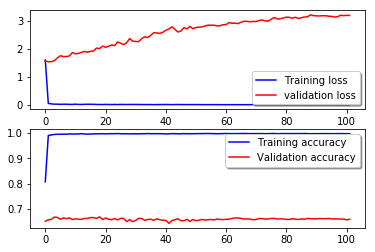

In [137]:
#Retrieve some information best train accuracy, validation accuracy, train loss and validation loss

index_acc = np.argmax(ensemble_history.history["acc"])
acc = ensemble_history.history["acc"][index_acc]
index_val_acc = np.argmax(ensemble_history.history["val_acc"])
val_acc = ensemble_history.history["val_acc"][index_val_acc]

index_loss = np.argmin(ensemble_history.history["loss"])
losses = ensemble_history.history["loss"][index_loss]
index_val_loss = np.argmin(ensemble_history.history["val_loss"])
val_losses = ensemble_history.history["val_loss"][index_val_loss]

acc_saved = ensemble_history.history["acc"][index_val_loss]
val_acc_saved = ensemble_history.history["val_acc"][index_val_loss]
train_loss_saved = losses = ensemble_history.history["loss"][index_val_loss]

print("best train accuracy {} on epoch {} ".format(acc, index_acc+1))
print("best validation accuracy {} on epoch {} ".format(val_acc, index_val_acc+1))
print("lowest train loss {} on epoch {} ".format(losses, index_loss+1))
print("lowest validation loss {} on epoch {} ".format(val_losses, index_val_loss+1))
print("saved accuracy : {}, val accuracy : {}, and train loss {} : ".format(acc_saved, val_acc_saved, train_loss_saved))

# Plot the loss and accuracy curves for training and validation on vgg model
fig, ax = plt.subplots(2,1)
ax[0].plot(ensemble_history.history['loss'], color='b', label="Training loss")
ax[0].plot(ensemble_history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(ensemble_history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(ensemble_history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# 4. Testing model's performance

## 4.1 Confusion Matrix and Precision-Recall

Confusion matrix can check false positives for each labels. This can visualize bias and variance of the model's prediction.

Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned. See [HERE](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html) for more info.

I validate the models using Test data.

In [145]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score

### InceptionV3

Average precision score, micro-averaged over all classes: 0.44
ROC AUC Score:  0.9790820458637852


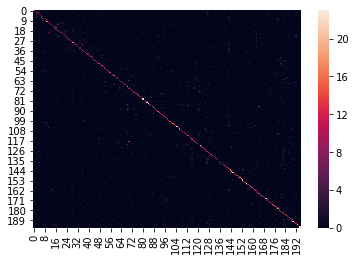

In [150]:
# Look at confusion matrix 

# Predict the values from the validation dataset
Y_pred = incept.predict(X_test_inception)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test_inception,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
ax = sns.heatmap(confusion_mtx)

#Calculating Precision-Recall Score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(196):
    precision[i], recall[i], _ = precision_recall_curve(y_test_inception[:, i],
                                                        Y_pred[:, i])
    average_precision[i] = average_precision_score(y_test_inception[:, i], Y_pred[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_inception.ravel(),
    Y_pred.ravel())
average_precision["micro"] = average_precision_score(y_test_inception, Y_pred,
                                                     average="micro")

print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

#Calculating ROC AUC Score

roc_score = roc_auc_score(y_test_inception, Y_pred)

print("ROC AUC Score: ", roc_score)

### Xception

Average precision score, micro-averaged over all classes: 0.50
ROC AUC Score:  0.9824882943932024


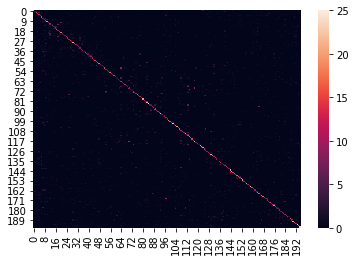

In [151]:
# Look at confusion matrix 

# Predict the values from the validation dataset
Y_pred = xcept.predict(X_test_xception)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test_xception,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
ax = sns.heatmap(confusion_mtx)

#Calculating Precision-Recall Score

# For each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(196):
    precision[i], recall[i], _ = precision_recall_curve(y_test_xception[:, i],
                                                        Y_pred[:, i])
    average_precision[i] = average_precision_score(y_test_xception[:, i], Y_pred[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_xception.ravel(),
    Y_pred.ravel())
average_precision["micro"] = average_precision_score(y_test_xception, Y_pred,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

#Calculating ROC AUC Score

roc_score = roc_auc_score(y_test_xception, Y_pred)

print("ROC AUC Score: ", roc_score)

### Resnet50

Average precision score, micro-averaged over all classes: 0.59
ROC AUC Score:  0.9869771002900094


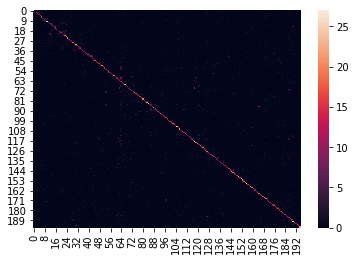

In [152]:
# Look at confusion matrix 

# Predict the values from the validation dataset
Y_pred = rest.predict(X_test_resnet)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test_resnet,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
ax = sns.heatmap(confusion_mtx)

#Calculating Precision-Recall Score

# For each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(196):
    precision[i], recall[i], _ = precision_recall_curve(y_test_resnet[:, i],
                                                        Y_pred[:, i])
    average_precision[i] = average_precision_score(y_test_resnet[:, i], Y_pred[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_resnet.ravel(),
    Y_pred.ravel())
average_precision["micro"] = average_precision_score(y_test_resnet, Y_pred,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

#Calculating ROC AUC Score

roc_score = roc_auc_score(y_test_resnet, Y_pred)

print("ROC AUC Score: ", roc_score)

### VGG19

Average precision score, micro-averaged over all classes: 0.48
ROC AUC Score:  0.9796499374539075


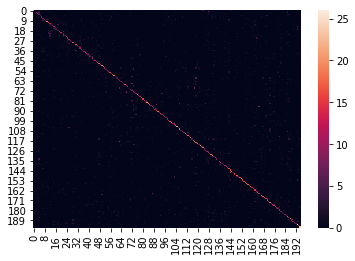

In [153]:
# Look at confusion matrix 

# Predict the values from the validation dataset
Y_pred = vg.predict(X_test_vgg)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test_vgg,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
ax = sns.heatmap(confusion_mtx)

#Calculating Precision-Recall Score

# For each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(196):
    precision[i], recall[i], _ = precision_recall_curve(y_test_vgg[:, i],
                                                        Y_pred[:, i])
    average_precision[i] = average_precision_score(y_test_vgg[:, i], Y_pred[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_vgg.ravel(),
    Y_pred.ravel())
average_precision["micro"] = average_precision_score(y_test_vgg, Y_pred,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

#Calculating ROC AUC Score

roc_score = roc_auc_score(y_test_vgg, Y_pred)

print("ROC AUC Score: ", roc_score)

## InceptionResnetV2

Average precision score, micro-averaged over all classes: 0.44
ROC AUC Score:  0.9774902336172602


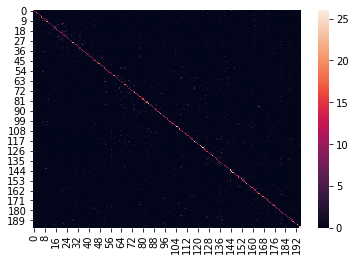

In [154]:
# Look at confusion matrix 

# Predict the values from the validation dataset
Y_pred = incres.predict(X_test_inceptionresnet)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test_inceptionresnet,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
ax = sns.heatmap(confusion_mtx)

#Calculating Precision-Recall Score

# For each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(196):
    precision[i], recall[i], _ = precision_recall_curve(y_test_inceptionresnet[:, i],
                                                        Y_pred[:, i])
    average_precision[i] = average_precision_score(y_test_inceptionresnet[:, i], Y_pred[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_inceptionresnet.ravel(),
    Y_pred.ravel())
average_precision["micro"] = average_precision_score(y_test_inceptionresnet, Y_pred,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

#Calculating ROC AUC Score

roc_score = roc_auc_score(y_test_inceptionresnet, Y_pred)

print("ROC AUC Score: ", roc_score)

## Ensemble Model

In [138]:
# Load best saved model for ensemble model

ensemble = load_model("saved_models/ensemble.best.from_features.hdf5")

Average precision score, micro-averaged over all classes: 0.70
ROC AUC Score:  0.9813272164290486


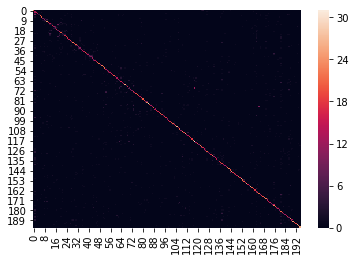

In [155]:
# Look at confusion matrix 

# Predict the values from the validation dataset
Y_pred = ensemble.predict(ensemble_test_x)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(ensemble_test_y,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
ax = sns.heatmap(confusion_mtx)

#Calculating Precision-Recall Score

# For each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(196):
    precision[i], recall[i], _ = precision_recall_curve(ensemble_test_y[:, i],
                                                        Y_pred[:, i])
    average_precision[i] = average_precision_score(ensemble_test_y[:, i], Y_pred[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(ensemble_test_y.ravel(),
    Y_pred.ravel())
average_precision["micro"] = average_precision_score(ensemble_test_y, Y_pred,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

#Calculating ROC AUC Score

roc_score = roc_auc_score(ensemble_test_y, Y_pred)

print("ROC AUC Score: ", roc_score)

## 4.2 Results Summary

#### 1. Inception

*Classification Accuracy: 0.6966 (train), 0.4229 (validation)

*Loss error             : 1.2172 (train), 2.1878 (validation)

*Average precision score, micro-averaged over all classes: 0.44

*ROC AUC Score:  0.9790820458637852

#### 2. Xception

*Classification Accuracy: 0.8115 (train), 0.4652 (validation)

*Loss error             : 0.6989 (train), 2.1083 (validation)

*Average precision score, micro-averaged over all classes: 0.50

*ROC AUC Score:  0.9824882943932024

#### 3. Resnet50

*Classification Accuracy: 0.8886 (train), 0.5572 (validation)

*Loss error             : 0.4049 (train), 1.7131 (validation)

*Average precision score, micro-averaged over all classes: 0.59

*ROC AUC Score:  0.9869771002900094

#### 4. VGG19

*Classification Accuracy: 0.7349 (train), 0.4773 (validation)

*Loss error             : 0.8825 (train), 2.1087 (validation)

*Average precision score, micro-averaged over all classes: 0.48

*ROC AUC Score:  0.9796499374539075

#### 5. InceptionResnet

*Classification Accuracy: 0.6971 (train), 0.4344 (validation)

*Loss error             : 1.0177 (train), 2.2085 (validation)

*Average precision score, micro-averaged over all classes: 0.44

*ROC AUC Score:  0.9774902336172602

### 6. Ensemble Model

*Classification Accuracy: 0.9905 (train), 0.6576 (validation)

*Loss error             : 0.0490 (train), 1.5401 (validation)

*Average precision score, micro-averaged over all classes: 0.70

*ROC AUC Score:  0.9813272164290486




It shows that Ensemble Model obtained significant improvement over others